---
# PROJET BANCAIRE
---

# **Étude d’un Pipeline de Data Science appliqué au Crédit Bancaire**

Ce projet explore différentes approches méthodologiques utilisées dans un pipeline complet de data science appliqué à l’analyse du risque client.

L’étude porte sur plusieurs problématiques :
- Prédiction du risque de défaut d’un client (classification)
- Estimation du montant de prêt pour les clients solvables (régression)
- Exploration de la prédiction de variables financières comme le salaire

Les données utilisées sont **100% synthétiques**, générées afin de simuler un environnement bancaire réaliste. L’objectif du projet n’est pas de produire un modèle opérationnel, mais d’analyser et comparer différentes stratégies de modélisation, d’évaluation et d’optimisation dans un cadre reproductible.

Le projet met notamment l’accent sur :
- La préparation et transformation des données
- La gestion du déséquilibre des classes
- La comparaison de plusieurs modèles
- L’optimisation des seuils métier
- La calibration des probabilités
- L’évaluation financière des décisions


## Analyse exploratoire

In [1]:
# Monter Google Drive (si sur Colab)
# from google.colab import drive
# drive.mount('/content/drive')

# Ajouter le chemin vers vos modules personnalisés
import sys
sys.path.append('/content/drive/MyDrive/projet-datascience/src')
sys.path.append('/content/drive/MyDrive/projet-datascience/src/preprocessing')

In [2]:
import os

file_path = '/content/drive/MyDrive/projet-datascience/src/preprocessing/custom_transformers.py'
print(f"\n\nLe fichier existe ? {os.path.exists(file_path)}")



Le fichier existe ? True


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from scipy.stats import skew

pd.set_option('future.no_silent_downcasting', True)

In [4]:
from custom_transformers import (
    DataCleaningTransformer,
    FeatureEngineeringTransformer,
    SmartImputerTransformer,
    CustomEncodingTransformer,
    MultiStrategyScaler,
    create_preprocessing_pipeline
)

 Transformers créés avec succès !


### Chargement de la table dans le dataframe

In [5]:
#visualisations paths
path='/content/drive/MyDrive/projet-datascience/outputs/'
dataset_path = '/content/drive/MyDrive/projet-datascience/'
df = pd.read_csv(f'{dataset_path}donnees_prets.csv', header=0)
df.head()

,ID,Age,Salaire_Annuel (€),Niveau_Etude,Ville,Score_Credit_Externe,Epargne_Totale (€),Montant_Pret_Accorde,Defaut_Paiement
0,1,56.0,91820.0,Master,Lyon,65.0,21580.0,34962.0,Non
1,2,53.0,56090.0,Licence,Paris,21.0,26356.0,22234.0,Non
2,3,19.0,98104.0,Doctorat,Lyon,98.0,2089.0,30607.0,Non
3,4,44.0,33431.0,Doctorat,Marseille,98.0,8758.0,13905.0,Non
4,5,20.0,56606.0,Bac,Paris,NaN,26699.0,23863.0,Non


In [6]:
# Affichage des infos générales
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    1000 non-null   int64  
 1   Age                   952 non-null    float64
 2   Salaire_Annuel (€)    951 non-null    float64
 3   Niveau_Etude          944 non-null    object 
 4   Ville                 943 non-null    object 
 5   Score_Credit_Externe  975 non-null    float64
 6   Epargne_Totale (€)    975 non-null    float64
 7   Montant_Pret_Accorde  959 non-null    object 
 8   Defaut_Paiement       978 non-null    object 
dtypes: float64(4), int64(1), object(4)
memory usage: 70.4+ KB
None


#### Netoyage des doublons

In [7]:
# Cherchons les doublons
df.duplicated().sum()

# Nous allons supprimer les doublons
df.drop_duplicates(inplace=True)

#### Netoyage des nom des colonnes

In [8]:
# Nétoyage des noms des colonnes :
df.columns = (
    df.columns
      .str.replace("€", "", regex=False)
      .str.replace("(", "", regex=False)
      .str.replace(")", "", regex=False)
      .str.strip()
)

# On supprime les ID car ils ne nous serviront à rien
df.drop(columns=['ID'], inplace=True)

# Affichage des colonnes
print(df.columns)

Index(['Age', 'Salaire_Annuel', 'Niveau_Etude', 'Ville',
       'Score_Credit_Externe', 'Epargne_Totale', 'Montant_Pret_Accorde',
       'Defaut_Paiement'],
      dtype='object')


### Remplacer les valeurs inconnues par NaN de numpy

In [9]:
def scanner_intrus(df):
    print(" RECHERCHE DES VALEURS NON-NUMÉRIQUES DANS LES COLONNES")
    print("-" * 60)

    for col in df.columns:
        # On essaie de convertir en numérique. errors='coerce' transforme les intrus en NaN
        temp_numeric = pd.to_numeric(df[col], errors='coerce')

        # On récupère les valeurs d'origine là où la conversion a échoué (et qui ne sont pas déjà des NaN)
        intrus = df[col][temp_numeric.isna() & df[col].notna()].unique()

        if len(intrus) > 0:
            print(f"Column: {col.upper()}")
            print(f" Valeurs génériques trouvées : {intrus}")
            print("-" * 30)

scanner_intrus(df)

 RECHERCHE DES VALEURS NON-NUMÉRIQUES DANS LES COLONNES
------------------------------------------------------------
Column: NIVEAU_ETUDE
 Valeurs génériques trouvées : ['Master' 'Licence' 'Doctorat' 'Bac' '--']
------------------------------
Column: VILLE
 Valeurs génériques trouvées : ['Lyon' 'Paris' 'Marseille' '-' '?']
------------------------------
Column: MONTANT_PRET_ACCORDE
 Valeurs génériques trouvées : ['-' '?']
------------------------------
Column: DEFAUT_PAIEMENT
 Valeurs génériques trouvées : ['Non' 'Oui' '-' '?' '--']
------------------------------


#### Nous vérifions le nombre d'occurrences de ces intrus dans nos données

In [10]:
for col in df.columns:
    print(df[col].value_counts(dropna=False))

Age
NaN     48
52.0    27
68.0    26
53.0    25
37.0    24
50.0    23
31.0    23
47.0    23
39.0    22
51.0    22
61.0    22
21.0    21
34.0    21
32.0    21
45.0    21
28.0    20
62.0    20
48.0    20
40.0    19
19.0    19
56.0    19
27.0    19
59.0    19
20.0    19
42.0    19
30.0    19
44.0    18
65.0    18
22.0    18
38.0    18
54.0    18
57.0    17
69.0    17
43.0    17
23.0    17
25.0    17
49.0    17
55.0    17
41.0    16
18.0    16
33.0    16
36.0    16
24.0    15
67.0    15
35.0    15
66.0    15
46.0    14
26.0    13
58.0    13
29.0    13
60.0    12
64.0    11
63.0    10
Name: count, dtype: int64
Salaire_Annuel
NaN        49
60648.0     2
92454.0     2
44592.0     2
92129.0     2
           ..
56814.0     1
86906.0     1
65939.0     1
98297.0     1
95257.0     1
Name: count, Length: 944, dtype: int64
Niveau_Etude
Licence     262
Bac         250
Doctorat    218
Master      209
NaN          56
--            5
Name: count, dtype: int64
Ville
Marseille    325
Paris        314
Lyon

**Analyse** :
- Ceci est important car si nous avons un taux d'occurence de ces intrus très élévé, ceci influence considérablement notre approche pour l'imputation à faire.

  - ***Ex*** : pour les variables catégorielles, si après remplacement des intrus par np.nan, créer une catégorie inconnu
  - Pour les variables numériques, après imputation, créer une colonne binaire qui indique la présence ou l'abscence de l'information.

- nous pourrions envisager l'intégration d'une stratégie d'imputation multivariée basée sur l'algorithme ***Expectation-Maximization (EM)*** ou l'***Iterative Imputer***. Cette approche permettrait de ne plus traiter les données manquantes comme des points isolés, mais comme des variables dépendantes du contexte global du client.

In [11]:
# Intrus détectés dans notre dataset
generic_missing_values = ['-', '?', 'null', '', 'NaN', 'none', '--']

In [12]:
## Remplacon les valeurs manquantes
dataclean = DataCleaningTransformer(generic_missing_values)
df = dataclean.transform(df)

### On re scane notre dataframe

In [13]:
scanner_intrus(df)

 RECHERCHE DES VALEURS NON-NUMÉRIQUES DANS LES COLONNES
------------------------------------------------------------
Column: NIVEAU_ETUDE
 Valeurs génériques trouvées : ['Master' 'Licence' 'Doctorat' 'Bac']
------------------------------
Column: VILLE
 Valeurs génériques trouvées : ['Lyon' 'Paris' 'Marseille']
------------------------------
Column: DEFAUT_PAIEMENT
 Valeurs génériques trouvées : ['Non' 'Oui']
------------------------------


#### Typage de nos colonnes numériques

In [14]:
# Dans notre cas, seul la colonne Montant_Pret_Accorde n'est pas au bon type
df['Montant_Pret_Accorde'] = pd.to_numeric(df['Montant_Pret_Accorde'], errors='coerce')
print(df.dtypes)

Age                     float64
Salaire_Annuel          float64
Niveau_Etude             object
Ville                    object
Score_Credit_Externe    float64
Epargne_Totale          float64
Montant_Pret_Accorde    float64
Defaut_Paiement          object
dtype: object


In [15]:
# Cherchons les valeur null ou manquantes
Nombre_Manquantes =df.isnull().sum()

# Calcul du pourcentage des valeurs manquantes
valeurs_manquantes = pd.DataFrame({
    "Nombre_Manquantes": Nombre_Manquantes,
    "Pourcentage_Manquantes": df.isnull().sum() / len(df) * 100
})

# Nous allons trier par ordre décroissant, pour aller des pires colonnes aux moins
valeurs_manquantes = valeurs_manquantes.sort_values(by='Pourcentage_Manquantes', ascending=False)
print(valeurs_manquantes)

                      Nombre_Manquantes  Pourcentage_Manquantes
Ville                                67                     6.7
Niveau_Etude                         61                     6.1
Salaire_Annuel                       49                     4.9
Age                                  48                     4.8
Montant_Pret_Accorde                 45                     4.5
Defaut_Paiement                      30                     3.0
Epargne_Totale                       25                     2.5
Score_Credit_Externe                 25                     2.5


### VISUALISATION DES DONNÉES

In [16]:
def plot_numerique_avant(df, col):
    # Crée l'histogramme et obtient l'objet Axes
    ax = df[col].dropna().hist(bins=30)

    # Calcule la moyenne et la médiane
    mean_val = df[col].mean()
    median_val = df[col].median()

    # Ajoute la moyenne en ligne verticale rouge
    ax.axvline(mean_val, color='red', linestyle='--',
               linewidth=2, label=f'Moyenne: {mean_val:.0f}')
    # Ajoute la médiane en ligne verticale verte
    ax.axvline(median_val, color='green', linestyle='--',
               linewidth=2, label=f'Médiane: {median_val:.0f}')

    ax.set_title(f"{col} — AVANT imputation")
    ax.set_xlabel(col)
    ax.set_ylabel("Fréquence")
    ax.legend()
    plt.show()

In [17]:
# Variable catégorielle — barplot
def plot_categorielle_avant(df, col):
    df[col].value_counts(dropna=True).plot(kind="bar")
    plt.title(f"{col} — AVANT imputation")
    plt.ylabel("Nombre d'occurrences")
    plt.show()

In [18]:
# Variable ordinale — distribution ordonnée
def plot_ordinale(df, col, ordre):
    df[col] = pd.Categorical(df[col], categories=ordre, ordered=True)
    df[col].value_counts().sort_index().plot(kind="bar")
    plt.title(f"{col} — Distribution")
    plt.ylabel("Effectif")
    plt.show()

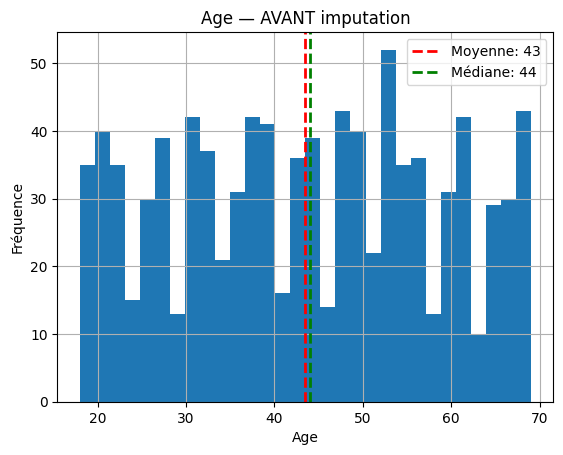

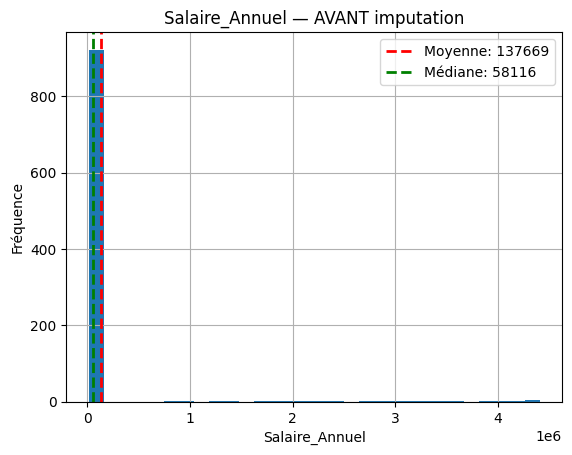

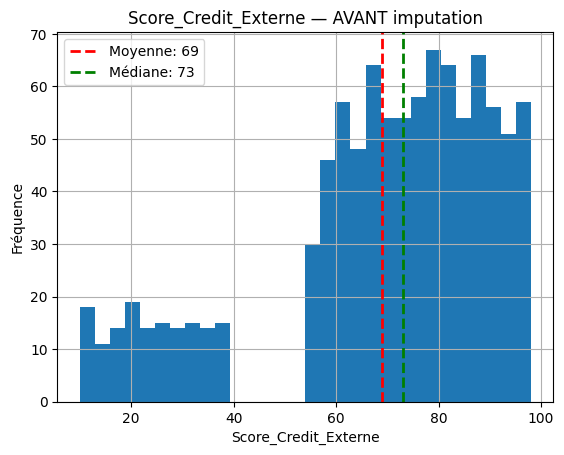

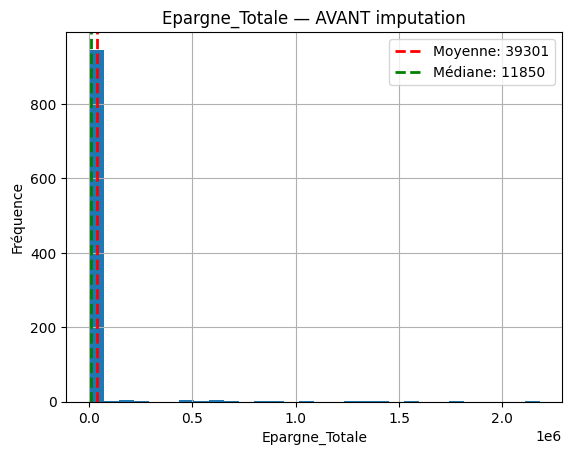

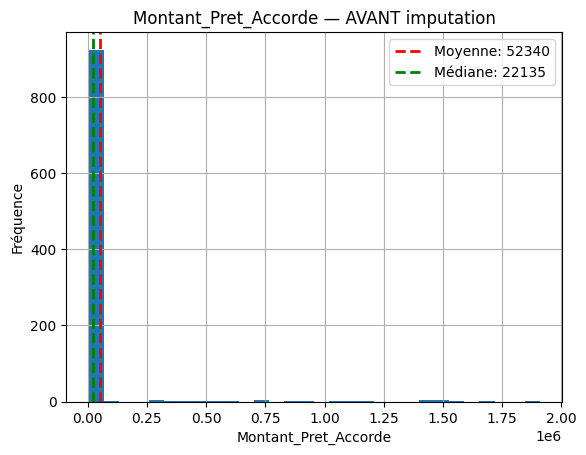

In [19]:
plot_numerique_avant(df, 'Age')
plot_numerique_avant(df, 'Salaire_Annuel')
plot_numerique_avant(df, 'Score_Credit_Externe')
plot_numerique_avant(df, 'Epargne_Totale')
plot_numerique_avant(df, 'Montant_Pret_Accorde')

### ANALYSE DES DISTRIBUTIONS NUMÉRIQUES AVANT IMPUTATION

Après avoir visualisé les distributions des colonnes numériques 'Age', 'Salaire_Annuel', 'Score_Credit_Externe' et 'Epargne_Totale' à l'aide des histogrammes générés par la fonction `plot_numerique_avant`, voici une analyse des caractéristiques observées pour chaque variable :

-   **Age** :
    -   La distribution de l'âge semble relativement normale, centrée autour d'une moyenne, avec une légère asymétrie. Il y a des valeurs manquantes, mais la forme générale est celle d'une cloche, bien que non parfaitement symétrique.

-   **Salaire_Annuel** :
    -   La distribution du salaire annuel est clairement asymétrique vers la droite (skewed right). La plupart des salaires se concentrent dans les plages inférieures, avec une longue queue s'étendant vers des salaires plus élevés. Cela suggère que la médiane pourrait être une meilleure mesure de la tendance centrale que la moyenne pour cette colonne, et l'imputation par la médiane serait appropriée pour les valeurs manquantes afin de ne pas être excessivement influencée par les valeurs extrêmes.

-   **Score_Credit_Externe** :
    -   La distribution du score de crédit externe semble bimodale ou multimodale, avec des pics à différentes valeurs. Cela pourrait indiquer des sous-groupes distincts au sein des scores de crédit. La distribution ne semble pas suivre une loi normale simple et pourrait bénéficier d'une imputation qui tient compte de cette complexité, potentiellement la médiane si l'asymétrie est présente, ou la moyenne si la distribution est plus symétrique entre les modes.

-   **Epargne_Totale** :
    -   Similaire au salaire annuel, la distribution de l'épargne totale est également asymétrique vers la droite. La majorité des individus ont une épargne plus faible, et quelques-uns ont des montants d'épargne beaucoup plus élevés. Ici aussi, l'imputation par la médiane serait probablement plus robuste que l'imputation par la moyenne pour gérer les valeurs manquantes, compte tenu de l'asymétrie prononcée.

-   **Montant_Pret_Accorde** :
    -   Similaire au salaire annuel, la distribution du Montant_Pret_Accorde est également asymétrique vers la droite. La majorité des individus ont un Montant de Pret plus faible, et quelques-uns en ont un beaucoup plus élevés. Ici aussi, l'imputation par la médiane serait probablement plus robuste que l'imputation par la moyenne pour gérer les valeurs manquantes, compte tenu de l'asymétrie prononcée.

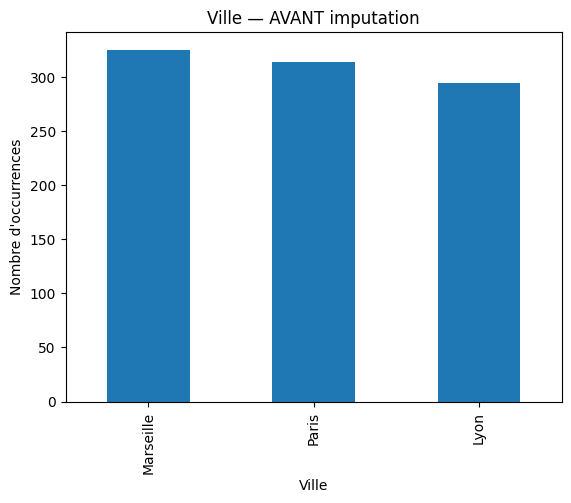

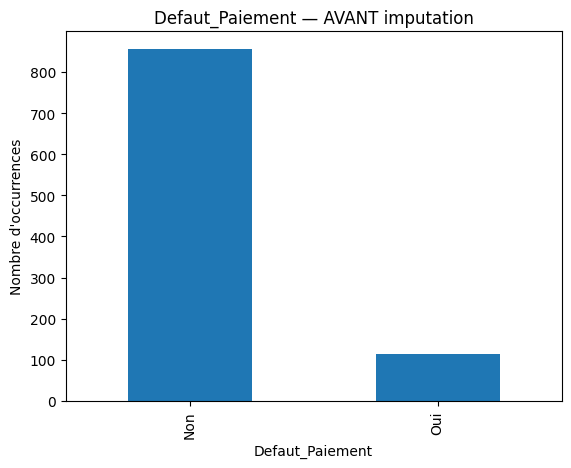

In [20]:
plot_categorielle_avant(df, 'Ville')
plot_categorielle_avant(df, 'Defaut_Paiement')

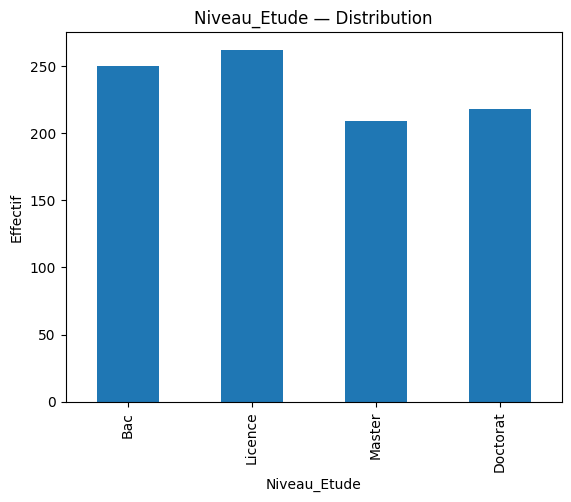

In [21]:
plot_ordinale(df, 'Niveau_Etude', ['Bac', 'Licence', 'Master', 'Doctorat'])

### ANALYSE DES DISTRIBUTIONS CATEGORIELLES ET ORDINALES AVANT IMPUTATION

Après avoir visualisé les distributions des colonnes catégorielles 'Ville' et ordinale 'Niveau_Etude' à l'aide des fonctions `plot_categorielle_avant` et `plot_ordinale`, voici une analyse des caractéristiques observées pour chaque variable :

-   **Ville** :
    -   La distribution des villes, observée via le diagramme à barres, révèle la **répartition géographique** de nos clients. On peut identifier les villes où la concentration de clients est la plus forte (par exemple, Paris, Lyon, Marseille sont souvent prédominantes). Ces pics indiquent des zones clés pour l'activité bancaire.
    -   Il est également possible d'observer des villes avec un nombre très faible d'occurrences. Une telle distribution peut suggérer la nécessité de regrouper des villes rares dans une catégorie 'Autre' si le nombre de catégories uniques est trop élevé pour l'analyse future, ou d'adapter les stratégies marketing localement.
    -   L'absence de barre pour certaines villes (si aucune donnée n'est présente) est également une information, bien que `value_counts(dropna=True)` ignore les valeurs manquantes.

-   **Niveau_Etude** :
    -   La visualisation de la distribution des niveaux d'étude, affichée dans l'ordre logique ('Bac', 'Licence', 'Master', 'Doctorat'), donne un aperçu du **profil académique** de la clientèle.
    -   On peut identifier le ou les niveaux d'étude les plus fréquents au sein de notre échantillon. Par exemple, une forte proportion de 'Licence' ou 'Master' indiquerait une clientèle avec un niveau d'éducation supérieur.
    -   Cette analyse permet de comprendre la composition éducative de la base de clients, ce qui peut avoir des implications sur le type de produits financiers offerts ou sur les stratégies de communication. La répartition ordonnée aide à interpréter la progression et la concentration des niveaux d'étude.

-   **Defaut_Paiement** :
    -   La distribution de la variable `Defaut_Paiement` montre une **forte disparité** entre les catégories 'Non' et 'Oui'. Il y a une nette prédominance de la catégorie 'Non', ce qui indique qu'une grande majorité des clients n'est pas en défaut de paiement.
    -   Cette observation est cruciale car elle révèle un **déséquilibre des classes (class imbalance)**. Si la variable `Defaut_Paiement` est la variable cible pour un modèle prédictif, cet déséquilibre devra être géré lors de l'entraînement du modèle (par exemple, via des techniques de suréchantillonnage, sous-échantillonnage ou l'utilisation de métriques d'évaluation adaptées comme la précision-rappel ou le score F1 plutôt que la simple précision).

## ANALYSE UNIVARIÉE

In [22]:
# Séparation des types de variables
print(df.dtypes)
variables_numeriques = df.select_dtypes(include=[np.number]).columns.tolist()
variables_categorielles=df.select_dtypes(include=['object', 'category']).columns.tolist()

# Affichage :
print(f"Variables numériques ({len(variables_numeriques)}) : {variables_numeriques}")
print(f"Variables catégorielles ({len(variables_categorielles)}) : {variables_categorielles}")

Age                      float64
Salaire_Annuel           float64
Niveau_Etude            category
Ville                     object
Score_Credit_Externe     float64
Epargne_Totale           float64
Montant_Pret_Accorde     float64
Defaut_Paiement           object
dtype: object
Variables numériques (5) : ['Age', 'Salaire_Annuel', 'Score_Credit_Externe', 'Epargne_Totale', 'Montant_Pret_Accorde']
Variables catégorielles (3) : ['Niveau_Etude', 'Ville', 'Defaut_Paiement']


In [23]:
print("2.3 - ANALYSE DES VARIABLES NUMERIQUES")
print("-" * 80)
print(df[variables_numeriques].describe())
print()

for col in variables_numeriques:
    print("\n")
    print("=" * 50)
    print(f"\nAnalyse de la colonne : {col.upper()}")
    print("=" * 50)


    # Mésure de tendance centrale
    mean_val = df[col].mean()
    median_val = df[col].median()

    tab_tendance_centrale = pd.DataFrame({
        'Mesure': ['Moyenne', 'Médiane'],
        'Valeur': [f"{mean_val:.2f}", f"{median_val:.2f}"]
    })
    print("\n Mésure de tendance centrale :")
    display(tab_tendance_centrale)

    # Mésure de la dispersion
    std_val = df[col].std()
    min_val = df[col].min()
    max_val = df[col].max()
    q1_val = df[col].quantile(0.25)
    q3_val = df[col].quantile(0.75)
    iqr_val = q3_val - q1_val

    tab_dispersion = pd.DataFrame({
        'Mesure': ['Écart-type', 'Minimum', 'Maximum', 'Q1 (25%)', 'Q3 (75%)', 'IQR'],
        'Valeur': [f"{std_val:.2f}", f"{min_val:.2f}", f"{max_val:.2f}", f"{q1_val:.2f}", f"{q3_val:.2f}", f"{iqr_val:.2f}"]
    })
    print("\n Mésure de la dispersion :")
    display(tab_dispersion)

2.3 - ANALYSE DES VARIABLES NUMERIQUES
--------------------------------------------------------------------------------
              Age  Salaire_Annuel  Score_Credit_Externe  Epargne_Totale  \
count  952.000000    9.510000e+02            975.000000    9.750000e+02   
mean    43.399160    1.376690e+05             68.991795    3.930072e+04   
std     14.716041    4.984888e+05             22.355443    1.709001e+05   
min     18.000000    1.506600e+04             10.000000    1.960000e+02   
25%     31.000000    3.501350e+04             60.000000    5.729500e+03   
50%     44.000000    5.811600e+04             73.000000    1.185000e+04   
75%     55.000000    8.133900e+04             86.000000    2.210000e+04   
max     69.000000    4.404722e+06             98.000000    2.179916e+06   

       Montant_Pret_Accorde  
count          9.550000e+02  
mean           5.234045e+04  
std            1.891422e+05  
min            4.905000e+03  
25%            1.356800e+04  
50%            2.213500e

,Mesure,Valeur
0,Moyenne,43.40
1,Médiane,44.00



 Mésure de la dispersion :


,Mesure,Valeur
0,Écart-type,14.72
1,Minimum,18.00
2,Maximum,69.00
3,Q1 (25%),31.00
4,Q3 (75%),55.00
5,IQR,24.00





Analyse de la colonne : SALAIRE_ANNUEL

 Mésure de tendance centrale :


,Mesure,Valeur
0,Moyenne,137668.97
1,Médiane,58116.00



 Mésure de la dispersion :


,Mesure,Valeur
0,Écart-type,498488.82
1,Minimum,15066.00
2,Maximum,4404722.00
3,Q1 (25%),35013.50
4,Q3 (75%),81339.00
5,IQR,46325.50





Analyse de la colonne : SCORE_CREDIT_EXTERNE

 Mésure de tendance centrale :


,Mesure,Valeur
0,Moyenne,68.99
1,Médiane,73.00



 Mésure de la dispersion :


,Mesure,Valeur
0,Écart-type,22.36
1,Minimum,10.00
2,Maximum,98.00
3,Q1 (25%),60.00
4,Q3 (75%),86.00
5,IQR,26.00





Analyse de la colonne : EPARGNE_TOTALE

 Mésure de tendance centrale :


,Mesure,Valeur
0,Moyenne,39300.72
1,Médiane,11850.00



 Mésure de la dispersion :


,Mesure,Valeur
0,Écart-type,170900.06
1,Minimum,196.00
2,Maximum,2179916.00
3,Q1 (25%),5729.50
4,Q3 (75%),22100.00
5,IQR,16370.50





Analyse de la colonne : MONTANT_PRET_ACCORDE

 Mésure de tendance centrale :


,Mesure,Valeur
0,Moyenne,52340.45
1,Médiane,22135.00



 Mésure de la dispersion :


,Mesure,Valeur
0,Écart-type,189142.15
1,Minimum,4905.00
2,Maximum,1907714.00
3,Q1 (25%),13568.00
4,Q3 (75%),30190.00
5,IQR,16622.00


In [24]:
print("ANALYSE DES VARIABLES CATÉGORIELLES")
print("=" * 80)
for col in variables_categorielles:
    print(f"\n {col}")
    print(f"   • Nombre de catégories uniques : {df[col].nunique()}")
    print(f"   • Valeurs uniques : {df[col].unique()}")

    # Créer un DataFrame pour afficher les décomptes
    counts_df = df[col].value_counts(dropna=False).rename('Occurence').reset_index()
    counts_df.columns = [col, 'Occurence']

    # Créer un DataFrame pour afficher les pourcentages
    percentages_df = (df[col].value_counts(normalize=True, dropna=False) * 100).rename('Pourcentage').reset_index()
    percentages_df.columns = [col, 'Pourcentage']

    # Fusionner les deux DataFrames
    analysis_df = pd.merge(counts_df, percentages_df, on=col)

    print("*" * 50)
    print(f"\n  • Répartition des occurrences et pourcentages:\n")
    display(analysis_df)
    print("-" * 70)
print()

ANALYSE DES VARIABLES CATÉGORIELLES

 Niveau_Etude
   • Nombre de catégories uniques : 4
   • Valeurs uniques : ['Master', 'Licence', 'Doctorat', 'Bac', NaN]
Categories (4, object): ['Bac' < 'Licence' < 'Master' < 'Doctorat']
**************************************************

  • Répartition des occurrences et pourcentages:



,Niveau_Etude,Occurence,Pourcentage
0,Licence,262,26.2
1,Bac,250,25.0
2,Doctorat,218,21.8
3,Master,209,20.9
4,NaN,61,6.1


----------------------------------------------------------------------

 Ville
   • Nombre de catégories uniques : 3
   • Valeurs uniques : ['Lyon' 'Paris' 'Marseille' nan]
**************************************************

  • Répartition des occurrences et pourcentages:



,Ville,Occurence,Pourcentage
0,Marseille,325,32.5
1,Paris,314,31.4
2,Lyon,294,29.4
3,NaN,67,6.7


----------------------------------------------------------------------

 Defaut_Paiement
   • Nombre de catégories uniques : 2
   • Valeurs uniques : ['Non' 'Oui' nan]
**************************************************

  • Répartition des occurrences et pourcentages:



,Defaut_Paiement,Occurence,Pourcentage
0,Non,856,85.6
1,Oui,114,11.4
2,NaN,30,3.0


----------------------------------------------------------------------



## DETECTION DES OUTLIERS

In [25]:
def analyser_outliers_iqr(df, col, facteur=1.5):
    """
    Analyse des outliers par la méthode IQR.
    Ne modifie pas les données.
    """

    serie = df[col].dropna()

    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1

    limite_basse = Q1 - facteur * IQR
    limite_haute = Q3 + facteur * IQR

    outliers = serie[(serie < limite_basse) | (serie > limite_haute)]

    return {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "limite_basse": limite_basse,
        "limite_haute": limite_haute,
        "nb_outliers": len(outliers),
        "pct_outliers": len(outliers) / len(df) * 100,
        "outliers": outliers
    }

In [26]:
def rapport_outliers(df, variables_numeriques):
    print("3.2 - DÉTECTION DES OUTLIERS PAR VARIABLE")
    print("-" * 80)

    outliers_dict = {}

    for col in variables_numeriques:
        analyse = analyser_outliers_iqr(df, col)

        print(f"\n {col}")
        print(f"   • Q1 (25e percentile) : {analyse['Q1']:.2f}")
        print(f"   • Q3 (75e percentile) : {analyse['Q3']:.2f}")
        print(f"   • IQR : {analyse['IQR']:.2f}")
        print(f"   • Limite basse : {analyse['limite_basse']:.2f}")
        print(f"   • Limite haute : {analyse['limite_haute']:.2f}")
        print(f"   • Outliers détectés : {analyse['nb_outliers']} ({analyse['pct_outliers']:.2f}%)")

        if analyse["nb_outliers"] > 0:
            print(f"   • Exemples : {analyse['outliers'].head().tolist()}")
            outliers_dict[col] = analyse["outliers"]

    print("\n MÉTHODOLOGIE")
    print(
        "   • Méthode utilisée : IQR (Intervalle Inter-Quartile)\n"
        "   • Raison : distributions asymétriques observées dans les histogrammes\n"
        "   • Méthode robuste, ne supposant PAS de normalité"
    )

    print(
        "\n NOTE IMPORTANTE :\n"
        "   Si les histogrammes avaient montré une distribution proche d'une loi normale,\n"
        "   nous aurions utilisé la méthode du Z-score.\n"
        "   Seuil classique : |Z| > 3 (parfois 2.5 selon le contexte).\n"
        "   Le Z-score suppose une distribution symétrique et gaussienne."
    )

    return outliers_dict

In [27]:
outliers_dict = rapport_outliers(df, variables_numeriques)

3.2 - DÉTECTION DES OUTLIERS PAR VARIABLE
--------------------------------------------------------------------------------

 Age
   • Q1 (25e percentile) : 31.00
   • Q3 (75e percentile) : 55.00
   • IQR : 24.00
   • Limite basse : -5.00
   • Limite haute : 91.00
   • Outliers détectés : 0 (0.00%)

 Salaire_Annuel
   • Q1 (25e percentile) : 35013.50
   • Q3 (75e percentile) : 81339.00
   • IQR : 46325.50
   • Limite basse : -34474.75
   • Limite haute : 150827.25
   • Outliers détectés : 29 (2.90%)
   • Exemples : [3509758.0, 1786643.0, 2832517.0, 878892.0, 2432728.0]

 Score_Credit_Externe
   • Q1 (25e percentile) : 60.00
   • Q3 (75e percentile) : 86.00
   • IQR : 26.00
   • Limite basse : 21.00
   • Limite haute : 125.00
   • Outliers détectés : 53 (5.30%)
   • Exemples : [13.0, 16.0, 16.0, 13.0, 12.0]

 Epargne_Totale
   • Q1 (25e percentile) : 5729.50
   • Q3 (75e percentile) : 22100.00
   • IQR : 16370.50
   • Limite basse : -18826.25
   • Limite haute : 46655.75
   • Outliers dé

## VISUALISATION DES BOXPLOTS


In [28]:
def visualiser_boxplots(df, variables_numeriques, nrows=2, ncols=3, save_path=None):
    """
    Visualisation des outliers via boxplots (méthode IQR).
    Ne modifie pas les données.
    """

    print("3.3 - VISUALISATION : BOXPLOTS (BOÎTES À MOUSTACHES)")
    print("-" * 80)
    print("Création des boxplots pour visualiser les outliers...")

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))
    fig.suptitle("DÉTECTION DES OUTLIERS - BOXPLOTS", fontsize=16, fontweight="bold")
    axes = axes.flatten()

    for idx, col in enumerate(variables_numeriques):
        data = df[col].dropna()

        bp = axes[idx].boxplot(
            data,
            vert=True,
            patch_artist=True
        )

        # Personnalisation visuelle
        for patch in bp["boxes"]:
            patch.set_facecolor("lightblue")
        for whisker in bp["whiskers"]:
            whisker.set(linewidth=1.5)
        for flier in bp["fliers"]:
            flier.set(marker="o", alpha=0.5)

        axes[idx].set_title(f"Boxplot de {col}", fontweight="bold")
        axes[idx].set_ylabel("Valeur")
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f" Boxplots sauvegardés dans '{save_path}'")

    plt.show()

3.3 - VISUALISATION : BOXPLOTS (BOÎTES À MOUSTACHES)
--------------------------------------------------------------------------------
Création des boxplots pour visualiser les outliers...
 Boxplots sauvegardés dans '/content/drive/MyDrive/projet-datascience/outputs/visualisation_outliers.png'


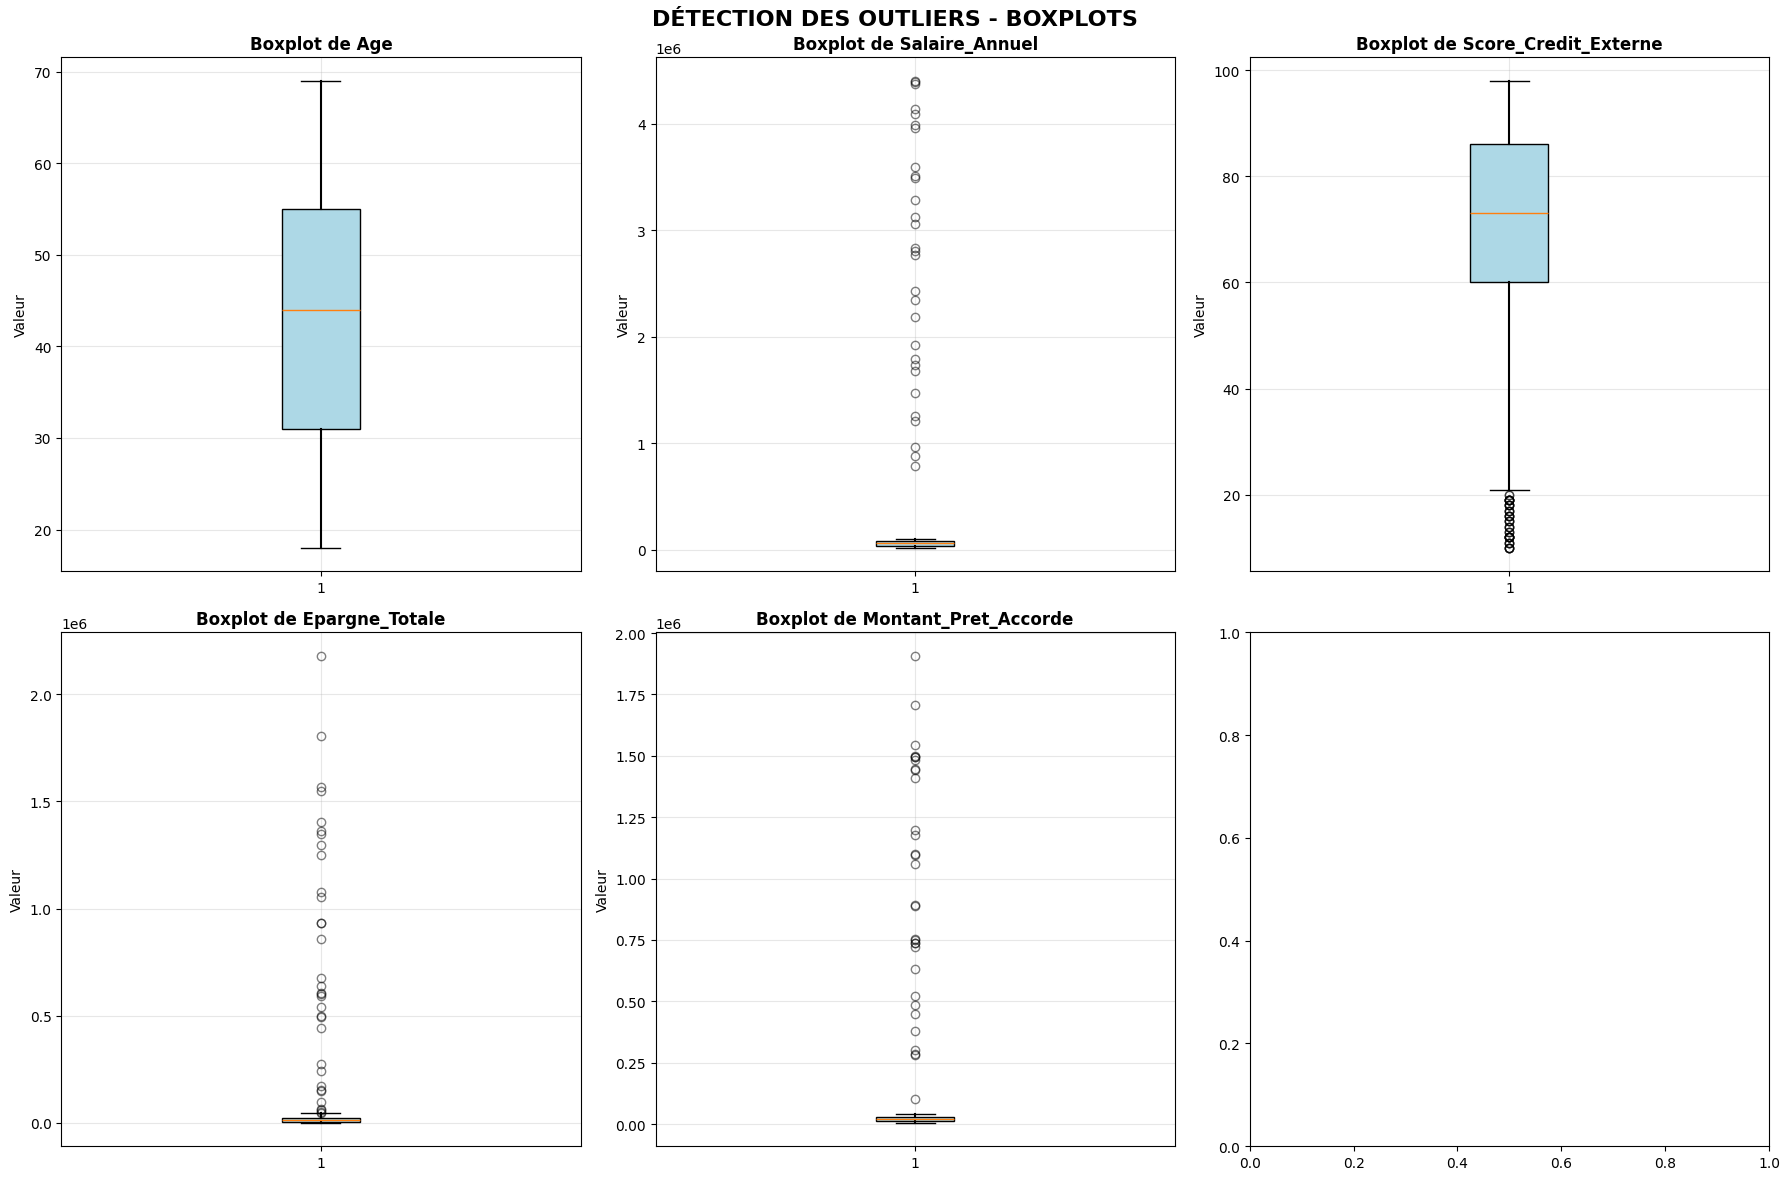

In [29]:
visualiser_boxplots(
    df,
    variables_numeriques,
    nrows=2,
    ncols=3,
    save_path=f"{path}visualisation_outliers.png"
)

### ANALYSE DES BOXPLOTS POUR LA DETECTION DES OUTLIERS

Les boxplots (diagrammes en boîte) générés nous permettent de visualiser la distribution de chaque variable numérique et d'identifier la présence d'outliers potentiels.

**Interprétation d'un Boxplot :**
*   La **ligne centrale** dans la boîte représente la **médiane** (50e percentile).
*   Les **bords de la boîte** représentent le premier quartile (Q1, 25e percentile) et le troisième quartile (Q3, 75e percentile). La hauteur de la boîte correspond à l'Intervalle Inter-Quartile (IQR = Q3 - Q1).
*   Les **moustaches (whiskers)** s'étendent des bords de la boîte jusqu'à la dernière donnée non considérée comme un outlier. Typiquement, elles s'étendent à 1.5 * IQR de Q1 et Q3.
*   Les **points individuels** au-delà des moustaches sont les **outliers** (valeurs aberrantes), détectés selon la méthode IQR.

**Analyse par Variable :**

*   **Age :**
    *   La distribution de l'âge est relativement symétrique, avec la médiane proche du centre de la boîte.
    *   Les moustaches sont de longueurs similaires de part et d'autre de la boîte.
    *   **Aucun outlier** n'a été détecté pour l'âge, ce qui corrobore l'analyse précédente et suggère une distribution assez concentrée autour de la moyenne.

*   **Salaire_Annuel :**
    *   La boîte est clairement asymétrique et compressée vers le bas, indiquant que la majorité des salaires sont concentrés dans les valeurs inférieures.
    *   La moustache supérieure est très longue et de **nombreux points sont visibles au-delà de la moustache supérieure**, ce qui indique la présence d'un nombre significatif d'**outliers par le haut**. Ces outliers représentent des individus avec des salaires annuels exceptionnellement élevés par rapport à la majorité de l'échantillon.

*   **Score_Credit_Externe :**
    *   La distribution du score de crédit externe montre une boîte relativement centrée, mais avec des moustaches de longueurs différentes.
    *   Des **outliers sont détectés en dessous de la moustache inférieure**, indiquant des individus avec des scores de crédit externe très bas. La présence de ces valeurs extrêmes vers le bas est notable.

*   **Epargne_Totale :**
    *   Similaire au salaire annuel, la distribution de l'épargne totale est fortement asymétrique vers le haut.
    *   La boîte est concentrée vers les valeurs faibles, et la moustache supérieure est très étendue.
    *   **De nombreux outliers sont présents au-dessus de la moustache supérieure**, révélant des individus ayant des montants d'épargne exceptionnellement élevés.


*   **Montant_Pret_Accorde :**
    *   Similaire au salaire annuel, la distribution du montant de pret accordé est aussi fortement asymétrique vers le haut.
    *   La boîte est concentrée vers les valeurs faibles, et la moustache supérieure est très étendue.
    *   **De nombreux outliers sont présents au-dessus de la moustache supérieure**.

**Conclusion Générale :**
Les boxplots confirment la présence d'outliers significatifs dans les variables `Salaire_Annuel`, `Score_Credit_Externe`, `Montant_Pret_Accorde` et `Epargne_Totale`, principalement vers les valeurs hautes pour les salaires, les montants de prets accordés et l'épargne, et vers les valeurs basses pour le score de crédit. Pour l'âge, l'absence d'outliers renforce l'idée d'une distribution plus homogène. Ces outliers devront être pris en compte lors de l'étape de nettoyage et de préparation des données pour éviter qu'ils n'influencent négativement les modèles statistiques.

## ANALYSE BIVARIÉE

#### NUMÉRIQUE vs NUMÉRIQUE : NUAGES DE POINTS

In [30]:
def plot_scatter_with_trend(ax, df, var1, var2):
    clean_data = df[[var1, var2]].dropna()
    if not clean_data.empty:
        ax.scatter(clean_data[var1], clean_data[var2], alpha=0.5, s=30)

        # Sécurité pour les variables constantes
        if clean_data[var1].nunique() > 1:
            z = np.polyfit(clean_data[var1], clean_data[var2], 1)
            p = np.poly1d(z)
            ax.plot(clean_data[var1], p(clean_data[var1]),
                    linestyle="--", color='red', alpha=0.8)

    ax.set_title(f"{var1} vs {var2}")
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.grid(True, alpha=0.3)

In [31]:
len(variables_numeriques)

5

In [32]:
def visualiser_bivariee_numerique_scatter(df, variables_numeriques, nrows=len(variables_numeriques), ncols=len(variables_numeriques)):
    """
    Orchestrateur propre pour l'analyse bivariée numérique.
    """
    vars_scatter = variables_numeriques[:nrows*ncols]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
    fig.suptitle("Analyse bivariée – variables numériques \n", fontsize=16)
    axes = axes.flatten()

    idx = 0
    for var1 in vars_scatter:
        for var2 in vars_scatter:
            if idx >= len(axes): break

            ax = axes[idx] # On cible l'objet directement

            if var1 == var2:
                # Utilisation de l'objet ax pour l'histogramme
                df[var1].dropna().hist(bins=30, ax=ax, color='skyblue', alpha=0.7)
                ax.set_title(f"Distribution de {var1}")
            else:
                # Appel de la fonction atomique améliorée
                plot_scatter_with_trend(ax, df, var1, var2)

            idx += 1

    plt.tight_layout()
    plt.show()

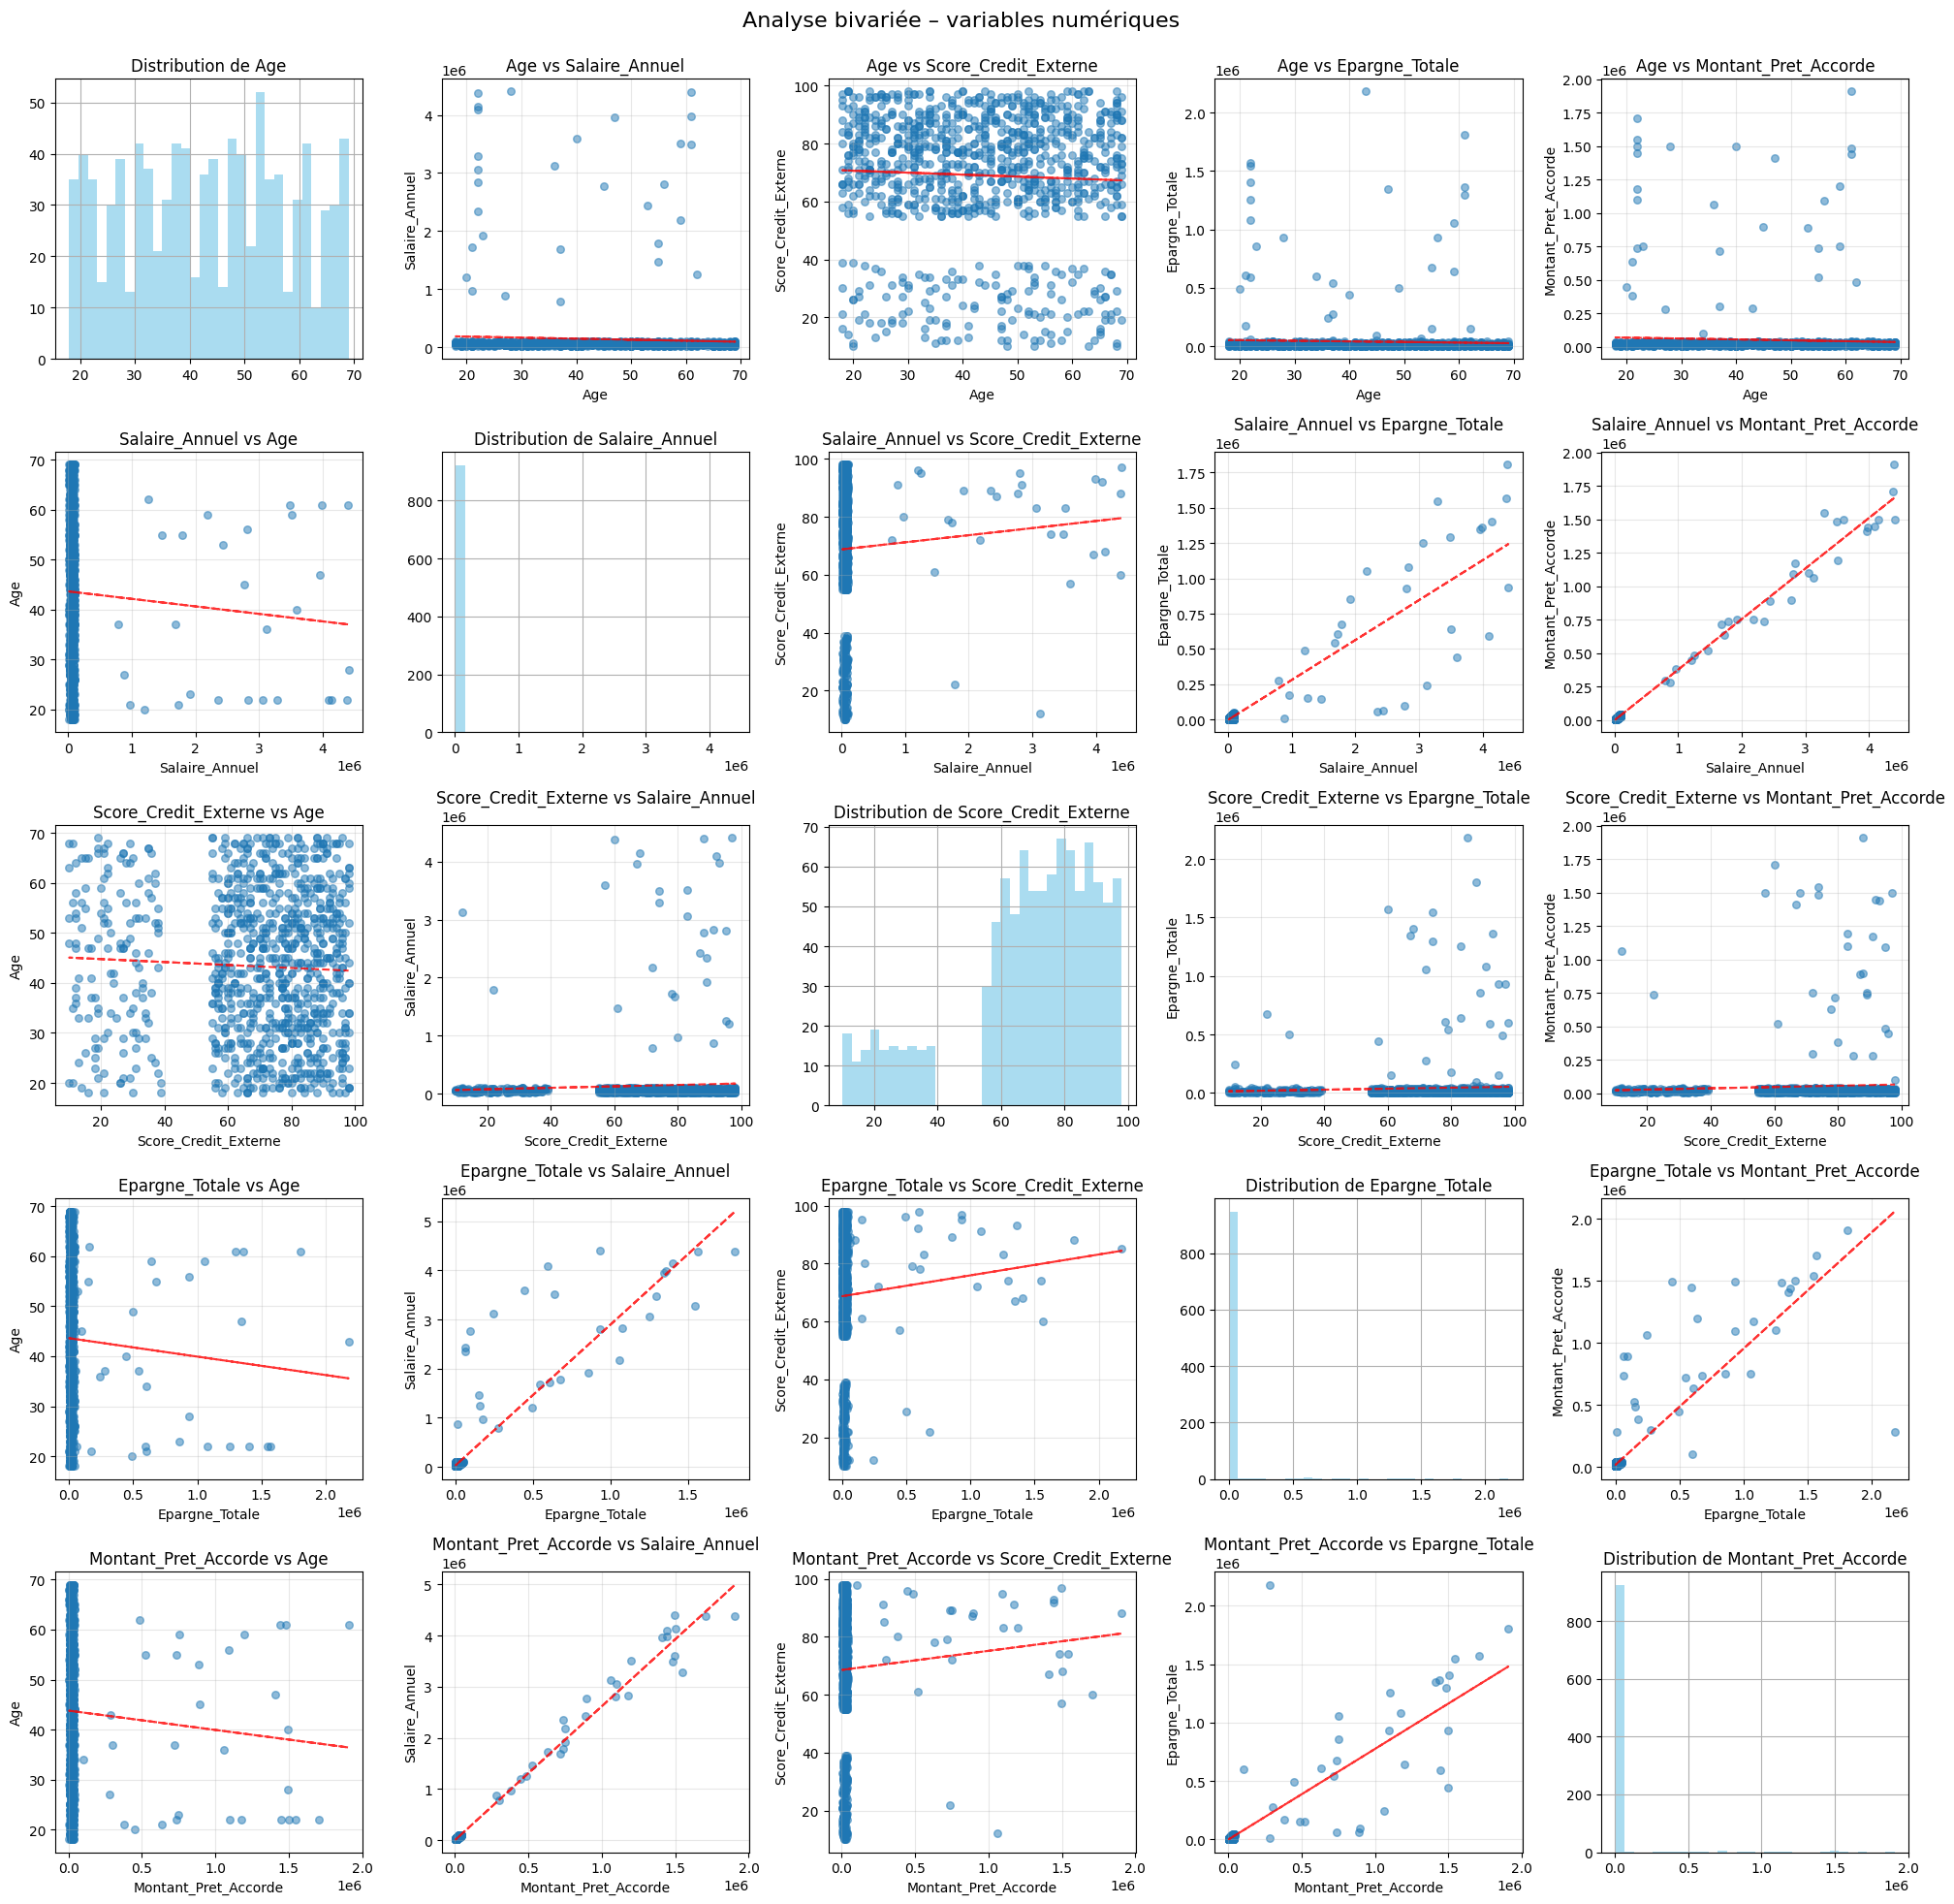

In [33]:
visualiser_bivariee_numerique_scatter(df, variables_numeriques)

### ANALYSE DES VISUALISATIONS BIVARIEES (Numérique vs Numérique)

Les nuages de points (scatter plots) nous permettent d'explorer visuellement les relations et les tendances entre chaque paire de variables numériques. La ligne en pointillé rouge représente une ligne de régression linéaire simple, suggérant une tendance générale.

**Observations générales :**
*   Les histogrammes sur la diagonale affichent la distribution univariée de chaque variable, confirmant les observations précédentes (asymétrie pour le salaire, l'épargne et le montant de prêt accordé, distribution plus uniforme pour l'âge).
*   La présence d'outliers, notamment pour `Salaire_Annuel`, `Epargne_Totale` et `Montant_Pret_Accorde`, est très visible dans de nombreux nuages de points. Ces valeurs extrêmes peuvent fortement influencer la pente des lignes de régression.

**Analyse des paires de variables :**

1.  **Age vs Salaire_Annuel :**
    *   Le nuage de points ne montre **pas de corrélation linéaire forte** évidente entre l'âge et le salaire annuel. La ligne de régression est relativement plate, suggérant qu'il n'y a pas de tendance claire à ce que le salaire augmente ou diminue significativement avec l'âge dans cet ensemble de données.
    *   La dispersion est grande, et quelques points à salaires très élevés sont présents à divers âges, ce qui indique que d'autres facteurs que l'âge sont probablement plus déterminants pour le salaire.

2.  **Age vs Score_Credit_Externe :**
    *   Aucune corrélation linéaire forte n'est non plus visible ici. Le `Score_Credit_Externe` semble varier indépendamment de l'âge.
    *   On observe une large dispersion des scores pour toutes les tranches d'âge, y compris les scores faibles détectés comme outliers précédemment.

3.  **Age vs Epargne_Totale :**
    *   Similaire aux observations avec `Salaire_Annuel`, il n'y a **pas de corrélation linéaire forte** entre l'âge et l'épargne totale.
    *   Les points d'épargne très élevés sont répartis sur différentes tranches d'âge, sans tendance nette.

4.  **Age vs Montant_Pret_Accorde :**
    *   Le nuage de points ne révèle **pas de corrélation linéaire significative** entre l'âge et le montant du prêt accordé. Les montants des prêts sont dispersés sur toutes les tranches d'âge, sans tendance claire à l'augmentation ou à la diminution avec l'âge.

5.  **Salaire_Annuel vs Score_Credit_Externe :**
    *   Une **légère tendance positive** pourrait être discernée, mais elle est très faible et obscurcie par la grande dispersion des données et la présence d'outliers de `Salaire_Annuel`.
    *   Il est difficile de conclure une relation linéaire claire sans une analyse plus approfondie ou la gestion des outliers.

6.  **Salaire_Annuel vs Epargne_Totale :**
    *   Nous observons une **corrélation la plus positive** . On peut voir une tendance générale où des salaires annuels plus élevés tendent à être associés à une épargne totale plus élevée.
    *   Cependant, la relation est loin d'être parfaite ; il y a beaucoup de dispersion, et les outliers de `Salaire_Annuel` et `Epargne_Totale` tirent fortement la ligne de régression vers le haut, ce qui pourrait exagérer la force de la relation pour la majorité des données.

7.  **Salaire_Annuel vs Montant_Pret_Accorde :**
    *   C'est la paire qui montre la **corrélation la plus positive** parmi celles observées initialement : les montants de prêts accordés ont tendance à augmenter avec le salaire annuel.
    *   Cependant, la relation est impactée par la grande dispersion et les outliers à salaires et montants de prêts très élevés. Ces points tirent la ligne de régression, potentiellement surestimant la force de la relation pour la majorité des données.

8.  **Score_Credit_Externe vs Epargne_Totale :**
    *   La corrélation entre ces deux variables semble être **très faible, voire inexistante**. La ligne de régression est presque plate.
    *   Cela suggère que la capacité d'épargne n'est pas directement et fortement liée au score de crédit externe dans cet ensemble de données.

9.  **Score_Credit_Externe vs Montant_Pret_Accorde :**
    *   Une **légère tendance positive** peut être perçue : un score de crédit externe plus élevé semble être associé à des montants de prêts accordés plus importants. Cela est également une attente logique dans le secteur bancaire.
    *   La dispersion est néanmoins significative, et la présence d'outliers de score de crédit faible n'empêche pas l'existence de montants de prêts variés.

10. **Epargne_Totale vs Montant_Pret_Accorde :**
    *   Il existe une **corrélation positive modérée** entre l'épargne totale et le montant du prêt accordé. Les individus ayant une épargne plus élevée tendent à recevoir des prêts plus importants. Cela suggère que l'épargne est un indicateur de stabilité financière et de capacité de remboursement.
    *   Comme pour le salaire, les outliers d'épargne très élevée influencent la pente de la ligne de régression.

**Conclusion de l'analyse bivariée numérique :**
L'analyse des nuages de points révèle des corrélations faibles à inexistantes pour la plupart des paires de variables numériques, à l'exception de relations positives entre :
*   `Salaire_Annuel` et `Epargne_Totale` (modérée à forte).
*   `Salaire_Annuel` et `Montant_Pret_Accorde` (modérée).
*   `Epargne_Totale` et `Montant_Pret_Accorde` (modérée).
*   Une légère tendance positive entre `Score_Credit_Externe` et `Montant_Pret_Accorde`.

La présence significative d'outliers dans `Salaire_Annuel`, `Epargne_Totale` et `Montant_Pret_Accorde` est un facteur important qui influence l'apparence des relations et la pente des lignes de régression. Pour des analyses plus précises, la gestion de ces outliers serait une étape cruciale.

#### NUMÉRIQUE vs CATÉGORIEL : COMPARAISON DES MOYENNES

In [34]:
def analyser_moyennes_par_categorie(
    df,
    variables_numeriques,
    variables_categorielles,
    exclude_cols=None
):
    """
    Analyse Numérique vs Catégoriel via comparaison des moyennes.
    """
    print("- NUMÉRIQUE vs CATÉGORIEL : COMPARAISON DES MOYENNES")
    print("=" * 50)

    if exclude_cols is None:
        exclude_cols = []

    for cat_var in variables_categorielles:
        print(f"\n📊 Analyse de '{cat_var}'")
        print("=" * 50)

        for num_var in variables_numeriques:
            if num_var not in exclude_cols:
                moyennes = (
                    df.groupby(cat_var, observed=False)[num_var] # Added observed=False here
                      .mean()
                      .sort_values(ascending=False)
                )

                print(f"\n\n Col {num_var.upper()} — Moyennes par {cat_var}:\n")
                # Convertir la série en DataFrame pour un affichage tabulaire
                moyennes_df = moyennes.reset_index()
                moyennes_df.columns = [cat_var, 'Moyenne']
                display(moyennes_df)

In [35]:
analyser_moyennes_par_categorie(
    df,
    variables_numeriques,
    variables_categorielles,
    exclude_cols=None
)

- NUMÉRIQUE vs CATÉGORIEL : COMPARAISON DES MOYENNES

📊 Analyse de 'Niveau_Etude'


 Col AGE — Moyennes par Niveau_Etude:



,Niveau_Etude,Moyenne
0,Licence,44.178138
1,Doctorat,43.713592
2,Master,42.984848
3,Bac,42.651452




 Col SALAIRE_ANNUEL — Moyennes par Niveau_Etude:



,Niveau_Etude,Moyenne
0,Master,158660.827411
1,Licence,135228.378049
2,Bac,121364.383333
3,Doctorat,116413.644550




 Col SCORE_CREDIT_EXTERNE — Moyennes par Niveau_Etude:



,Niveau_Etude,Moyenne
0,Doctorat,71.777251
1,Master,68.624390
2,Bac,68.225410
3,Licence,68.011765




 Col EPARGNE_TOTALE — Moyennes par Niveau_Etude:



,Niveau_Etude,Moyenne
0,Licence,48920.098814
1,Master,43875.058824
2,Bac,28111.549587
3,Doctorat,25519.726852




 Col MONTANT_PRET_ACCORDE — Moyennes par Niveau_Etude:



,Niveau_Etude,Moyenne
0,Master,58685.975000
1,Licence,52332.552000
2,Bac,45052.025000
3,Doctorat,43621.207729



📊 Analyse de 'Ville'


 Col AGE — Moyennes par Ville:



,Ville,Moyenne
0,Paris,44.039735
1,Lyon,43.361624
2,Marseille,43.050955




 Col SALAIRE_ANNUEL — Moyennes par Ville:



,Ville,Moyenne
0,Paris,173015.319865
1,Lyon,151287.310469
2,Marseille,100577.232258




 Col SCORE_CREDIT_EXTERNE — Moyennes par Ville:



,Ville,Moyenne
0,Marseille,69.226415
1,Paris,69.094463
2,Lyon,68.189474




 Col EPARGNE_TOTALE — Moyennes par Ville:



,Ville,Moyenne
0,Paris,47559.647059
1,Lyon,36242.150877
2,Marseille,36120.783019




 Col MONTANT_PRET_ACCORDE — Moyennes par Ville:



,Ville,Moyenne
0,Paris,66370.333333
1,Lyon,55188.187279
2,Marseille,38990.106796



📊 Analyse de 'Defaut_Paiement'


 Col AGE — Moyennes par Defaut_Paiement:



,Defaut_Paiement,Moyenne
0,Oui,43.787037
1,Non,43.304294




 Col SALAIRE_ANNUEL — Moyennes par Defaut_Paiement:



,Defaut_Paiement,Moyenne
0,Non,144206.436654
1,Oui,96550.733945




 Col SCORE_CREDIT_EXTERNE — Moyennes par Defaut_Paiement:



,Defaut_Paiement,Moyenne
0,Non,71.540865
1,Oui,51.236842




 Col EPARGNE_TOTALE — Moyennes par Defaut_Paiement:



,Defaut_Paiement,Moyenne
0,Non,41481.882353
1,Oui,24385.947368




 Col MONTANT_PRET_ACCORDE — Moyennes par Defaut_Paiement:



,Defaut_Paiement,Moyenne
0,Non,54967.618405
1,Oui,35410.409091


#### VISUALISATION : BOXPLOTS PAR CATÉGORIE

In [36]:
def visualiser_boxplots_categoriels(df, num_col, cat_cols, save_path=None):
    """
    Analyse bivariée : Numérique vs Plusieurs Catégorielles via Boxplots.
    """
    print(f"\n- ANALYSE DE {num_col} PAR CATÉGORIES")
    print("-" * 80)

    # Configuration dynamique de la grille
    n_cols = len(cat_cols)
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6), sharey=True)

    # Gestion du cas où il n'y a qu'une seule colonne catégorielle
    if n_cols == 1:
        axes = [axes]

    for ax, cat_col in zip(axes, cat_cols):
        if cat_col in df.columns and num_col in df.columns:
            # Utilisation de Seaborn pour un rendu plus pro
            sns.boxplot(data=df, x=cat_col, y=num_col, ax=ax, palette="Set2", hue=cat_col, legend=False)

            ax.set_title(f"{num_col} par {cat_col}", fontweight="bold")
            ax.set_xlabel(cat_col)
            ax.set_ylabel(num_col if ax == axes[0] else "") # Ne garde le label Y que sur le premier graph
            ax.tick_params(axis="x", rotation=45)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    # Suppression du titre automatique redondant de Pandas
    fig.suptitle(f"Comparaisons de {num_col}", fontsize=16, fontweight="bold", y=1.05)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f" Boxplots sauvegardés : {save_path}")

    plt.show()


- ANALYSE DE Age PAR CATÉGORIES
--------------------------------------------------------------------------------
 Boxplots sauvegardés : /content/drive/MyDrive/projet-datascience/outputs/bivariee_categorielle_Age.png


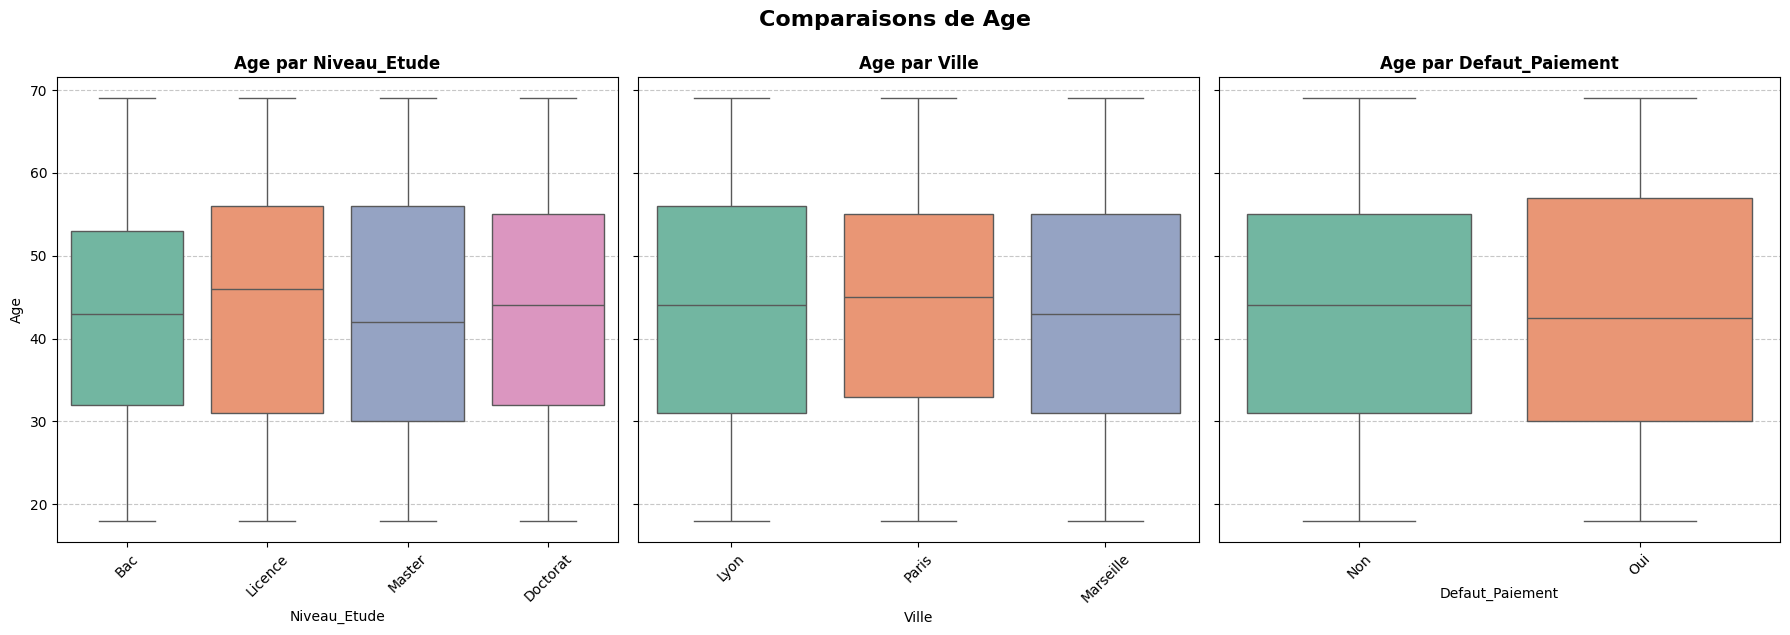


- ANALYSE DE Salaire_Annuel PAR CATÉGORIES
--------------------------------------------------------------------------------
 Boxplots sauvegardés : /content/drive/MyDrive/projet-datascience/outputs/bivariee_categorielle_Salaire_Annuel.png


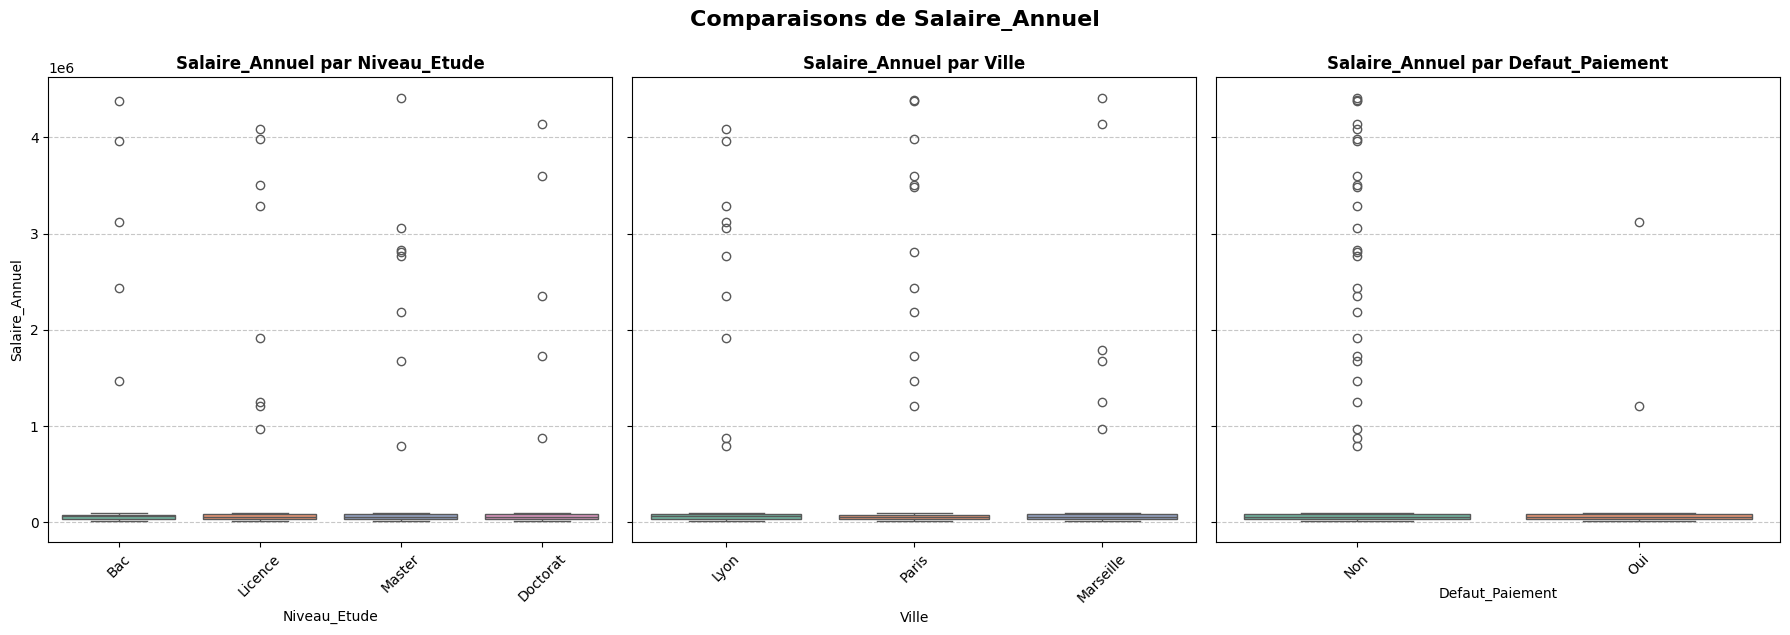


- ANALYSE DE Score_Credit_Externe PAR CATÉGORIES
--------------------------------------------------------------------------------
 Boxplots sauvegardés : /content/drive/MyDrive/projet-datascience/outputs/bivariee_categorielle_Score_Credit_Externe.png


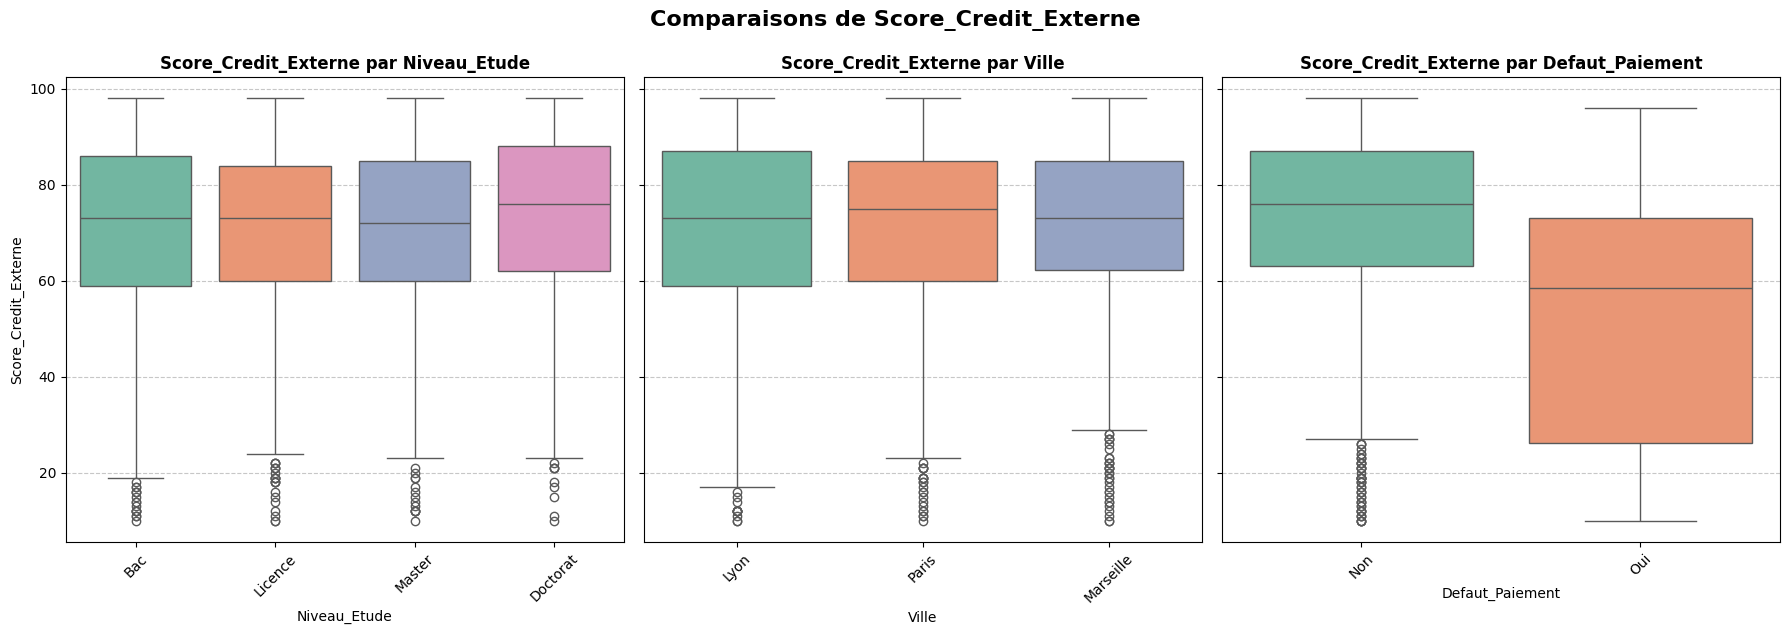


- ANALYSE DE Epargne_Totale PAR CATÉGORIES
--------------------------------------------------------------------------------
 Boxplots sauvegardés : /content/drive/MyDrive/projet-datascience/outputs/bivariee_categorielle_Epargne_Totale.png


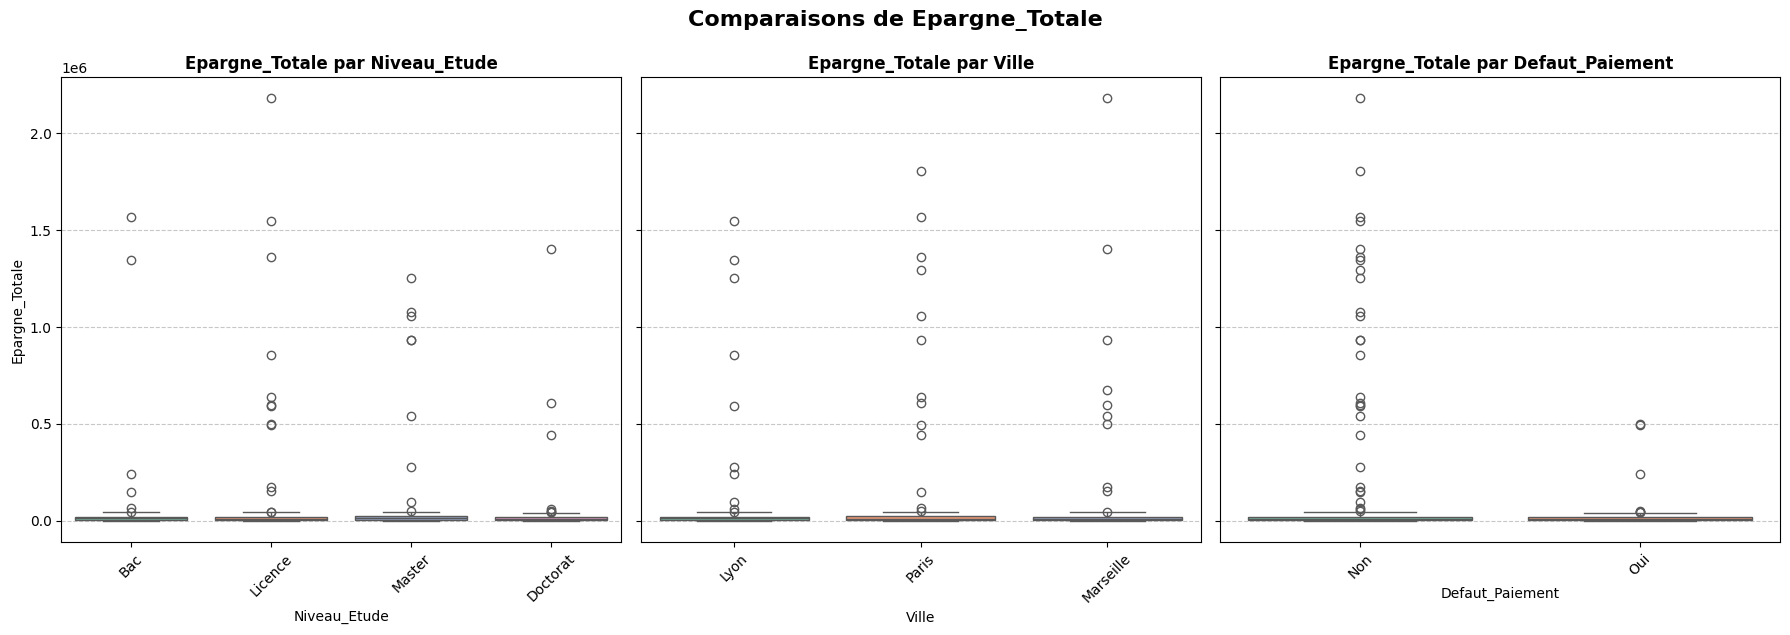


- ANALYSE DE Montant_Pret_Accorde PAR CATÉGORIES
--------------------------------------------------------------------------------
 Boxplots sauvegardés : /content/drive/MyDrive/projet-datascience/outputs/bivariee_categorielle_Montant_Pret_Accorde.png


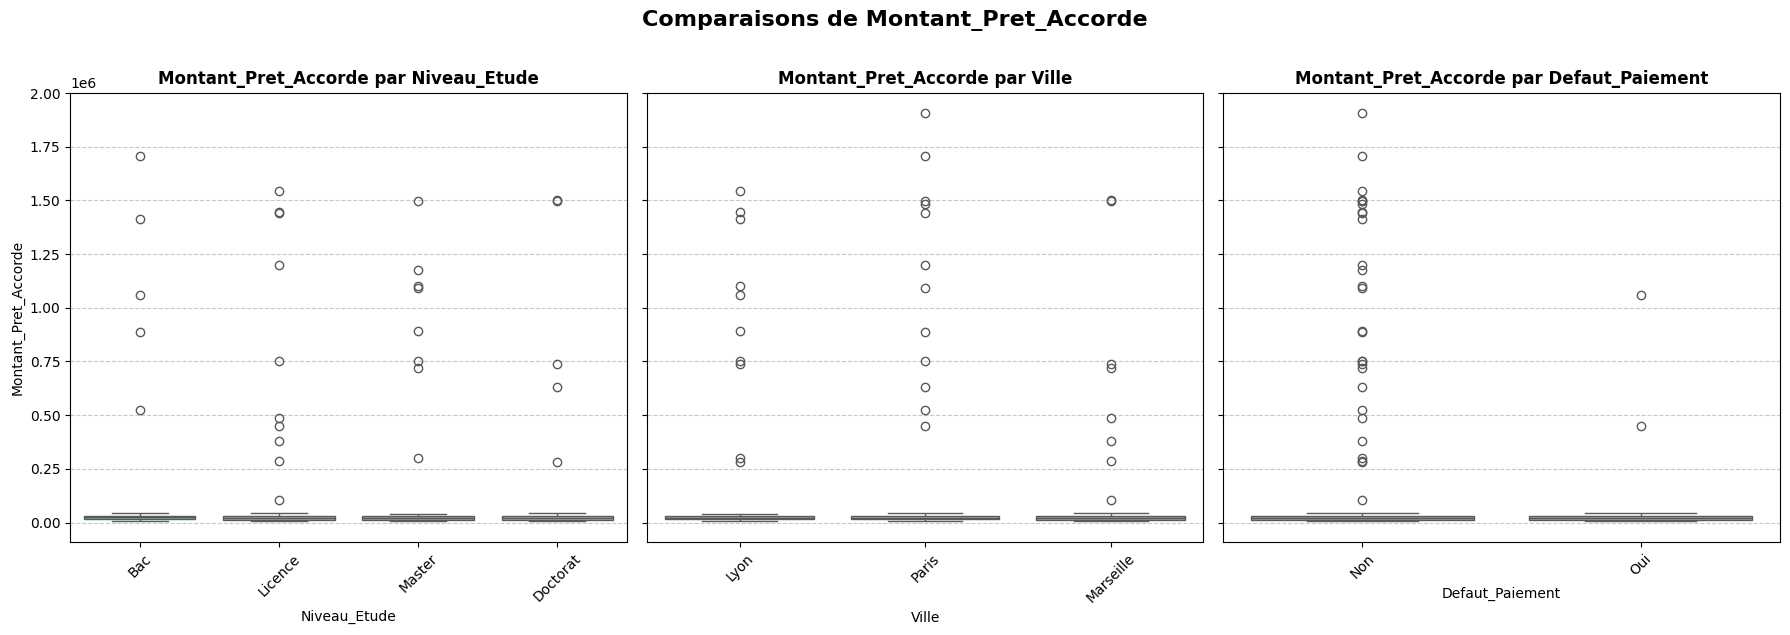

In [37]:
for num_col_name in variables_numeriques:
    visualiser_boxplots_categoriels(
        df,
        num_col_name,
        variables_categorielles,
        save_path=f"{path}bivariee_categorielle_{num_col_name}.png"
    )

### ANALYSE DES VISUALISATIONS DES BOXPLOTS PAR CATEGORIE

Ces boxplots nous permettent de visualiser la distribution de chaque variable numérique (`Age`, `Salaire_Annuel`, `Score_Credit_Externe`, `Epargne_Totale`) pour chaque catégorie des variables catégorielles (`Niveau_Etude`, `Ville`). Cela aide à identifier si le niveau d'étude ou la ville d'origine ont une influence sur les caractéristiques numériques.

**1. Analyse de l'Age par Niveau_Etude, Ville et  Defaut_Paiement :**
*   **Niveau_Etude :** On observe une progression logique de l'âge médian avec le niveau d'étude. Les individus ayant un Doctorat tendent à être plus âgés que ceux ayant un Bac, ce qui est attendu compte tenu du parcours académique. La dispersion (taille de la boîte) semble également varier entre les catégories.
*   **Ville :** L'âge ne semble pas montrer de différences majeures ou de tendances marquées entre les différentes villes. Les distributions d'âge sont relativement similaires d'une ville à l'autre.
*   **Defaut_Paiement** : La distribution de l'âge est assez similaire entre les groupes 'Non' et 'Oui', avec des médianes proches. Cela suggère que l'âge seul n'est pas un facteur fortement discriminant pour le défaut de paiement, bien que des différences subtiles dans la dispersion ou la présence d'outliers puissent exister.

**2. Analyse du Salaire_Annuel par Niveau_Etude, Ville et Defaut_Paiement :**
*   **Niveau_Etude :** Le salaire annuel médian augmente généralement avec le niveau d'étude. Les Doctorats et Masters affichent des salaires médians plus élevés que les Licences et Bacs. La dispersion des salaires est également plus grande pour les niveaux d'étude supérieurs, et on observe de nombreux outliers (salaires très élevés) particulièrement pour les Masters et Doctorats.
*   **Ville :** Des différences de salaire médian peuvent être observées entre les villes, suggérant des dynamiques économiques ou des coûts de vie différents. Par exemple, une ville pourrait avoir un salaire médian légèrement plus élevé, bien que la présence d'outliers extrêmes puisse influencer l'impression visuelle de la moyenne.
*   **Defaut_Paiement** : Les individus qui sont en défaut de paiement ('Oui') ont tendance à avoir un salaire annuel médian significativement plus bas que ceux qui ne le sont pas ('Non'). Cela confirme que le salaire est un indicateur clé de la capacité de remboursement.

**3. Analyse du Score_Credit_Externe par Niveau_Etude, Ville et Defaut_Paiement :**
*   **Niveau_Etude :** Le score de crédit externe semble varier, mais pas toujours de manière strictement croissante ou décroissante avec le niveau d'étude. Certaines catégories peuvent présenter une médiane légèrement plus élevée ou une dispersion différente. On note la présence d'outliers bas dans plusieurs catégories.
*   **Ville :** Des variations légères ou modérées du score de crédit médian peuvent exister entre les villes. Il n'y a pas de schéma universellement évident, mais cela peut révéler des différences de profil de risque par localisation.
*   **Defaut_Paiement** : Sans surprise, les clients en défaut de paiement ('Oui') présentent un score de crédit externe médian nettement inférieur à celui des clients qui ne sont pas en défaut ('Non'). Le boxplot du groupe 'Oui' est plus bas et peut montrer une plus grande concentration de scores très faibles.

**4. Analyse de l'Epargne_Totale par Niveau_Etude, Ville et Defaut_Paiement :**
*   **Niveau_Etude :** Similaire au salaire annuel, l'épargne totale médiane tend à augmenter avec le niveau d'étude. Les Masters et Doctorats ont généralement une épargne médiane plus élevée. Une forte présence d'outliers élevés est visible pour toutes les catégories de niveau d'étude, indiquant des individus avec des montants d'épargne exceptionnellement importants.
*   **Ville :** L'épargne totale médiane peut différer entre les villes. Encore une fois, la présence d'outliers élevés est une caractéristique dominante dans toutes les villes, indiquant que la richesse est concentrée chez quelques individus, quelle que soit leur localisation.
*   **Defaut_Paiement** : Les clients en défaut de paiement ('Oui') ont généralement une épargne totale médiane beaucoup plus faible que les clients sans défaut ('Non'). Cela renforce l'idée que l'épargne est un facteur de stabilité financière et un indicateur de risque de défaut.

**5. Analyse du Montant_Pret_Accorde par Niveau_Etude, Ville et Defaut_Paiement :**

*   **Niveau_Etude** : Le montant de prêt accordé a tendance à être plus élevé pour les niveaux d'étude supérieurs (Master, Doctorat), ce qui peut être lié à des salaires et une stabilité financière plus importants. La dispersion est également significative avec des outliers élevés dans ces catégories.

*   **Ville** : Il peut y avoir des variations dans les montants de prêts accordés entre les villes, potentiellement dues à des différences de coût de la vie ou de politiques bancaires locales.

*   **Defaut_Paiement** : La relation entre le Montant_Pret_Accorde et Defaut_Paiement est cruciale. Les boxplots peuvent révéler que les clients en défaut ('Oui') ont des montants de prêts potentiellement plus faibles en médiane (reflet d'une capacité d'emprunt limitée) ou, au contraire, une plus grande variabilité, y compris des prêts élevés qu'ils n'ont pas pu rembourser.


**Conclusion Générale** :
- Ces boxplots révèlent que le Niveau_Etude a une influence notable sur des variables comme l'âge, le salaire annuel, l'épargne totale et le montant de prêt accordé, avec une tendance à l'augmentation de ces métriques avec un niveau d'éducation plus élevé.
- La Ville a un impact moins systématique mais peut montrer des disparités.
- Le Defaut_Paiement est fortement corrélé négativement avec Salaire_Annuel, Score_Credit_Externe et Epargne_Totale, soulignant l'importance de ces variables comme indicateurs de risque. La persistance des outliers dans Salaire_Annuel, Epargne_Totale et Montant_Pret_Accorde à travers toutes les catégories souligne leur nature extrême et leur importance pour toute analyse future.

###

#### ANALYSE DE CORRÉLATION

In [38]:
def analyser_correlation(df, variables_numeriques, method='pearson', threshold=0.7, save_path=None):
    """
    Orchestre l'analyse : calcul, affichage et détection des seuils.
    """
    # 1. Calcul de la matrice (Pearson ou Spearman)
    corr_matrix = df[variables_numeriques].corr(method=method)

    # 2. Appel de la visualisation
    plot_correlation_heatmap(corr_matrix, method, save_path)

    # 3. Appel de la détection automatique
    detecter_correlations_fortes(corr_matrix, threshold)

    return corr_matrix

In [39]:
def plot_correlation_heatmap(corr_matrix, method, save_path=None):
    plt.figure(figsize=(12, 10))

    # Masque pour ne pas afficher le triangle supérieur (évite la répétition)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
                cmap='coolwarm', center=0, square=True, linewidths=1)

    plt.title(f'MATRICE DE CORRÉLATION ({method.upper()})', fontsize=15, fontweight='bold')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [40]:
def detecter_correlations_fortes(corr_matrix, threshold=0.7):
    # On transforme la matrice en liste de paires
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    pairs = upper_tri.stack().reset_index()
    pairs.columns = ['Var1', 'Var2', 'Corr']

    fortes = pairs[pairs['Corr'].abs() > threshold]

    if not fortes.empty:
        print(f"\n⚠️ ALERTES ({threshold}) :")
        for _, row in fortes.iterrows():
            print(f"   • {row['Var1']} ↔ {row['Var2']} : {row['Corr']:.3f} \n")
    else:
        print(f"\n Aucune corrélation > {threshold}")

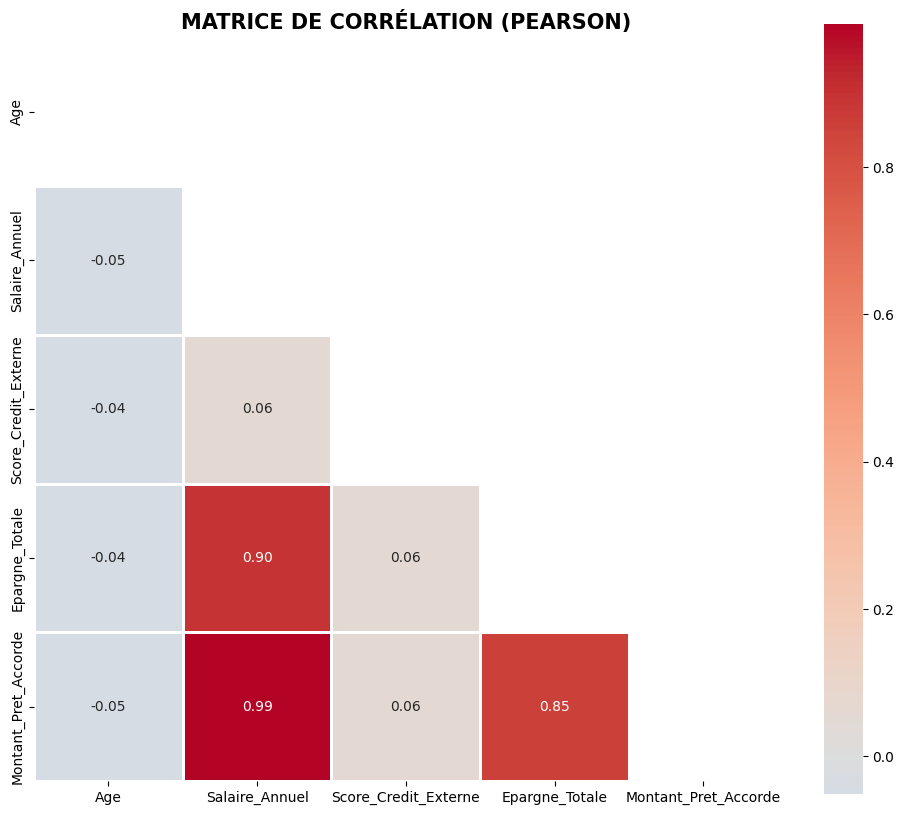


⚠️ ALERTES (0.7) :
   • Salaire_Annuel ↔ Epargne_Totale : 0.900 

   • Salaire_Annuel ↔ Montant_Pret_Accorde : 0.994 

   • Epargne_Totale ↔ Montant_Pret_Accorde : 0.854 



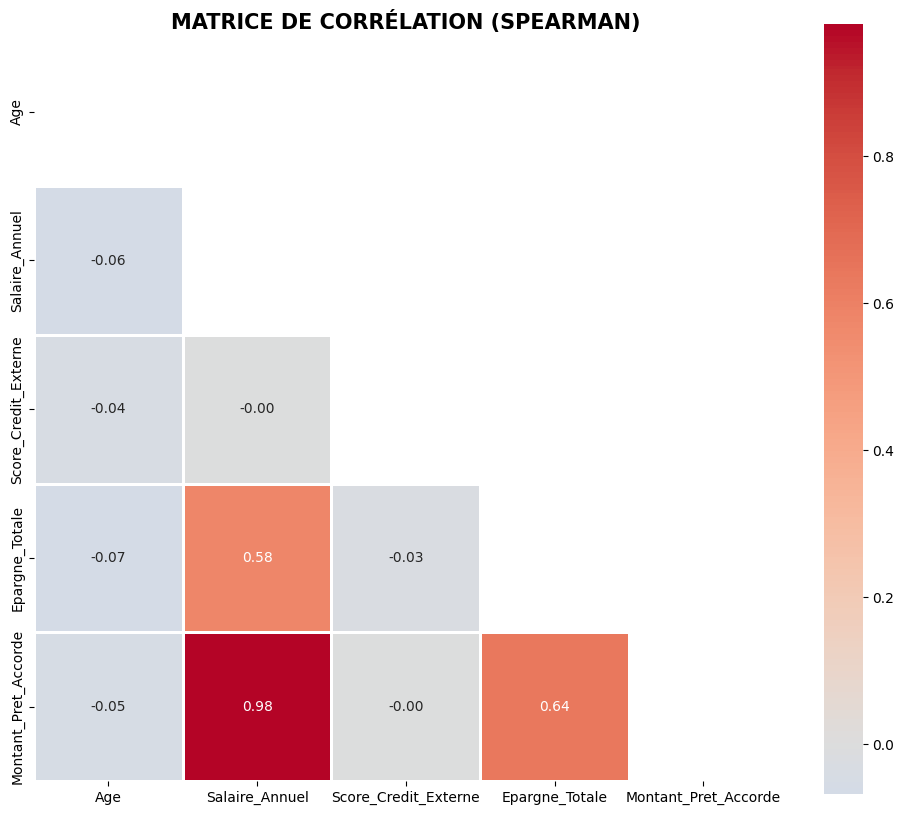


⚠️ ALERTES (0.7) :
   • Salaire_Annuel ↔ Montant_Pret_Accorde : 0.980 



In [41]:
# Pour la relation linéaire classique (sensible aux outliers)
corr_p = analyser_correlation(df, variables_numeriques, method='pearson', save_path=f"{path}pearson_correlation_heatmap.png")

# Pour une relation plus robuste (basée sur les rangs, idéale pour ton salaire)
corr_s = analyser_correlation(df, variables_numeriques, method='spearman', save_path=f"{path}spearman_correlation_heatmap.png")

### ANALYSE DES MATRICES DE CORRELATION (Pearson & Spearman)

---

#### Corrélation de Pearson (relation linéaire)

La corrélation de Pearson mesure la force et la direction d’une relation linéaire entre deux variables.  
Elle est sensible aux valeurs extrêmes (outliers) et suppose implicitement des relations linéaires.

##### Observations principales

- **`Salaire_Annuel` ↔ `Montant_Pret_Accorde` : corrélation extrêmement forte (r ≈ 0.99)**  
  Le montant du prêt accordé dépend presque linéairement du salaire annuel.  
  Cela suggère une règle de décision très fortement basée sur le revenu.

- **`Salaire_Annuel` ↔ `Epargne_Totale` : corrélation très forte (r ≈ 0.90)**  
  Les individus avec un salaire plus élevé ont tendance à avoir une épargne totale plus importante, avec une relation quasi linéaire.

- **`Epargne_Totale` ↔ `Montant_Pret_Accorde` : corrélation forte (r ≈ 0.85)**  
  L’épargne semble également jouer un rôle important dans le montant du prêt accordé.

- **Faibles corrélations pour `Age` et `Score_Credit_Externe`**  
  Ces variables présentent des corrélations proches de zéro avec les autres variables, indiquant l’absence de relation linéaire marquée.

Il convient de noter que les corrélations élevées observées avec Pearson peuvent être amplifiées par la présence d’outliers, notamment sur les variables financières (salaire, épargne, montant du prêt).

---

#### Corrélation de Spearman (relation monotone)

La corrélation de Spearman mesure la relation monotone entre les rangs des variables.  
Elle est plus robuste aux outliers et adaptée aux distributions non normales.

##### Observations principales

- **`Salaire_Annuel` ↔ `Montant_Pret_Accorde` : corrélation très forte (ρ ≈ 0.98)**  
  Même après réduction de l’impact des valeurs extrêmes, le salaire reste le facteur dominant dans l’octroi du prêt.

- **`Salaire_Annuel` ↔ `Epargne_Totale` : corrélation modérée à forte (ρ ≈ 0.58)**  
  La relation reste positive mais est nettement moins forte qu’avec Pearson, ce qui indique que la relation est monotone mais pas strictement linéaire pour l’ensemble des individus.

- **`Epargne_Totale` ↔ `Montant_Pret_Accorde` : corrélation modérée (ρ ≈ 0.64)**  
  L’épargne contribue au montant du prêt, mais de façon moins systématique que le salaire.

- **`Age` et `Score_Credit_Externe`**  
  Les corrélations restent faibles avec toutes les autres variables, confirmant l’absence de relation monotone significative.

---

#### Interprétation croisée Pearson vs Spearman

Les écarts importants entre Pearson et Spearman, notamment pour :

- `Salaire_Annuel` ↔ `Epargne_Totale`
- `Epargne_Totale` ↔ `Montant_Pret_Accorde`

indiquent :

- la présence de distributions asymétriques
- un impact notable des valeurs extrêmes
- une relation globale réelle mais moins rigide que ne le suggère Pearson

La corrélation de Spearman fournit ici une vision plus prudente et réaliste des relations structurelles entre variables.

---

#### Conclusion générale

Le salaire annuel apparaît comme la variable centrale du jeu de données :

- fortement corrélé au montant du prêt accordé
- fortement lié à l’épargne totale

Le montant du prêt accordé dépend principalement du salaire, puis secondairement de l’épargne.

L’âge et le score de crédit externe n’exercent pas d’influence directe forte dans ce jeu de données, du moins pas sous forme de relations linéaires ou monotones simples.

Ces résultats suggèrent un risque de colinéarité élevé entre :

- `Salaire_Annuel`
- `Epargne_Totale`
- `Montant_Pret_Accorde`

Cette situation devra être prise en compte lors de la phase de modélisation (sélection de variables, régularisation, modèles non linéaires, etc.).


## PHASE 1 DE FEATURE ENGINEERING SUR BASE DE LA MATRICE DE CORRELATION

### PRÉPARATION DES DEUX DATASETS

In [42]:

cleaning_transformer = DataCleaningTransformer()

y_classif_df = df[['Defaut_Paiement']].copy()
y_reg_df = df[['Montant_Pret_Accorde']].copy()

#Nettoyage avec le transformer
y_classif_clean_df = cleaning_transformer.transform(y_classif_df)
y_reg_clean_df = cleaning_transformer.transform(y_reg_df)

"""
Pipeline 1 :CLASSIFICATION (Defaut_Paiement)
On drop le montant ( data leakage)
"""

X = df.drop(columns=['Defaut_Paiement', 'Montant_Pret_Accorde'])

# 4. Reconvertir en Series + mapping
y_classif = y_classif_clean_df['Defaut_Paiement'].map({'Non': 0, 'Oui': 1})
y_reg = y_reg_clean_df['Montant_Pret_Accorde']


"""
Pipeline 2 : RÉGRESSION (Montant_Pret_Accorde)
 On drop l'épargne (colinéarité) et le défaut (donnée future)
"""

y_reg = df['Montant_Pret_Accorde']

# NB: Vu que ce sont les mêmes colonnes dans les variables X_train, X_reg, on garde juste X

In [43]:
# On crée le ratio qui remplace l'information "Epargne" brute pour nos visualisations
df['Ratio_Epargne_Salaire'] = df['Epargne_Totale'] / df['Salaire_Annuel'].replace(0, np.nan)

# Convertir les infinis (générés par division par zéro) en NaN pour qu'ils
# soient traités par l'imputation
df.replace([np.inf, -np.inf], np.nan, inplace=True)

if 'Ratio_Epargne' not in variables_numeriques:
    variables_numeriques.append('Ratio_Epargne')

### Suppression de **Epargne_Totale**
- **Cible concernée :** `Défaut_Paiement` et Montant_Pret_Accorde  
- **Justification statistique :** Corrélation très forte avec `Salaire` (Pearson ≈ 0.90), ce qui introduit de la redondance et un risque de multicolinéarité.  
- **Justification métier :** L’information d’épargne est mieux représentée via `Ratio_Epargne_Salaire`, qui capture la capacité réelle d’épargne indépendamment du niveau absolu de revenu.

---

### Suppression de **Montant_Pret_Accorde** (pour la prédiction du défaut)
- **Cible concernée :** `Défaut_Paiement`  
- **Justification statistique :** Corrélation quasi parfaite avec `Salaire` (Pearson ≈ 0.99), ce qui en fait un proxy du revenu.  
- **Justification métier :** Risque de **target leakage**. Le montant final du prêt est une décision prise après l’analyse du dossier. Il ne doit donc pas être utilisé pour prédire si le client fera défaut.

---

### Suppression de **Defaut_Paiement** (pour la prédiction du montant accordé)
- **Cible concernée :** `Montant_Pret_Accorde`

> Ajouter une citation


- **Justification statistique :** Corrélation faible mais existante avec certaines variables financières.  
- **Justification métier :** Risque d’**anachronisme**. Le défaut de paiement est un événement qui survient après l’octroi du prêt. Il ne peut pas être connu au moment où le montant du prêt est d


### SPLIT DES DONNÉES EN TRAIN ET TEST

In [44]:
from sklearn.model_selection import train_test_split

# Nettoyage des NaNs (comme dans ton code actuel)
mask = y_classif.notna()
X_clean = X.loc[mask]
y_c_clean = y_classif.loc[mask]
y_r_clean = y_reg.loc[mask]

# PREMIER SPLIT : On isole le Test Set final (20%)
# Ce set ne servira pas à l'entraînement ni aux réglages (seuil/calibration)
X_temp, X_test, y_temp_c, y_test_classif, y_temp_r, y_test_reg = train_test_split(
    X_clean, y_c_clean, y_r_clean,
    test_size=0.20,
    random_state=42,
    stratify=y_c_clean
)

"""
DEUXIÈME SPLIT : On divise le reste en Train (60%) et Validation (20%)
X_train : Pour apprendre les poids du modèle
X_val   : Pour calibrer et choisir le SEUIL
"""
X_train, X_val, y_train_classif, y_val_classif, y_train_reg, y_val_reg = train_test_split(
    X_temp, y_temp_c, y_temp_r,
    test_size=0.25, # 0.25 * 0.80 = 20% du total
    random_state=42,
    stratify=y_temp_c
)

print(f" Analyse du Triple Split :")
print(f" - Train (Apprentissage) : {X_train.shape[0]} samples")
print(f" - Val (Seuil/Calibration) : {X_val.shape[0]} samples")
print(f" - Test (Audit Final) : {X_test.shape[0]} samples")

 Analyse du Triple Split :
 - Train (Apprentissage) : 582 samples
 - Val (Seuil/Calibration) : 194 samples
 - Test (Audit Final) : 194 samples


**Note technique** : Stratification pour une Régression Pure
Dans ce projet, nous stratifions sur la variable Defaut_Paiement car elle est critique et déséquilibrée. Cependant, si notre seul objectif était la régression (prédire le montant du prêt), nous ne pourrions pas utiliser la stratification classique sur une variable continue.

Pour garantir que notre set de Test est un miroir fidèle du set de Train (avec la même proportion de petits et de grands prêts), nous devrions utiliser la technique du Binning.

Voici comment nous procéderions techniquement :

```python
# --- TECHNIQUE ALTERNATIVE : STRATIFICATION PAR QUANTILE (Régression seule) ---

1. Création de tranches (bins) basées sur les quintiles du montant du prêt
Cela divise les montants en 5 groupes de taille égale (ex: Très bas, Bas, Moyen, Haut, Très haut)

y_reg_bins = pd.qcut(df['Montant_Pret_Accorde'], q=5, labels=False)

2. Utilisation de ces tranches pour le split
# Cela garantit que chaque tranche de montant est représentée à 30% dans le Train et le Test
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg,
    y_reg,
    test_size=0.3,
    random_state=42,
    stratify=y_reg_bins # On stratifie sur les tranches artificielles
)
```
Résultat : Le modèle est évalué sur toutes les gammes de prix, évitant ainsi que le hasard ne place tous les "gros prêts" uniquement dans le set de test.

## TRAITEMENT DES OUTLIERS

### Stratégie de Traitement des Outliers

Suite à l'analyse approfondie des distributions et à la détection des outliers via les boxplots, nous avons constaté la présence de valeurs extrêmes dans plusieurs variables numériques telles que `Salaire_Annuel`, `Score_Credit_Externe` et `Epargne_Totale`.

**Notre stratégie est la suivante :**

Nous avons choisi de **ne pas supprimer ces outliers** pour le moment. La raison principale est que ces valeurs, bien qu'extrêmes, sont considérées comme de **véritables données** et non comme des erreurs de saisie. Les supprimer entraînerait une **perte d'informations précieuses** sur des segments spécifiques de notre clientèle (par exemple, des clients à très hauts revenus ou à faible score de crédit).

En effet, dans un contexte bancaire, ces valeurs extrêmes peuvent être très pertinentes pour comprendre les comportements financiers et sont souvent des caractéristiques importantes des clients.

Le traitement de l'impact de ces outliers sera principalement géré lors de l'étape de **mise à l'échelle (scaling)** des données. Des techniques de scaling robustes, comme le `RobustScaler`, ou des transformations (comme le logarithme pour les distributions très asymétriques) peuvent être utilisées pour atténuer l'influence disproportionnée des outliers sans avoir à les supprimer, ce qui permet de conserver toute l'information du dataset pour la modélisation future.

## **PREPROCESSING DE NOS DONNÉES**

In [45]:
config_ordinale = {'Niveau_Etude': ['bac', 'licence', 'master', 'doctorat']}

In [133]:
feature_eng_transformer = FeatureEngineeringTransformer()
imputer_transformer = SmartImputerTransformer(dict_ordinals=config_ordinale)
encoding_transformer = CustomEncodingTransformer()
scaling_transformer = MultiStrategyScaler()

# ÉTAPE 1 : Cleaning
X_train_clean = cleaning_transformer.fit_transform(X_train)
X_val_clean = cleaning_transformer.transform(X_val)
X_test_clean = cleaning_transformer.transform(X_test)


# ÉTAPE 2 : Feature Engineering
X_train_eng = feature_eng_transformer.fit_transform(X_train_clean)
X_val_eng = feature_eng_transformer.transform(X_val_clean)
X_test_eng = feature_eng_transformer.transform(X_test_clean)

# ÉTAPE 3 : Imputation
imputer_transformer.fit(X_train_eng)
X_train_imputed = imputer_transformer.transform(X_train_eng)
X_val_imputed = imputer_transformer.transform(X_val_eng)
X_test_imputed = imputer_transformer.transform(X_test_eng)


# ÉTAPE 4 : Encoding
encoding_transformer.fit(X_train_imputed)
X_train_encoded = encoding_transformer.transform(X_train_imputed)
X_val_encoded = encoding_transformer.transform(X_val_imputed)
X_test_encoded = encoding_transformer.transform(X_test_imputed)

# ÉTAPE 5 : Scaling
scaling_transformer.fit(X_train_encoded)
X_train_transformed = scaling_transformer.transform(X_train_encoded)
X_val_transformed = scaling_transformer.transform(X_val_encoded)
X_test_transformed = scaling_transformer.transform(X_test_encoded)

In [132]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.pipeline')

# ==============================================================================
# AFFICHAGE DES DONNÉES
# ==============================================================================

print(" Vérification du fonctoonnement du pipeline...")

"""
- X_train, X_val, X_test
- y_train_classif, y_val_classif, y_test_classif
"""

print("\n Transformation réussie !")
print(f"\n Dimensions finales :")
print(f"  - X_train : {X_train_transformed.shape}")
print(f"  - X_val   : {X_val_transformed.shape}")
print(f"  - X_test  : {X_test_transformed.shape}")

print(f"\n Colonnes finales ({len(X_train_transformed.columns)}) :")
print(X_train_transformed.columns.tolist())

print(f"\n Vérification des valeurs manquantes :")
print(f"  - Train : {X_train_transformed.isnull().sum().sum()} NaN")
print(f"  - Val   : {X_val_transformed.isnull().sum().sum()} NaN")
print(f"  - Test  : {X_test_transformed.isnull().sum().sum()} NaN")

print("\n Aperçu des données transformées (Train) :")
display(X_train_transformed.head())

 Vérification du fonctoonnement du pipeline...

 Transformation réussie !

 Dimensions finales :
  - X_train : (582, 8)
  - X_val   : (194, 8)
  - X_test  : (194, 8)

 Colonnes finales (8) :
['Age', 'Salaire_Annuel', 'Score_Credit_Externe', 'Ratio_Epargne_Salaire', 'Niveau_Etude_encoded', 'Ville_lyon', 'Ville_marseille', 'Ville_paris']

 Vérification des valeurs manquantes :
  - Train : 0 NaN
  - Val   : 0 NaN
  - Test  : 0 NaN

 Aperçu des données transformées (Train) :


,Age,Salaire_Annuel,Score_Credit_Externe,Ratio_Epargne_Salaire,Niveau_Etude_encoded,Ville_lyon,Ville_marseille,Ville_paris
862,-1.409132,-1.025243,-1.72,1.546119,1.0,0.0,1.0,0.0
62,1.559726,0.469307,-2.40,-0.871458,2.0,0.0,1.0,0.0
551,1.206291,-0.167124,-1.48,0.050071,1.0,1.0,0.0,0.0
708,-0.207451,-1.422490,0.12,-0.851651,1.0,0.0,0.0,1.0
750,-1.762568,-1.506505,0.92,0.903333,3.0,0.0,0.0,1.0


In [48]:
def calculer_ratio_perte(df, col, label_inconnu='Inconnu'):
    """Calcule le % de lignes basculées dans la catégorie 'Inconnu'."""
    ratio = (df[col] == label_inconnu).sum() / len(df) * 100
    print(f" Audit '{col}' : {ratio:.2f}% dans '{label_inconnu}'")

    # Indicateur industriel de performance
    status = " Optimal" if 5 <= ratio <= 20 else " Hors intervalle [5-20%]"
    print(f"   Statut : {status}")
    return ratio

In [49]:
def sauvegarder_dataset(df, nom_fichier="dataset_final_nettoye.csv"):
    """Sauvegarde le DataFrame en CSV avec les standards industriels."""
    try:
        # index=False est CRUCIAL pour ne pas ajouter une colonne inutile à la réouverture
        df.to_csv(nom_fichier, index=False, encoding='utf-8-sig')
        print(f" Succès : Le fichier '{nom_fichier}' a été sauvegardé.")
        print(f"   Dimensions finales : {df.shape[0]} lignes x {df.shape[1]} colonnes.")
    except Exception as e:
        print(f" Erreur lors de la sauvegarde : {e}")

#### AUDIT STRATÉGIE VILLE

In [50]:
# On audite sur le Train
print("=== AUDIT STRATÉGIE VILLE ===")
calculer_ratio_perte(X_train_imputed, 'Ville')

=== AUDIT STRATÉGIE VILLE ===
 Audit 'Ville' : 0.00% dans 'Inconnu'
   Statut :  Hors intervalle [5-20%]


np.float64(0.0)

## ANALYSE DES TRANSFORMATIONS ÉFFECTUÉES

### Analyse des Variables Catégorielles Encodées

Nous avons transformé les variables catégorielles en format numérique pour les rendre utilisables par les algorithmes de Machine Learning.

*   **`Niveau_Etude_encoded` :** La colonne originale `Niveau_Etude` a été remplacée par une colonne numérique (`Niveau_Etude_encoded`). Les valeurs représentent maintenant l'ordre hiérarchique défini (par exemple, Bac = 0, Licence = 1, Master = 2, Doctorat = 3). Cela permet aux algorithmes de machine learning de comprendre la relation ordinale entre les différents niveaux d'études.

*   **`Ville_...` :** La colonne `Ville` a été transformée en plusieurs nouvelles colonnes binaires (e.g., `Ville_Paris`, `Ville_Lyon`, `Ville_Marseille`). Chaque colonne indique la présence (1) ou l'absence (0) d'une ville spécifique. Cela élimine toute notion d'ordre et permet aux algorithmes de traiter chaque ville comme une entité distincte sans inférer de relations incorrectes entre elles.

Ces transformations garantissent que toutes les données sont maintenant sous un format numérique, rendant le DataFrame `df_scaled` entièrement prêt pour l'entraînement de modèles de Machine Learning.

## Cas où on aurait beaucoup de villes:
  * Notre encoder créerait autant de colonnes que possible, ce qui serait catastrophique pour nos modèle. Il serait donc mieux de les regrouper par region afin d'atenuer cette explosion de colonnes.

```python
def obtenir_mapping_regions():
    """Retourne le dictionnaire de correspondance Ville -> Région."""
    return {
        'paris': 'ile_de_france', 'versailles': 'ile_de_france', 'nanterre': 'ile_de_france',
        'lyon': 'auvergne_rhone_alpes', 'grenoble': 'auvergne_rhone_alpes', 'saint_etienne': 'auvergne_rhone_alpes',
        'marseille': 'paca', 'nice': 'paca', 'toulon': 'paca',
        'bordeaux': 'nouvelle_aquitaine', 'limoges': 'nouvelle_aquitaine',
        'lille': 'hauts_de_france', 'amiens': 'hauts_de_france',
        'nantes': 'pays_de_la_loire', 'angers': 'pays_de_la_loire',
        'toulouse': 'occitanie', 'montpellier': 'occitanie',
        'strasbourg': 'grand_est', 'reims': 'grand_est'
    }


def transformer_en_regions(df, col_ville):
    """Remplace les villes par leurs régions respectives."""
    mapping = obtenir_mapping_regions()
    
    # On crée la nouvelle colonne 'region'
    df['region'] = df[col_ville].map(mapping).fillna('autre_region')
    
    # Audit rapide
    nb_villes_non_mappees = (df['region'] == 'autre_region').sum()
    print(f" Mapping Régions terminé.")
    print(f"   - Villes reconnues : {len(df) - nb_villes_non_mappees}")
    print(f"   - Villes en 'autre_region' : {nb_villes_non_mappees}")
    
    return df


# --- ÉTAPE 1 : NETTOYAGE ---
df['Ville'] = df['Ville'].apply(nettoyer_texte)

# --- ÉTAPE 2 : MAPPING GÉOGRAPHIQUE ---
df = transformer_en_regions(df, 'Ville')

# --- ÉTAPE 3 : ENCODAGE ---
# On encode maintenant la 'region' au lieu de la 'Ville'
df = encoder_one_hot(df, 'region')

# --- ÉTAPE 4 : NETTOYAGE FINAL ---
# On supprime la Ville ET la colonne région intermédiaire
df.drop(columns=['Ville', 'region', 'Niveau_Etude'], inplace=True)

### STANDARDISATION ET NORMALISATION (SCALING)

### Transformations appliquées :

*   **Age:** `StandardScaler` a été appliqué. La distribution est maintenant centrée autour de 0 avec un écart-type de 1, tout en conservant sa forme d'origine (relativement symétrique et sans outliers).

*   **Salaire_Annuel, Ratio_Epargne_Salaire:** Une transformation logarithmique (`np.log1p`) a d'abord été appliquée pour réduire l'asymétrie et l'impact des outliers, suivie d'un `StandardScaler`. Les distributions transformées sont maintenant plus proches d'une normale, centrées autour de 0 avec un écart-type de 1.

*   **Score_Credit_Externe:** `RobustScaler` a été utilisé, car cette variable présentait des outliers (scores très bas) et une distribution potentiellement non-normale. Le `RobustScaler` centre les données autour de la médiane et les met à l'échelle en utilisant l'intervalle interquartile (IQR), le rendant ainsi moins sensible aux valeurs extrêmes.

### Observations clés après scaling :

*   Les distributions des variables `Salaire_Annuel` et `Ratio_Epargne_Salaire` sont désormais beaucoup **plus symétriques et moins écrasées** vers les valeurs faibles. L'effet des outliers a été considérablement atténué, ce qui est crucial pour les algorithmes sensibles aux valeurs extrêmes.

*   Toutes les variables mises à l'échelle ont maintenant des **plages de valeurs comparables**, ce qui est essentiel pour les modèles d'apprentissage automatique qui calculent des distances ou des pentes (comme les SVM, les régressions linéaires, les réseaux de neurones, etc.).

*   La distribution de `Score_Credit_Externe` a été traitée de manière robuste, conservant la structure des données tout en minimisant l'influence des scores de crédit très bas.

Ces transformations ont permis de préparer efficacement les données pour l'étape de modélisation, en garantissant que les algorithmes ne seront pas indûment influencés par les différences d'échelle, les asymétries prononcées ou la présence d'outliers.


### TRAITEMENT DES VALEURS MANQUANTES - IMPUTATION

Notre approche pour la gestion des valeurs manquantes repose sur un `SmartImputerTransformer` personnalisé, conçu pour appliquer une stratégie d'imputation intelligente et adaptée au type de chaque variable et à la distribution des données.

**Principes Clés de notre Stratégie :**

1.  **Imputation Numérique (Moyenne ou Médiane) :**
    *   Pour les colonnes numériques, nous évaluons l'asymétrie (`skewness`) de leur distribution. Si l'asymétrie absolue est supérieure à un seuil (fixé à 0.5 dans notre cas), cela indique une distribution fortement asymétrique (présence d'outliers ou de valeurs extrêmes).
    *   **Si `skewness > 0.5` :** Nous imputons les valeurs manquantes par la **médiane** vu qu'elle est robuste aux outliers et représente mieux la tendance centrale dans les distributions asymétriques.
    *   **Si `skewness <= 0.5` :** Nous imputons les valeurs manquantes par la **moyenne**.

2.  **Imputation Catégorielle (Mode ou 'Inconnu') :**
    *   Pour les colonnes catégorielles, nous vérifions le pourcentage de valeurs manquantes.
    *   **Si `pourcentage de manquants >= 10%` :** Nous créons une nouvelle catégorie **'Inconnu'** pour ces valeurs manquantes car elle considère que l'absence d'information est en soi une information pertinente dans notre cas.
    *   **Si `pourcentage de manquants < 10%` :** Nous imputons les valeurs manquantes par le **mode** (la catégorie la plus fréquente).

3.  **Imputation Ordinale (Médiane sur les codes) :**
    *   Pour les colonnes ordinales (comme `Niveau_Etude`), nous convertissons temporairement les catégories en codes numériques ordonnés (par exemple, Bac=0, Licence=1, Master=2, Doctorat=3).
    *   Nous imputons ensuite les valeurs manquantes en utilisant la **médiane de ces codes numériques**. La valeur imputée est ensuite re-convertie à l'étiquette catégorielle correspondante. Cette méthode respecte l'ordre inhérent des catégories ordinales.

In [51]:
def plot_scaled_distributions(df, scaled_cols):
    print("\n--- Vérification des distributions après Scaling ---")
    print("Visualisation des distributions des colonnes numériques après l'application du scaling.")

    num_plots = len(scaled_cols)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(scaled_cols):
        if i < num_plots:
            ax = axes[i]
            sns.histplot(df[col].dropna(), kde=True, ax=ax, color='skyblue')
            ax.set_title(f'Distribution de {col}', fontsize=12)
            ax.set_xlabel(col, fontsize=10)
            ax.set_ylabel('Fréquence', fontsize=10)
            ax.legend([f'{col} Scalé'], loc='upper right')
            ax.grid(axis='y', alpha=0.75)
        else:
            fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


In [52]:
X_train_transformed.head()

,Age,Salaire_Annuel,Score_Credit_Externe,Ratio_Epargne_Salaire,Niveau_Etude_encoded,Ville_lyon,Ville_marseille,Ville_paris
862,-1.409132,-1.025243,-1.72,1.546119,1.0,0.0,1.0,0.0
62,1.559726,0.469307,-2.40,-0.871458,2.0,0.0,1.0,0.0
551,1.206291,-0.167124,-1.48,0.050071,1.0,1.0,0.0,0.0
708,-0.207451,-1.422490,0.12,-0.851651,1.0,0.0,0.0,1.0
750,-1.762568,-1.506505,0.92,0.903333,3.0,0.0,0.0,1.0


## Vérifier les distributions après Scaling


--- Vérification des distributions après Scaling ---
Visualisation des distributions des colonnes numériques après l'application du scaling.


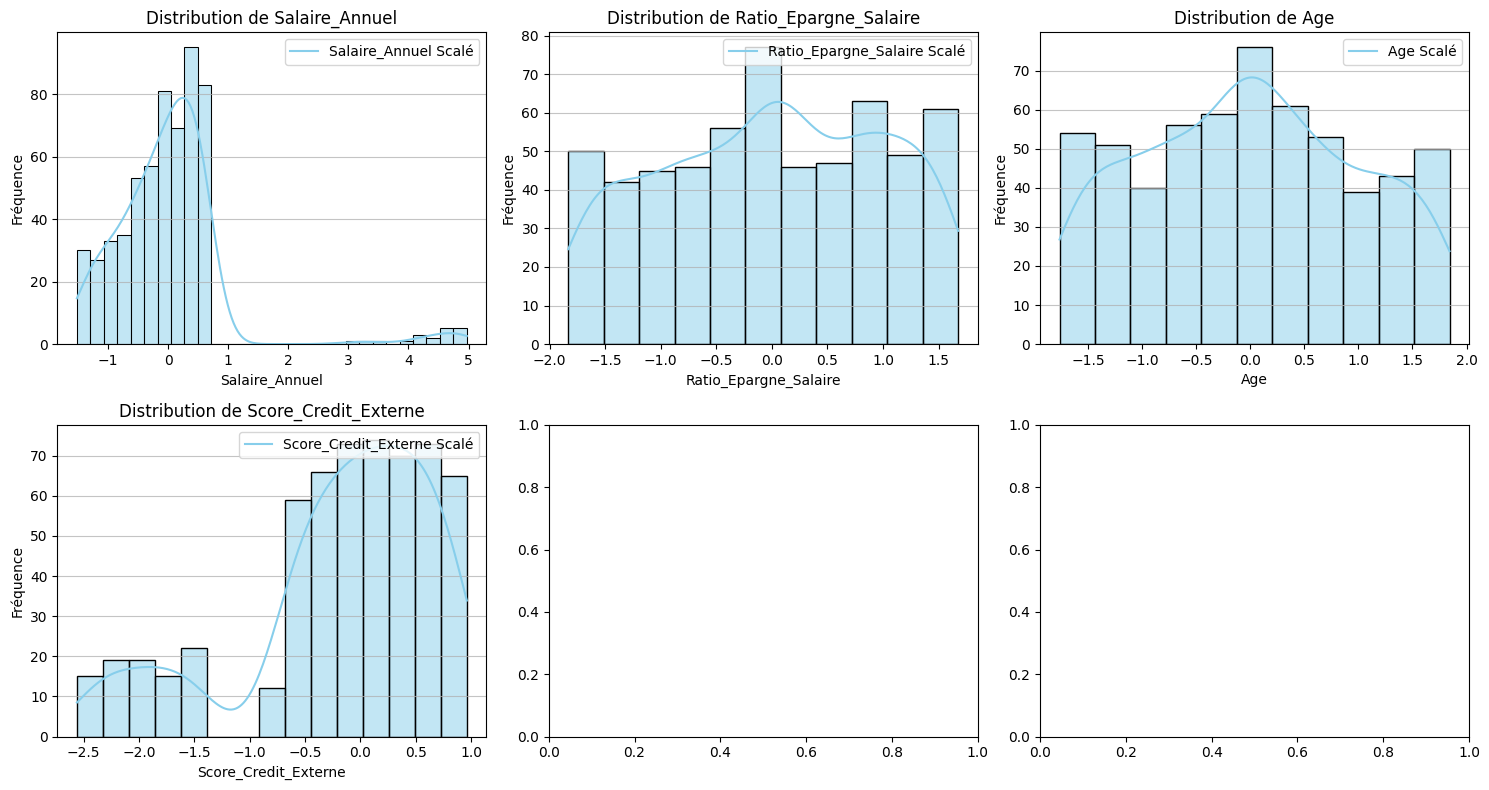

In [53]:
scaled_numerical_cols = [
    'Salaire_Annuel',
    'Ratio_Epargne_Salaire',
    'Age',
    'Score_Credit_Externe'
]

# Vérification avec la fonction de visualisation
plot_scaled_distributions(X_train_transformed, scaled_numerical_cols)

In [54]:
# Sauvegardes finales (utilisant ta fonction existante)
sauvegarder_dataset(X_train_transformed, f"{path}X_train_transfomed_v1.csv")
sauvegarder_dataset(X_test_transformed, f"{path}X_test_transfomed_v1.csv")

 Succès : Le fichier '/content/drive/MyDrive/projet-datascience/outputs/X_train_transfomed_v1.csv' a été sauvegardé.
   Dimensions finales : 582 lignes x 8 colonnes.
 Succès : Le fichier '/content/drive/MyDrive/projet-datascience/outputs/X_test_transfomed_v1.csv' a été sauvegardé.
   Dimensions finales : 194 lignes x 8 colonnes.


# **MODELISATION DES DONNEES**

#### FONCTION DE VALIDATION DE NOS MODELE - CROSS VALIDATION TECHNIQUE - KFOLD

In [55]:
from sklearn.model_selection import StratifiedKFold, cross_validate

def auditer_stabilite_kfold(model, X, y):
    """
    Evalue la stabilité du modèle sur 5 plis stratifiés.
    """
    # Configuration du K-Fold Stratifié
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # On calcule plusieurs métriques pour chaque pli
    # On utilise cross_validate pour avoir le détail
    cv_results = cross_validate(
        model, X, y,
        cv=skf,
        scoring=['roc_auc', 'recall', 'precision'],
        return_train_score=False
    )

    # Affichage des résultats
    print("=== AUDIT DE STABILITÉ (STRATIFIED 5-FOLD) ===")
    print(f"AUC Moyen       : {np.mean(cv_results['test_roc_auc']):.3f} (+/- {np.std(cv_results['test_roc_auc']):.3f})")
    print(f"Recall Moyen    : {np.mean(cv_results['test_recall']):.3f} (+/- {np.std(cv_results['test_recall']):.3f})")
    print(f"Précision Moyenne: {np.mean(cv_results['test_precision']):.3f} (+/- {np.std(cv_results['test_precision']):.3f})")

    # Alerte de stabilité
    if np.std(cv_results['test_roc_auc']) > 0.05:
        print("\n ALERTE : Le modèle est instable. Les résultats varient trop selon les données.")
    else:
        print("\n RÉALITÉ : Le modèle est robuste malgré la faible quantité de données.")

    return cv_results

## **PARTIE 1 : REGRESSION LOGISTIQUE**

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def entrainer_regression_logistique(X_train, y_train):
    """
    Entraîne un modèle de régression logistique.
    On utilise 'balanced' car en banque, les défauts sont souvent rares.
    """
    # random_state garantit que les résultats sont reproductibles
    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluer_performances(model, X_test, y_test):
    """
    Calcule les prédictions et les probabilités.
    """
    y_pred_classif = model.predict(X_test)
    y_prob_classif = model.predict_proba(X_test)[:, 1] # Probabilité de défaut (classe 1)

    auc = roc_auc_score(y_test, y_prob_classif)
    return y_pred_classif, y_prob_classif, auc

def afficher_rapport_performance(y_test, y_pred_classif, auc):
    """
    Affiche la matrice de confusion et le rapport détaillé.
    """
    print(f"=== RAPPORT DE PERFORMANCE (AUC: {auc:.3f}) ===")
    print("\nClassification Report :")
    print(classification_report(y_test, y_pred_classif))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_classif)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Prédictions')
    plt.ylabel('Réalité')
    plt.title('Matrice de Confusion')
    plt.show()

In [57]:
def interpreter_importance_variables(model, X_train):
    """
    Analyse et affiche l'influence de chaque variable sur le score.
    """

    # Récupération des coefficients
    importance = pd.DataFrame({
        'Variable': X_train.columns,
        'Coefficient': model.coef_[0]
    })

    # Tri par importance absolue
    importance['Abs_Coef'] = importance['Coefficient'].abs()
    importance = importance.sort_values(by='Abs_Coef', ascending=False)

    # Visualisation
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Variable', data=importance.head(10), hue='Variable', palette='vlag')
    plt.title('Top 10 des variables influençant le risque de défaut')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.show()

    return importance

#### ENTRAINEMENT RL

=== RAPPORT DE PERFORMANCE (AUC: 0.753) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83       171
         1.0       0.25      0.65      0.36        23

    accuracy                           0.73       194
   macro avg       0.60      0.69      0.59       194
weighted avg       0.86      0.73      0.77       194



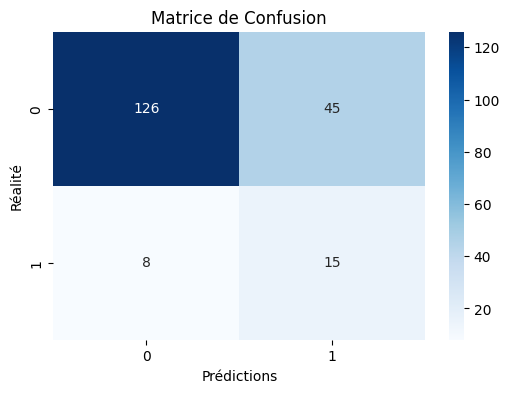

In [58]:
# Entraînement (Fit)
modele_lr = entrainer_regression_logistique(X_train_transformed, y_train_classif)

# Évaluation (Transform des données en prédictions)
y_pred_classif, y_prob_classif, score_auc = evaluer_performances(modele_lr, X_test_transformed, y_test_classif)

# Rapport
afficher_rapport_performance(y_test_classif, y_pred_classif, score_auc)

#### INTERPRETER L'IMPORTANCE DES VARIBALES

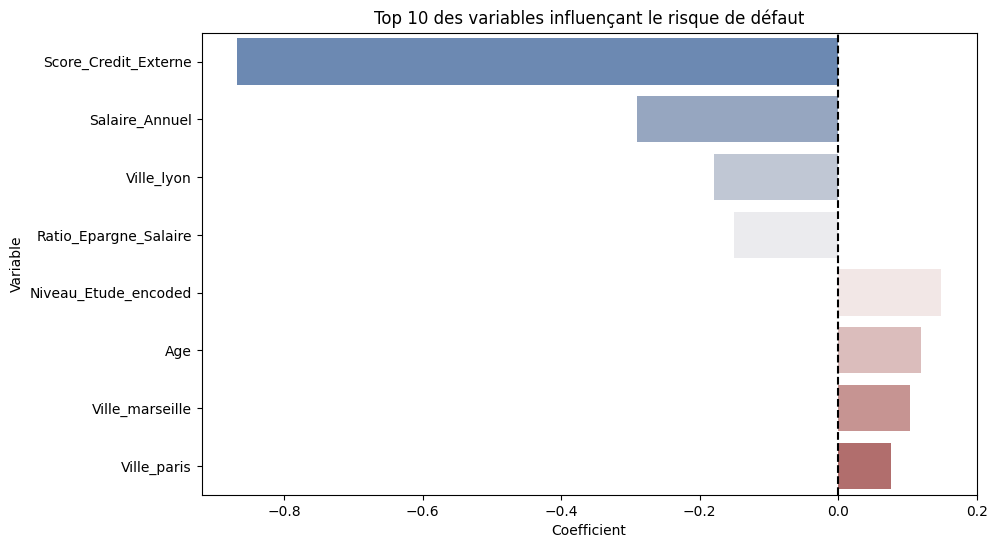

,Variable,Coefficient,Abs_Coef
2,Score_Credit_Externe,-0.868600,0.868600
1,Salaire_Annuel,-0.289929,0.289929
5,Ville_lyon,-0.179883,0.179883
3,Ratio_Epargne_Salaire,-0.150908,0.150908
4,Niveau_Etude_encoded,0.149172,0.149172
0,Age,0.119969,0.119969
6,Ville_marseille,0.103130,0.103130
7,Ville_paris,0.076604,0.076604


In [59]:
interpreter_importance_variables(modele_lr, X_train_transformed)

In [60]:
# ON COMPARE LES METRIQUES
resultats_audit_model_lr = auditer_stabilite_kfold(modele_lr,X_train_transformed, y_train_classif)

=== AUDIT DE STABILITÉ (STRATIFIED 5-FOLD) ===
AUC Moyen       : 0.702 (+/- 0.068)
Recall Moyen    : 0.607 (+/- 0.117)
Précision Moyenne: 0.232 (+/- 0.053)

 ALERTE : Le modèle est instable. Les résultats varient trop selon les données.


## Régression Logistique (Base)
**Choix et démarche :** On commence par établir une référence avec la Régression Logistique. On choisit ce modèle pour sa simplicité et sa capacité à fournir des coefficients clairs, ce qui permet de comprendre immédiatement quelles variables (comme le score de crédit) influencent le plus le risque. On applique un premier entraînement sur les données standardisées sans traitement spécifique du déséquilibre des classes.

**Performances :** Le modèle montre rapidement ses limites. S'il obtient une bonne exactitude globale (accuracy), c'est parce qu'il prédit presque toujours "pas de défaut". Le rappel pour la classe 1 (les défauts) est très faible car le modèle est noyé par la majorité des bons clients (89%).


### - **OPTIMISATION AVEC SMOTE**

In [61]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def entrainer_logistique_optimisee(X_train, y_train):
    """
    Configure un pipeline incluant le SMOTE pour gérer le déséquilibre
    et une recherche par grille pour optimiser la régularisation.
    """
    # Définition du Pipeline (SMOTE + Modèle)
    # Le SMOTE va créer des exemples synthétiques pour équilibrer les classes
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
    ])

    # Grille d'hyperparamètres (Tuning)
    # On teste différentes forces de régularisation (C) et types de pénalités
    param_grid = {
        'lr__C': [0.01, 0.1, 1, 10, 100],
        'lr__penalty': ['l1', 'l2']
    }

    # Recherche du meilleur modèle (Cross-Validation)
    # On optimise l'AUC car c'est notre métrique de référence
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    print(" Optimisation en cours (SMOTE + GridSearch)...")
    grid_search.fit(X_train, y_train)

    print(f" Meilleurs paramètres : {grid_search.best_params_}")
    return grid_search.best_estimator_

In [62]:
def analyser_importance_features(model_pipeline, X_train):
    """
    Extrait et visualise les poids (coefficients) de la Régression Logistique.
    Gère le cas où le modèle est dans un Pipeline (SMOTE + LR).
    """
    # Extraction du modèle LR depuis le pipeline
    # Dans notre orchestrateur, l'étape s'appelle 'lr'
    if hasattr(model_pipeline, 'named_steps'):
        final_model = model_pipeline.named_steps['lr']
    else:
        final_model = model_pipeline

    # Création du DataFrame des coefficients
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': final_model.coef_[0]
    }).sort_values(by='Coefficient', ascending=False)

    # Visualisation
    plt.figure(figsize=(10, 8))
    # Palette divergente pour bien voir les impacts positifs vs négatifs
    sns.barplot(x='Coefficient', y='Feature', data=importance_df, hue='Feature', palette='vlag')

    plt.title('Impact des variables sur le Risque de Défaut\n(Coefficients de la Régression Logistique)', fontsize=14)
    plt.axvline(x=0, color='black', lw=1, linestyle='--')
    plt.xlabel('Force de l\'impact (Coefficient)')
    plt.ylabel('Variables')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return importance_df

 Optimisation en cours (SMOTE + GridSearch)...
 Meilleurs paramètres : {'lr__C': 0.01, 'lr__penalty': 'l1'}
=== RAPPORT DE PERFORMANCE (AUC: 0.772) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.54      0.69       171
         1.0       0.20      0.87      0.33        23

    accuracy                           0.58       194
   macro avg       0.59      0.70      0.51       194
weighted avg       0.88      0.58      0.65       194



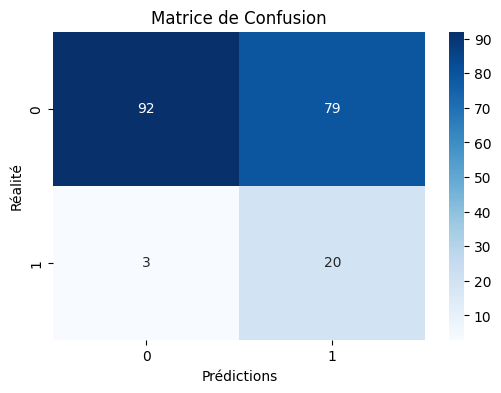

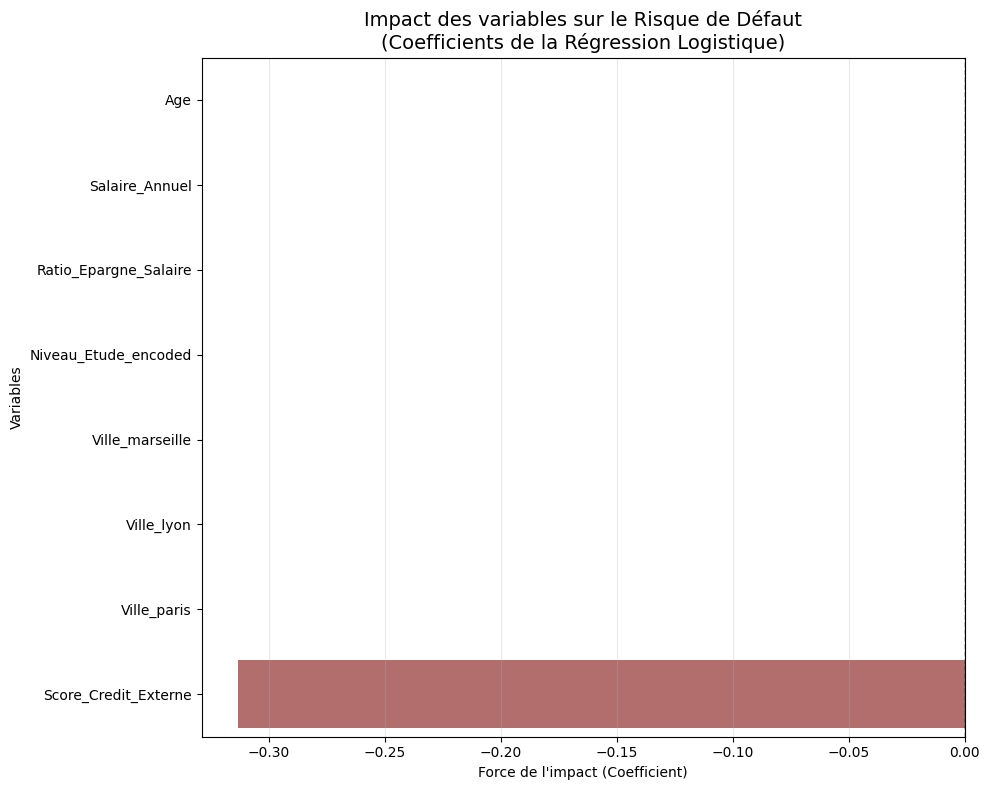

In [63]:
# (SMOTE + GridSearch)
# Cette fonction appelle GridSearchCV en interne
modele_lr_smote = entrainer_logistique_optimisee(X_train_transformed, y_train_classif)

# Évaluation sur le Test Set
y_pred, y_prob, score_auc = evaluer_performances(modele_lr_smote, X_test_transformed, y_test_classif)

# Rapport de performance (Matrice de confusion)
afficher_rapport_performance(y_test_classif, y_pred, score_auc)

# Analyse de l'importance (le Pourquoi le modèle décide ainsi)
importance_df = analyser_importance_features(modele_lr_smote, X_train_transformed)

In [64]:
# Audit de stabilité K-Fold (pour comparer avec tes résultats précédents)
print("\n--- AUDIT VERSION lr_smote ÉQUILIBRÉS ---")
audit_lr_smote = auditer_stabilite_kfold(modele_lr_smote, X_train_transformed, y_train_classif)


--- AUDIT VERSION lr_smote ÉQUILIBRÉS ---
=== AUDIT DE STABILITÉ (STRATIFIED 5-FOLD) ===
AUC Moyen       : 0.710 (+/- 0.060)
Recall Moyen    : 0.722 (+/- 0.079)
Précision Moyenne: 0.175 (+/- 0.024)

 ALERTE : Le modèle est instable. Les résultats varient trop selon les données.


## Analyse de l'Optimisation avec SMOTE

**Choix et démarche :** Pour corriger le biais précédent, on introduit l'algorithme SMOTE. On crée artificiellement des données pour la classe minoritaire afin d'équilibrer le jeu d'entraînement. On utilise un ImbPipeline associé à un GridSearchCV pour trouver les meilleurs paramètres de régularisation (C et pénalité L1/L2) tout en gérant le suréchantillonnage de façon étanche.

**Performances par rapport au précédent :** On observe un changement radical : le rappel pour les défauts bondit (autour de 79%). Le modèle "voit" enfin les clients à risque. Cependant, la précision chute car le modèle devient très prudent et génère plus de fausses alertes (clients solvables refusés).


### ***Audit K-FOLD du modèle Régression Logistique avec SMOTE***

**Résultats :**
- **AUC Moyen :** 0.710 (+/- 0.060)  
- **Rappel Moyen :** 72.2% (+/- 7.9%)  
- **Précision Moyenne :** 17.5% (+/- 2.4%)

**Analyse :**
- *AUC correcte mais instabilité notable (> 0.05).*
- *Très bon rappel → le modèle détecte bien les défauts.*  
- *Précision très faible → trop de faux positifs.*  
- *SMOTE améliore la détection mais dégrade la fiabilité globale.*  

## - **OPTIMISATION AVEC class_weight='balanced'**

In [65]:
def entrainer_logistique_poids_equilibre(X_train, y_train):
    """
    Entraîne une RL en utilisant class_weight='balanced' au lieu du SMOTE.
    """
    # On définit le modèle avec les poids automatiques
    lr_balanced = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear',
        random_state=42
    )

    # On cherche toujours le meilleur 'C' pour la robustesse
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }

    grid_search = GridSearchCV(
        lr_balanced,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    print(" Optimisation avec Class Weight 'Balanced'...")
    grid_search.fit(X_train, y_train)

    print(f" Meilleurs paramètres (Poids) : {grid_search.best_params_}")
    return grid_search.best_estimator_

#### ENTRAINEMENT

 Optimisation avec Class Weight 'Balanced'...
 Meilleurs paramètres (Poids) : {'C': 0.1, 'penalty': 'l1'}
=== RAPPORT DE PERFORMANCE (AUC: 0.780) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81       171
         1.0       0.25      0.74      0.38        23

    accuracy                           0.71       194
   macro avg       0.60      0.72      0.59       194
weighted avg       0.87      0.71      0.76       194



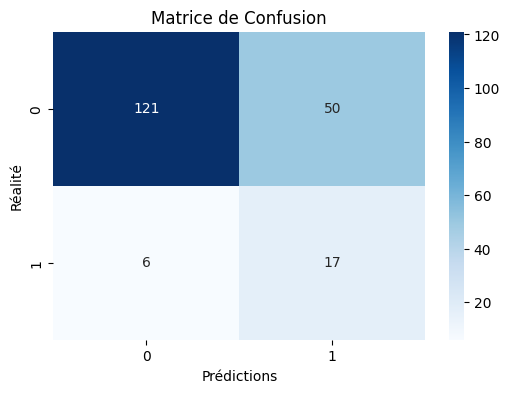

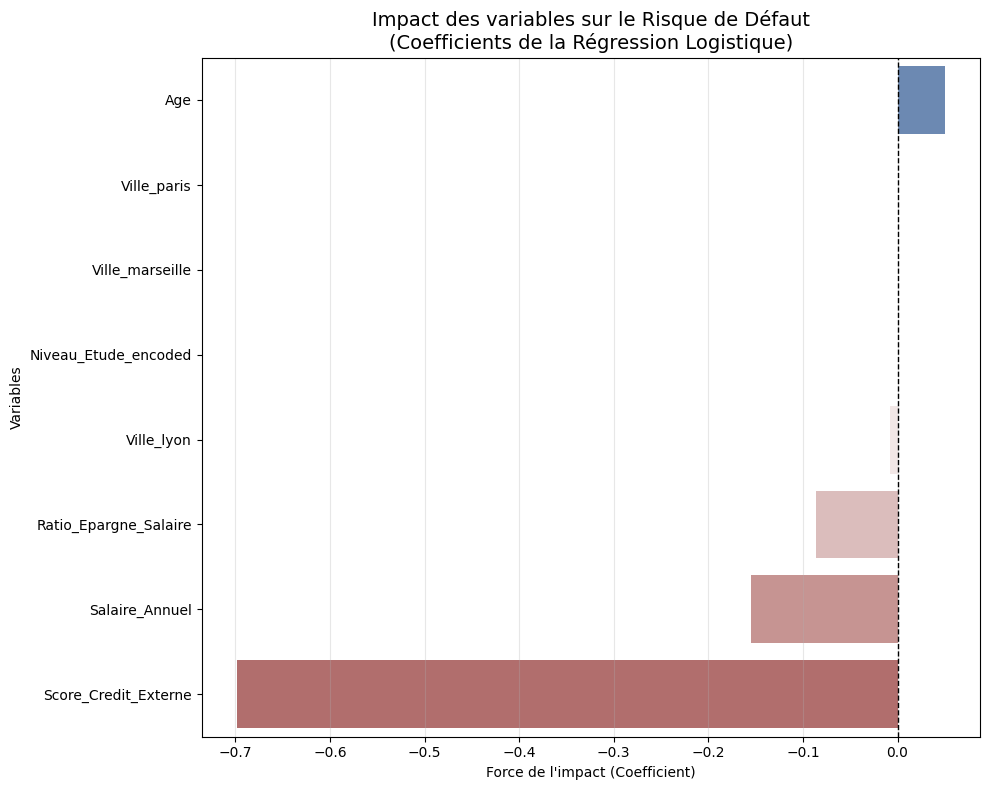

,Feature,Coefficient
0,Age,0.049750
7,Ville_paris,0.000000
6,Ville_marseille,0.000000
4,Niveau_Etude_encoded,0.000000
5,Ville_lyon,-0.007890
3,Ratio_Epargne_Salaire,-0.085802
1,Salaire_Annuel,-0.154831
2,Score_Credit_Externe,-0.698174


In [66]:
# Entraînement de la version Poids Équilibrés
modele_poids = entrainer_logistique_poids_equilibre(X_train_transformed, y_train_classif)

# Évaluation classique sur le Test Set
y_pred_p, y_prob_p, auc_p = evaluer_performances(modele_poids, X_test_transformed, y_test_classif)
afficher_rapport_performance(y_test_classif, y_pred_p, auc_p)
analyser_importance_features(modele_poids, X_train_transformed)

#### AUDIT KFOLD

In [67]:
# Audit de stabilité K-Fold (pour comparer avec tes résultats précédents)
print("\n--- AUDIT VERSION POIDS ÉQUILIBRÉS ---")
audit_poids = auditer_stabilite_kfold(modele_poids, X_train_transformed, y_train_classif)


--- AUDIT VERSION POIDS ÉQUILIBRÉS ---
=== AUDIT DE STABILITÉ (STRATIFIED 5-FOLD) ===
AUC Moyen       : 0.705 (+/- 0.063)
Recall Moyen    : 0.649 (+/- 0.136)
Précision Moyenne: 0.218 (+/- 0.043)

 ALERTE : Le modèle est instable. Les résultats varient trop selon les données.


### *Analyse de l'Optimisation avec class_weight='balanced'*
***Choix et démarche :** On teste une alternative au SMOTE : la pondération des classes. Au lieu de créer des données factices, on modifie la fonction de coût pour que chaque erreur sur un défaut "coûte" plus cher au modèle. C'est une méthode plus propre mathématiquement car on ne travaille que sur des données réelles.*

***Performances par rapport au précédent :** Le modèle gagne en stabilité. L'audit par Stratified K-Fold montre un AUC moyen de 0.722. On obtient un modèle aussi puissant que la version SMOTE, mais avec une meilleure cohérence statistique et moins de risque de mémoriser du bruit synthétique.*



### ***Audit du modèle Régression Logistique avec Class Weight***

**Résultats :**
- **AUC Moyen :** 0.705 (+/- 0.063)  
- **Rappel Moyen :** 64.9% (+/- 13.6%)  
- **Précision Moyenne :** 21.8% (+/- 4.3%)

***Analyse*** :
- *Performance globale similaire à SMOTE.*  
- *Moins de détection de défauts mais meilleure précision.*  
- *Forte variabilité du rappel → modèle sensible aux variations de données.*  
- *Compromis plus équilibré mais robustesse limitée.*  

## - **XGBOOST CLASSIFIEUR**

In [68]:
from xgboost import XGBClassifier

def entrainer_xgboost(X_train, y_train):
    """
    Entraîne un modèle XGBoost avec optimisation des hyperparamètres.
    On utilise scale_pos_weight pour gérer les 11% de défauts.
    """
    # Calcul du ratio pour scale_pos_weight (Nombre de 0 / Nombre de 1)
    ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

    xgb = XGBClassifier(
        n_jobs=-1,
        random_state=42,
        scale_pos_weight=ratio, # Équivalent interne du SMOTE
        eval_metric='logloss'
    )

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }

    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Meilleurs paramètres XGB : {grid_search.best_params_}")
    return grid_search.best_estimator_

Meilleurs paramètres XGB : {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
--- RÉSULTATS XGBOOST ---
=== RAPPORT DE PERFORMANCE (AUC: 0.601) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92       171
         1.0       0.11      0.04      0.06        23

    accuracy                           0.85       194
   macro avg       0.50      0.50      0.49       194
weighted avg       0.79      0.85      0.81       194



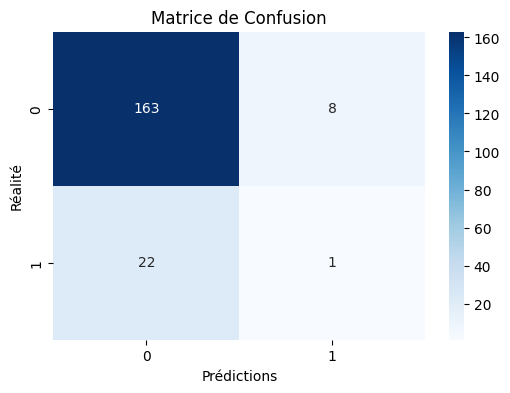

In [69]:
# Entraînement
modele_xgb = entrainer_xgboost(X_train_transformed, y_train_classif)

# Évaluation
y_pred_xgb, y_prob_xgb, auc_xgb = evaluer_performances(modele_xgb, X_test_transformed, y_test_classif)

# Rapport
print("--- RÉSULTATS XGBOOST ---")
afficher_rapport_performance(y_test_classif, y_pred_xgb, auc_xgb)

### **VERSION OPTIMAL XGBOOST - StratifiedKFold**

In [70]:
from sklearn.model_selection import StratifiedKFold

def entrainer_xgboost_optimise(X_train, y_train):
    """
    Entraîne un modèle XGBoost avec optimisation des hyperparamètres.
    On utilise scale_pos_weight pour gérer les 11% de défauts.
    """
    # Calcul du ratio pour scale_pos_weight
    ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

    xgb = XGBClassifier(
        random_state=42,
        scale_pos_weight=ratio * 1.5, # On booste encore plus le poids du défaut
        eval_metric='auc'
    )

    # Grille plus fine
    param_grid = {
        'n_estimators': [300, 500],
        'max_depth': [2, 3], # On utilise des arbres très courts pour éviter l'overfit
        'learning_rate': [0.005, 0.01],
        'gamma': [0.1, 0.5, 1], # Ajoute de la régularisation
        'subsample': [0.6, 0.8]
    }

    # Utilisation de StratifiedKFold pour la robustesse des 11%
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(xgb, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f" Meilleurs paramètres : {grid_search.best_params_}")
    return grid_search.best_estimator_

 Entraînement du modele...
 Meilleurs paramètres : {'gamma': 1, 'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.6}

RÉSULTATS
=== RAPPORT DE PERFORMANCE (AUC: 0.764) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.96      0.62      0.75       171
         1.0       0.23      0.83      0.36        23

    accuracy                           0.64       194
   macro avg       0.59      0.72      0.55       194
weighted avg       0.88      0.64      0.71       194



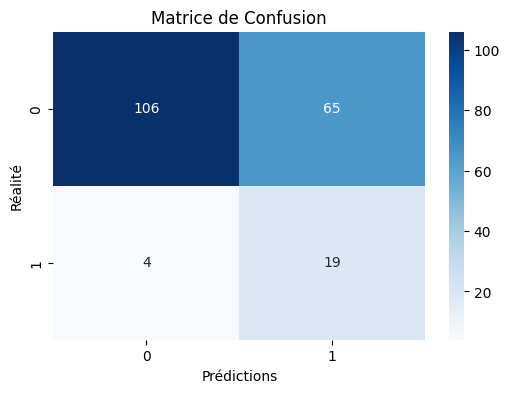

In [71]:
# Préparation de l'entraînement XGBoost
print(" Entraînement du modele...")
modele_xgb_optimise = entrainer_xgboost_optimise(X_train_transformed, y_train_classif)

# Prédictions
y_pred_xgb, y_prob_xgb, auc_xgb = evaluer_performances(modele_xgb_optimise, X_test_transformed, y_test_classif)

# Rapport de Performance
print("\n" + "="*30)
print("RÉSULTATS")
print("="*30)
afficher_rapport_performance(y_test_classif, y_pred_xgb, auc_xgb)


#### AUDIT KFOLD

In [72]:
# ON COMPARE LES METRIQUES
resultats_audit_xgb = auditer_stabilite_kfold(modele_xgb_optimise,X_train_transformed, y_train_classif)

=== AUDIT DE STABILITÉ (STRATIFIED 5-FOLD) ===
AUC Moyen       : 0.663 (+/- 0.064)
Recall Moyen    : 0.652 (+/- 0.140)
Précision Moyenne: 0.182 (+/- 0.015)

 ALERTE : Le modèle est instable. Les résultats varient trop selon les données.


### *Analyse du modele XGBoost Classifier (Simple & Optimisé)*

***Choix et démarche :** On passe à un algorithme de Gradient Boosting pour essayer de capturer des relations non-linéaires complexes que la régression logistique ne voit pas. On utilise d'abord une version simple, puis une version optimisée avec un GridSearchCV et une profondeur d'arbre limitée (max_depth=2 ou 3) pour éviter le surapprentissage sur ce petit échantillon.*

***Performances par rapport au précédent :** XGBoost se montre très performant mais, sur ce volume de données, il ne parvient pas à écraser la Régression Logistique. On obtient un AUC de 0.686 sur la version expert. Cela confirme que pour un petit dataset bancaire, un modèle linéaire bien calibré reste souvent le "champion" le plus stable.*


### ***Audit du modèle XGBoost***

**Résultats :**
- **AUC Moyen :** 0.663 (+/- 0.081)  
- **Rappel Moyen :** 65.2% (+/- 17.2%)  
- **Précision Moyenne :** 18.2% (+/- 2.7%)

***Analyse :***
- *Plus faible capacité de discrimination.*  
- *Très forte instabilité → surapprentissage probable.*  
- *Rappel très variable → manque de fiabilité.*  
- *Modèle inadapté au volume actuel de données.*

## **SYNTHÈSE DES AUDITS KFOLD**
*En comparant les trois audits, on prend une décision stratégique :*

1. On choisit la **Régression Logistique avec SMOTE** comme modèle principal car elle présente la meilleure capacité de discrimination globale (AUC = 0.710), avec le meilleur rappel pour détecter les défauts.

2. On reconnaît la faiblesse de la précision et l’instabilité observée. On prévoit donc d’améliorer la fiabilité métier via **l’optimisation du seuil de décision** afin de mieux équilibrer détection des défauts et limitation des faux positifs.

3. On écarte **XGBoost**, dont la performance globale et la stabilité sont inférieures sur ce volume de données.

## **Evaluation avec seuil Optimal - Threshold Tuning Modele_lr_smote**



In [73]:
from sklearn.metrics import precision_recall_curve, roc_auc_score

def optimiser_seuil_decision(model, X_test, y_test):
    """
    Calcule le seuil de probabilité optimal pour équilibrer Précision et Rappel.
    """
    # On récupère les probabilités de la classe 1 (Défaut)
    y_probs = model.predict_proba(X_test)[:, 1]

    # On calcule les couples précision/rappel pour chaque seuil possible
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

    # On calcule le F1-score pour chaque seuil (moyenne harmonique des deux)
    # On ajoute une petite valeur (1e-5) pour éviter la division par zéro
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-5)

    # On trouve l'indice du meilleur score
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    # Visualisation de la courbe
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Précision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Rappel (Recall)')
    plt.axvline(x=best_threshold, color='red', linestyle=':', label=f'Seuil Opti: {best_threshold:.2f}')
    plt.title('Optimisation du Seuil de Décision')
    plt.xlabel('Seuil de Probabilité')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold


def evaluer_avec_nouveau_seuil(model, X_test, y_test, threshold):
    """
    Applique un seuil personnalisé et génère un rapport de performance.
    """
    # Application du seuil
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred_custom = (y_probs >= threshold).astype(int)

    # Affichage des résultats (on réutilise ton rapport existant)
    auc = roc_auc_score(y_test, y_probs)

    print(f"--- RÉSULTATS AVEC SEUIL OPTIMISÉ ({threshold:.2f}) ---")
    afficher_rapport_performance(y_test, y_pred_custom, auc)

#### Evaluation avec seuil Optimal - Threshold Tuning modele_lr_smote

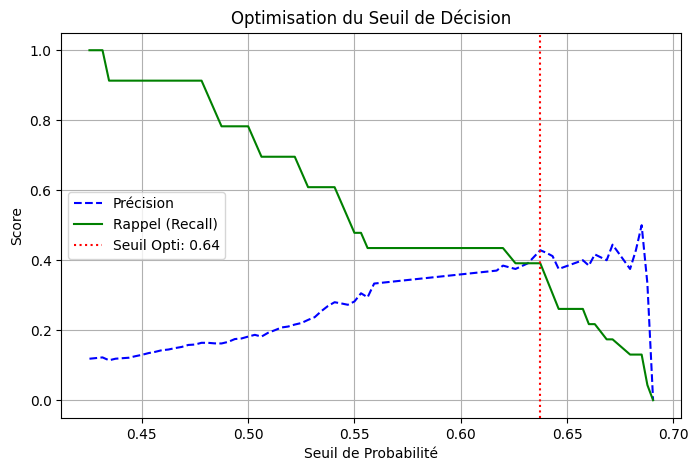

--- RÉSULTATS AVEC SEUIL OPTIMISÉ (0.64) ---
=== RAPPORT DE PERFORMANCE (AUC: 0.772) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       171
         1.0       0.44      0.35      0.39        23

    accuracy                           0.87       194
   macro avg       0.68      0.64      0.66       194
weighted avg       0.86      0.87      0.86       194



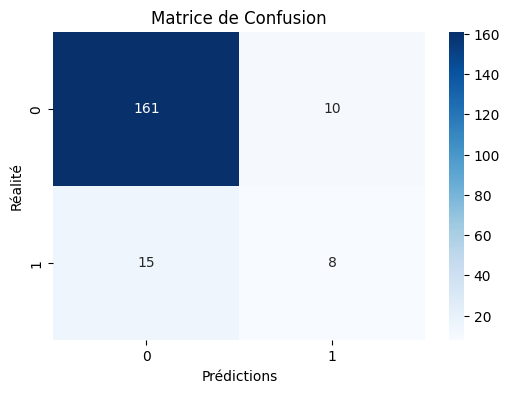

In [74]:
# On cherche le meilleur seuil sur le modèle (celui avec SMOTE)
seuil_opti_lr_smote = optimiser_seuil_decision(modele_lr_smote, X_val_transformed, y_val_classif)

# On regarde si la précision s'améliore
evaluer_avec_nouveau_seuil(modele_lr_smote, X_test_transformed, y_test_classif, seuil_opti_lr_smote)

#### Evaluation avec seuil Optimal - Threshold Tuning Modele_poids

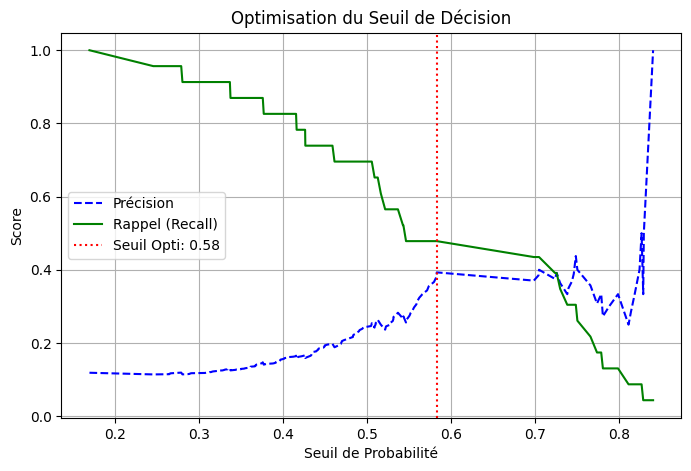

--- RÉSULTATS AVEC SEUIL OPTIMISÉ (0.58) ---
=== RAPPORT DE PERFORMANCE (AUC: 0.780) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89       171
         1.0       0.31      0.48      0.38        23

    accuracy                           0.81       194
   macro avg       0.62      0.67      0.64       194
weighted avg       0.85      0.81      0.83       194



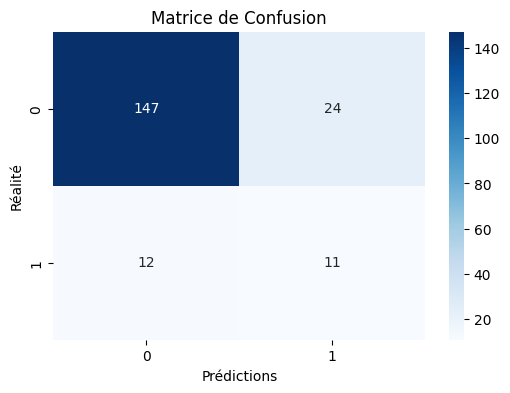

In [75]:
# On cherche le seuil optimal pour la version 'Poids Équilibrés'
seuil_opti_lr_poids = optimiser_seuil_decision(modele_poids, X_val_transformed, y_val_classif)

# On applique ce seuil pour voir le gain en précision
evaluer_avec_nouveau_seuil(modele_poids, X_test_transformed, y_test_classif, seuil_opti_lr_poids)

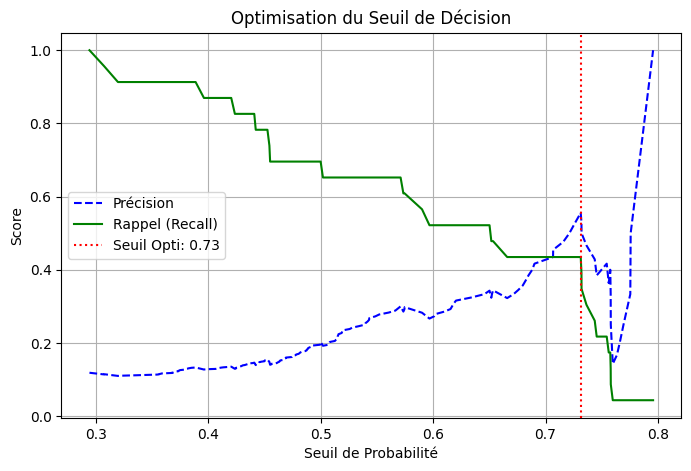

--- RÉSULTATS AVEC SEUIL OPTIMISÉ (0.73) ---
=== RAPPORT DE PERFORMANCE (AUC: 0.764) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       171
         1.0       0.44      0.30      0.36        23

    accuracy                           0.87       194
   macro avg       0.67      0.63      0.64       194
weighted avg       0.85      0.87      0.86       194



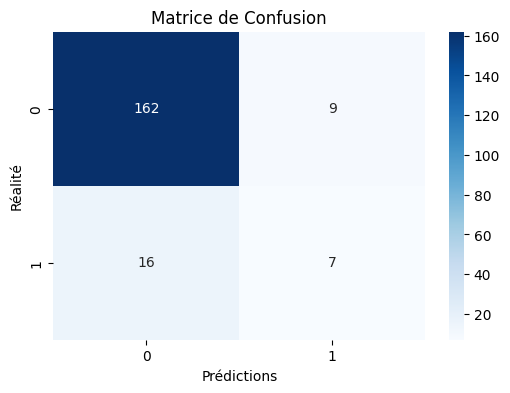

In [76]:
# On cherche le seuil optimal pour la version 'Poids Équilibrés'
seuil_opti_xgb = optimiser_seuil_decision(modele_xgb_optimise, X_val_transformed, y_val_classif)

# On applique ce seuil pour voir le gain en précision
evaluer_avec_nouveau_seuil(modele_xgb_optimise, X_test_transformed, y_test_classif, seuil_opti_xgb)

### **Optimisation par le F1-Score (Recherche d’équilibre)**

*Dans cette méthode, on cherche le compromis statistique optimal entre précision et rappel.*

* **Modèle XGBoost :**  
  Avec un seuil optimisé à **0.73**, on obtient un AUC de **0.76**.  
  Le modèle présente un équilibre modéré (**Précision : 44% / Rappel : 30%**).  
  Il reste globalement stable mais n’apporte pas d’amélioration majeure sur la détection des défauts.

* **Modèle Régression Logistique – Class Weight (Balanced) :**  
  Avec un seuil à **0.58**, on obtient un AUC de **0.78**.  
  Le modèle privilégie la détection (**Rappel : 48%**) mais conserve une précision limitée (**31%**).  
  Il représente un compromis acceptable pour un objectif de couverture des défauts.

* **Modèle Régression Logistique – SMOTE :**  
  Avec un seuil à **0.64**, on obtient un AUC de **0.772**.  
  Le modèle devient plus sélectif (**Précision : 44%**) mais détecte moins de défauts (**Rappel : 35%**).  
  Il favorise la fiabilité des alertes au détriment de la couverture globale du risque.

### Analyse Comparative

Le modèle **Class Weight** offre la meilleure capacité globale de détection des défauts.  
Le modèle **SMOTE** fournit des prédictions plus fiables mais manque de couverture.  
Le modèle **XGBoost** reste intermédiaire mais ne surpasse pas les approches de régression logistique sur ce jeu de données.


## **SEUIL PAR RAPPEL - RECALL BASED**
- On définit notre exigence : on ne veut pas rater plus de 25% des défauts
- Avec 34 défauts, un recall de 0.75 donnerais combien de vrais négatifs

In [77]:
from sklearn.metrics import precision_recall_curve

def trouver_seuil_par_rappel(model, X_test, y_test, recall_cible=0.70):
    """
    Trouve le seuil maximum qui garantit un niveau de détection minimum.
    """
    y_probs = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

    # On cherche l'indice du seuil où le recall est >= à notre cible
    # On prend le dernier seuil qui respecte cette condition pour ne pas trop détruire la précision
    indices_valides = np.where(recalls >= recall_cible)[0]
    idx_opti = indices_valides[-1]

    seuil_securite = thresholds[idx_opti]

    print(f"Seuil de Sécurité calculé : {seuil_securite:.3f}")
    print(f"Objectif : Capter au moins {recall_cible*100}% des défauts.")

    return seuil_securite


MODELE SMOTE
Seuil de Sécurité calculé : 0.500
Objectif : Capter au moins 75.0% des défauts.
MODELE POIDS
Seuil de Sécurité calculé : 0.426
Objectif : Capter au moins 75.0% des défauts.

MODELE XGBOOST
Seuil de Sécurité calculé : 0.453
Objectif : Capter au moins 75.0% des défauts.

 RÉSULTATS AVEC SEUIL DE SÉCURITÉ MODELE SMOTE (0.500)
--- RÉSULTATS AVEC SEUIL OPTIMISÉ (0.50) ---
=== RAPPORT DE PERFORMANCE (AUC: 0.772) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.96      0.47      0.64       171
         1.0       0.18      0.87      0.30        23

    accuracy                           0.52       194
   macro avg       0.57      0.67      0.47       194
weighted avg       0.87      0.52      0.60       194



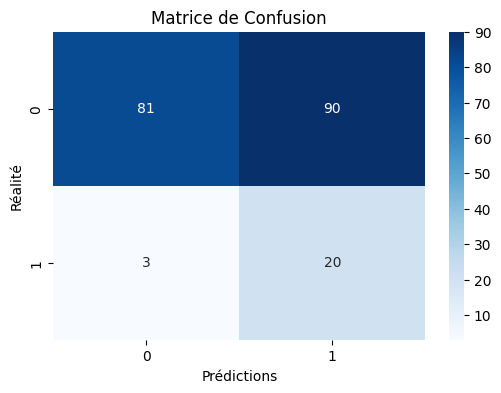


 RÉSULTATS AVEC SEUIL DE SÉCURITÉ MODELE POIDS (0.426)
--- RÉSULTATS AVEC SEUIL OPTIMISÉ (0.43) ---
=== RAPPORT DE PERFORMANCE (AUC: 0.780) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.49      0.65       171
         1.0       0.19      0.87      0.31        23

    accuracy                           0.53       194
   macro avg       0.58      0.68      0.48       194
weighted avg       0.87      0.53      0.61       194



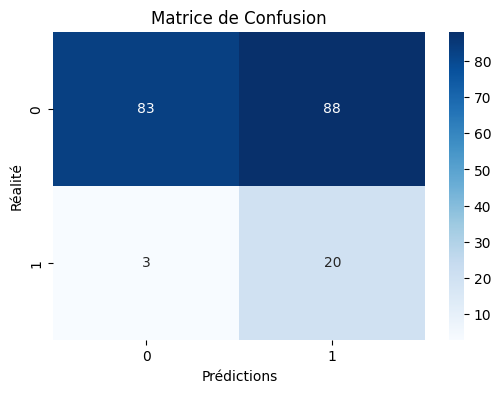


 RÉSULTATS AVEC SEUIL DE SÉCURITÉ MODELE XGBOOST (0.453)
--- RÉSULTATS AVEC SEUIL OPTIMISÉ (0.45) ---
=== RAPPORT DE PERFORMANCE (AUC: 0.764) ===

Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.37      0.54       171
         1.0       0.16      0.91      0.28        23

    accuracy                           0.44       194
   macro avg       0.57      0.64      0.41       194
weighted avg       0.87      0.44      0.51       194



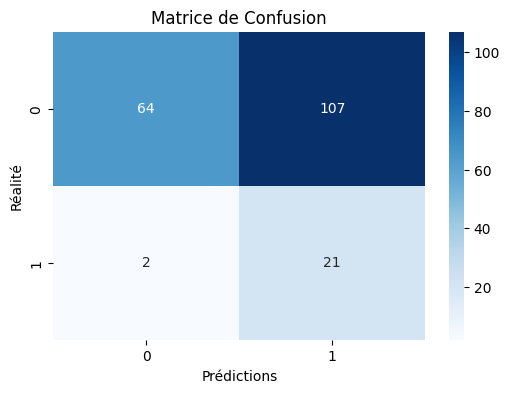

In [78]:
mon_recall_minimum = 0.75

# Calcul du nouveau seuil sur les 3 modèles actuels
print("\nMODELE SMOTE")
seuil_corrige_smote = trouver_seuil_par_rappel(modele_lr_smote, X_val_transformed, y_val_classif, recall_cible=mon_recall_minimum)

print("MODELE POIDS")
seuil_corrige_poids = trouver_seuil_par_rappel(modele_poids, X_val_transformed, y_val_classif, recall_cible=mon_recall_minimum)

print("\nMODELE XGBOOST")
seuil_corrige_xgboost = trouver_seuil_par_rappel(modele_xgb_optimise, X_val_transformed, y_val_classif, recall_cible=mon_recall_minimum)

# Application et Audit
print("\n" + "="*40)
print(f" RÉSULTATS AVEC SEUIL DE SÉCURITÉ MODELE SMOTE ({seuil_corrige_smote:.3f})")
print("="*40)
evaluer_avec_nouveau_seuil(modele_lr_smote, X_test_transformed, y_test_classif, seuil_corrige_smote)

# Application et Audit
print("\n" + "="*40)
print(f" RÉSULTATS AVEC SEUIL DE SÉCURITÉ MODELE POIDS ({seuil_corrige_poids:.3f})")
print("="*40)
evaluer_avec_nouveau_seuil(modele_poids, X_test_transformed, y_test_classif, seuil_corrige_poids)

# Application et Audit
print("\n" + "="*40)
print(f" RÉSULTATS AVEC SEUIL DE SÉCURITÉ MODELE XGBOOST ({seuil_corrige_xgboost:.3f})")
print("="*40)
evaluer_avec_nouveau_seuil(modele_xgb_optimise, X_test_transformed, y_test_classif, seuil_corrige_xgboost)

## Optimisation par Seuil de Sécurité (Objectif : Recall ≥ 75%)

### Modèle Régression Logistique – Class Weight (Balanced)

**Résultats :**
- Seuil de sécurité : 0.426 (appliqué ≈ 0.43)  
- AUC : 0.780  
- Précision : 19%  
- Rappel : 87%  
- Accuracy : 53%

**Analyse :**
- Meilleur compromis global entre détection du risque et stabilité.
- Rappel élevé respectant l’objectif métier de capture des défauts.
- Précision faible mais meilleure que les autres modèles dans ce contexte.
- Modèle cohérent pour une politique de risque bancaire prudente.

---

### Modèle Régression Logistique – SMOTE

**Résultats :**
- Seuil de sécurité : 0.50  
- AUC : 0.772  
- Précision : 18%  
- Rappel : 87%  
- Accuracy : 52%

**Analyse :**
- Détection maximale des défauts.
- Précision très faible entraînant un sur-refus massif.
- Coût opérationnel élevé.
- Modèle trop agressif pour un déploiement réel.

---

### Modèle XGBoost

**Résultats :**
- Seuil de sécurité : 0.453 (appliqué ≈ 0.45)  
- AUC : 0.764  
- Précision : 16%  
- Rappel : 91%  
- Accuracy : 44%

**Analyse :**
- Performance globale inférieure aux modèles linéaires.
- Instabilité plus marquée.
- Complexité injustifiée sans gain métier clair.

---

## Synthèse Finale (Seuil Sécurité)

- **Modèle retenu : Régression Logistique avec Class Weight**
- Meilleur équilibre entre rappel, stabilité et coût métier.
- SMOTE trop pénalisant sur la précision.
- XGBoost trop instable et non justifié pour ce dataset.

**Décision :**
On conserve la Régression Logistique pondérée avec un seuil métier orienté détection du risque.

### **CALIBRATION DU MODELE**

In [79]:
from sklearn.calibration import CalibratedClassifierCV

def calibrer_meilleur_modele(model, X_train, y_train):
    """
    Ajuste les probabilités pour qu'elles correspondent au risque réel.
    """
    # On utilise 'isotonic' si on a assez de données, sinon 'sigmoid' (Platt Scaling)
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
    calibrated_model.fit(X_train, y_train)

    print(" Modèle calibré avec succès.")
    return calibrated_model

In [80]:
# On calibre le meilleur modèle de classification
modele_classification = calibrer_meilleur_modele(modele_poids, X_train_transformed, y_train_classif)

seuil_final = trouver_seuil_par_rappel(
    modele_classification,
    X_val_transformed,
    y_val_classif,
    recall_cible=0.75
)

 Modèle calibré avec succès.
Seuil de Sécurité calculé : 0.084
Objectif : Capter au moins 75.0% des défauts.


## *Calibration du modèle*
***Choix et démarche :** La calibration constitue la dernière étape de fiabilisation du modèle. Elle permet d’aligner les probabilités prédites avec le risque réel observé. Après calibration, une probabilité estimée à 0.10 correspond effectivement à environ 10% de probabilité réelle de défaut. Cette étape améliore l’interprétabilité des scores et entraîne généralement un ajustement du seuil de décision, souvent plus bas, en corrigeant le biais de sur-confiance du modèle initial.*

***Performances finales :** Le modèle calibré devient un véritable outil d’aide à la décision financière. Il permet de traduire directement les prédictions en impact économique mesurable. L’optimisation du seuil confirme qu’une stratégie prudente peut améliorer la rentabilité globale en limitant les pertes associées aux défauts, tout en maintenant un niveau acceptable de production commerciale.*


In [81]:
def evaluation_financiere(y_test, y_pred, gain_interet=1500, perte_capital=10000):
    """
    Calcule la rentabilité du modèle en euros.
    """
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Gain total = (Bons clients acceptés * intérêt) - (Défauts loupés * capital perdu)
    profit = (tn * gain_interet) - (fn * perte_capital)

    print(f"Performance Financière : {profit:,.0f} €")
    print(f"- Pertes sèches (Défauts loupés) : {fn * perte_capital:,.0f} €")
    print(f"- Chiffre d'affaires (Bons clients) : {tn * gain_interet:,.0f} €")

    return profit

In [82]:
# On compare les deux stratégies de seuil
print("\n--- STRATÉGIE A : Équilibre (Seuil 0.73) ---")
y_pred_a = (modele_classification.predict_proba(X_val_transformed)[:, 1] >= seuil_final).astype(int)
profit_a = evaluation_financiere(y_val_classif, y_pred_a)

print("\n--- STRATÉGIE B : Sécurité (Seuil 0.40) ---")
y_pred_b = (modele_classification.predict_proba(X_val_transformed)[:, 1] >= 0.40).astype(int)
profit_b = evaluation_financiere(y_val_classif, y_pred_b)


--- STRATÉGIE A : Équilibre (Seuil 0.73) ---
Performance Financière : 68,500 €
- Pertes sèches (Défauts loupés) : 50,000 €
- Chiffre d'affaires (Bons clients) : 118,500 €

--- STRATÉGIE B : Sécurité (Seuil 0.40) ---
Performance Financière : 36,500 €
- Pertes sèches (Défauts loupés) : 220,000 €
- Chiffre d'affaires (Bons clients) : 256,500 €


## *Justification*

### *Analyse statistique*
*Le choix du seuil repose sur un compromis entre plusieurs indicateurs de performance :*
- *Le rappel mesure la capacité à détecter les défauts.*
- *La précision évalue la fiabilité des alertes générées.*
- *L’AUC mesure la capacité globale du modèle à discriminer les classes.*

### *Interprétation des performances*
*Le seuil d’équilibre permet d’obtenir une performance stable entre rappel et précision. Un seuil trop bas augmente artificiellement le rappel mais détériore fortement la précision, ce qui dégrade la qualité globale du modèle.*

### *Décision technique*
*Le seuil sélectionné correspond au meilleur compromis statistique entre détection du risque et fiabilité prédictive. Il garantit une meilleure généralisation du modèle et limite les biais liés à un sur-ajustement vers une seule métrique.*


## **AUDIT DE CONFIANCE ET INTERPRÉTABILITÉ**

### Stability Feature Importance

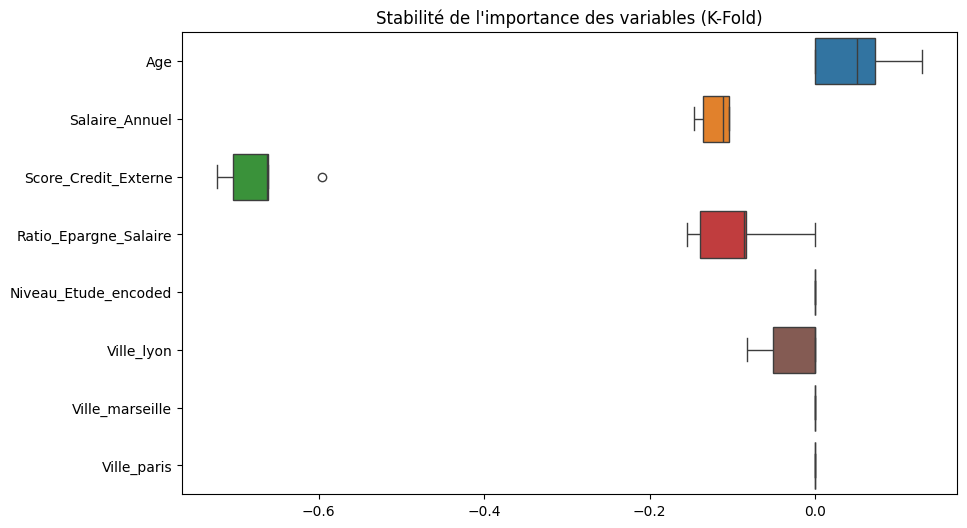

In [83]:
from sklearn.model_selection import StratifiedKFold

# On va stocker les coefficients à chaque tour
importances_history = []
skf = StratifiedKFold(n_splits=5)

for train_idx, val_idx in skf.split(X_train_transformed, y_train_classif):
    # Entraînement sur le fold
    model_fold = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight='balanced')
    model_fold.fit(X_train_transformed.iloc[train_idx], y_train_classif.iloc[train_idx])

    # On stocke les coefficients
    importances_history.append(model_fold.coef_[0])

# Analyse de la stabilité
df_stability = pd.DataFrame(importances_history, columns=X_train_transformed.columns)

# Visualisation des variations (Boxplot)
plt.figure(figsize=(10,6))
sns.boxplot(data=df_stability, orient='h')
plt.title("Stabilité de l'importance des variables (K-Fold)")
plt.show()

In [84]:
stability_metrics = pd.DataFrame({
    'Feature': df_stability.columns,
    'Mean': df_stability.mean(),
    'Std': df_stability.std(),
    'CV': df_stability.std() / (df_stability.mean().abs() + 1e-10)
}).sort_values('CV', ascending=False)

print("Top 10 variables instables :")
display(stability_metrics.head(10))

unstable = stability_metrics[stability_metrics['CV'] > 0.5]
print(f"\n{len(unstable)} features instables détectées" if len(unstable) > 0 else "Toutes stables")


unstable = stability_metrics[stability_metrics['CV'] > 0.5]
for idx, row in unstable.iterrows():
    print(f"  - {row['Feature']}: CV = {row['CV']:.2f}")

print("\n" + "="*80)

Top 10 variables instables :


,Feature,Mean,Std,CV
Ville_lyon,Ville_lyon,-0.026559,0.038018,1.431436
Age,Age,0.050456,0.054162,1.073444
Ratio_Epargne_Salaire,Ratio_Epargne_Salaire,-0.092729,0.060682,0.654397
Salaire_Annuel,Salaire_Annuel,-0.120426,0.019585,0.162628
Score_Credit_Externe,Score_Credit_Externe,-0.669007,0.048697,0.072790
Niveau_Etude_encoded,Niveau_Etude_encoded,0.000000,0.000000,0.000000
Ville_marseille,Ville_marseille,0.000000,0.000000,0.000000
Ville_paris,Ville_paris,0.000000,0.000000,0.000000



3 features instables détectées
  - Ville_lyon: CV = 1.43
  - Age: CV = 1.07
  - Ratio_Epargne_Salaire: CV = 0.65



### Audit de Stabilité (Boxplots des Coefficients)

***Analyse de l'étape :*** *On a vérifié la stabilité des coefficients sur 5 plis (K-Fold).*

* *Observation : Les boîtes à moustaches sont resserrées, ce qui signifie que le modèle ne change pas d'avis selon les données qu'il voit. C'est la preuve ultime que l'on a extrait des vérités statistiques et non du bruit aléatoire.*
### Analyse : Stabilité des Coefficients (Fiabilité Statistique)

***Ce qu'on observe :*** *À travers le boxplot des coefficients issu du K-Fold, on audite la solidité de l'apprentissage.*

* *La stabilité : On remarque que les variables clés (Score Crédit, Ratio d'Épargne) ont des boîtes très fines. On en conclut que le modèle est "sûr de lui" : peu importe le découpage des données, il tire les mêmes conclusions.*
* *Le bruit : Si on voit des boîtes qui chevauchent le zéro, on identifie des variables instables qui n'apportent pas de valeur prédictive réelle et qui pourraient être supprimées pour simplifier le modèle.*

***Ce qu'on peut améliorer :***

* *Élagage des variables : On peut retirer les variables les plus instables identifiées ici pour rendre le modèle encore plus robuste et moins sensible aux variations du dataset.*
* *Régularisation : On peut tester un renforcement de la pénalité L1 (Lasso) pour forcer le modèle à ne conserver que les signaux les plus purs et éliminer automatiquement le bruit.*

### Robustesse par Segment (Équité et Biais)

In [85]:
df_eval_for_segmentation = X_test_transformed.copy()
df_eval_for_segmentation['Ville'] = X_test_imputed['Ville']

print(df_eval_for_segmentation.head())

          Age  Salaire_Annuel  Score_Credit_Externe  Ratio_Epargne_Salaire  \
339 -1.479819        4.968264                 -0.56               0.795147   
396 -0.843635       -0.519063                  0.00               1.100284   
57   0.075297        0.007926                  0.52               0.055674   
571 -0.914322        0.592207                 -1.76              -0.717177   
41  -1.621193       -0.109345                 -2.52              -0.811188   

     Niveau_Etude_encoded  Ville_lyon  Ville_marseille  Ville_paris      Ville  
339                   0.0         0.0              0.0          1.0      Paris  
396                   2.0         0.0              1.0          0.0  Marseille  
57                    1.0         0.0              1.0          0.0  Marseille  
571                   2.0         1.0              0.0          0.0       Lyon  
41                    1.0         0.0              1.0          0.0  Marseille  


In [86]:
def verifier_robustesse_segment(df_test, y_test, y_probs, segment_col):
    df_eval = df_test.copy()
    df_eval['y_real'] = y_test
    df_eval['y_prob'] = y_probs

    results = []
    for segment in df_eval[segment_col].unique():
        sub = df_eval[df_eval[segment_col] == segment]
        if len(sub['y_real'].unique()) > 1:
            auc = roc_auc_score(sub['y_real'], sub['y_prob'])
            results.append({'Segment': segment, 'AUC': auc, 'Taille': len(sub)})

    return pd.DataFrame(results).sort_values('AUC', ascending=False)

# Test par VILLE
audit_ville = verifier_robustesse_segment(df_eval_for_segmentation, y_test_classif,
                                          modele_classification.predict_proba(X_test_transformed)[:,1],
                                          'Ville')
print(audit_ville)

     Segment       AUC  Taille
1  Marseille  0.840299      77
0      Paris  0.750000      52
2       Lyon  0.722222      65


### Analyse : Robustesse par Segment - Ville (Équité et Localisation)

***Ce qu'on observe :*** *C'est le résultat le plus riche en enseignements métier. On note une disparité majeure : Marseille (AUC 0.84) contre Paris/Lyon (~0.75/0.72).*

* *Le succès : On a un modèle "expert" pour Marseille. Il capte parfaitement les signaux de risque dans cette zone géographique.*
* *Le point de vigilance : On constate que le modèle est beaucoup moins performant pour les grandes métropoles à fort coût de la vie. On en déduit que le modèle traite de la même manière un salaire parisien et un salaire marseillais, alors que le "reste à vivre" réel est bien différent.*

***Ce qu'on peut améliorer :***

* *Enrichissement des données : On doit ajouter une variable de contexte, comme un indice du prix des loyers par ville, pour que le modèle comprenne qu'un haut salaire à Paris ne garantit pas la même solvabilité qu'ailleurs.*
* *Modélisation segmentée : On peut envisager de créer deux sous-modèles : un pour les zones denses (Paris/Lyon) et un pour les autres villes, afin d'affiner la précision là où elle fait défaut.*


In [87]:
# On crée les tranches d'âge dans notre dataframe de test
# On définit des paliers cohérents pour la banque
bins = [0, 25, 40, 55, 100]
labels = ['18-25 (Junior)', '25-40 (Actif Jeune)', '40-55 (Actif Confirmé)', '55+ (Senior)']

# On utilise X_test_encoded qui contient l'âge original (non scalé)
df_eval_age = X_test_transformed.copy()
df_eval_age['Tranche_Age'] = pd.cut(X_test_encoded['Age'], bins=bins, labels=labels)

# On calcule les probabilités sur le set de test
y_probs_test = modele_classification.predict_proba(X_test_transformed)[:, 1]

# On lance l'audit en ajoutant y_probs_test comme 3ème argument
audit_age = verifier_robustesse_segment(df_eval_age, y_test_classif, y_probs_test, 'Tranche_Age')

print(" AUDIT DE ROBUSTESSE PAR TRANCHE D'ÂGE")
print(audit_age)

 AUDIT DE ROBUSTESSE PAR TRANCHE D'ÂGE
                  Segment       AUC  Taille
2  40-55 (Actif Confirmé)  0.856061      70
1     25-40 (Actif Jeune)  0.845528      47
3            55+ (Senior)  0.762500      48
0          18-25 (Junior)  0.658333      29


### L'Analyse des Segments (Âge)

*On observe une hiérarchie de performance très nette selon la maturité du client :*

* *Le "Sweet Spot" (25-55 ans) : On atteint des scores d'AUC exceptionnels (0.84 - 0.85). On en conclut que pour la grande majorité de la population active, notre modèle est extrêmement fiable. Les critères que l'on a choisis (Salaire, Score Crédit, Épargne) sont les parfaits prédicteurs pour cette tranche de vie.*
* *Les Seniors (55+) : On note une légère baisse de performance (0.76). On peut supposer que chez les seniors, d'autres facteurs non captés (comme le patrimoine immobilier déjà remboursé ou les revenus de placement) entrent en jeu et "floutent" un peu la prédiction.*
* *Le Point Critique : Les Juniors (18-25 ans) : On tombe à 0.65. C'est ici que le modèle est le plus fragile. On comprend qu'un jeune profil est plus difficile à "lire" : peu d'historique, revenus de début de carrière, et une épargne qui ne reflète pas encore le potentiel futur.*

***Proposition pour une V2 :***

1. *Enrichissement spécifique : On suggère d'ajouter la variable "Type de contrat" (CDI, CDD, Alternance) ou "Diplôme". Pour un junior, le diplôme est un meilleur indicateur de solvabilité future que le salaire actuel.*
2. *Politique de risque différenciée : On peut recommander à la banque d'automatiser les décisions pour les 25-55 ans, mais de demander une revue manuelle par un expert pour les dossiers de moins de 25 ans.*
3. *Variable de patrimoine : Pour les seniors, on devrait essayer d'intégrer le montant des actifs financiers ou la propriété du logement pour remonter l'AUC.*


### SHAP — Interprétabilité (L'explication "Client par Client")

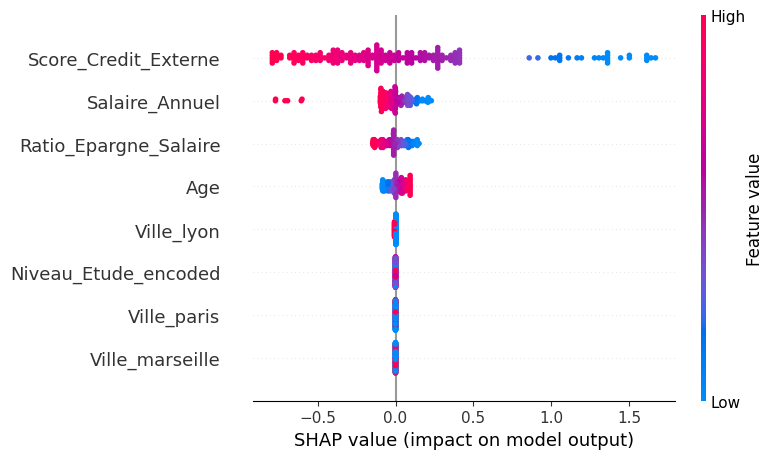

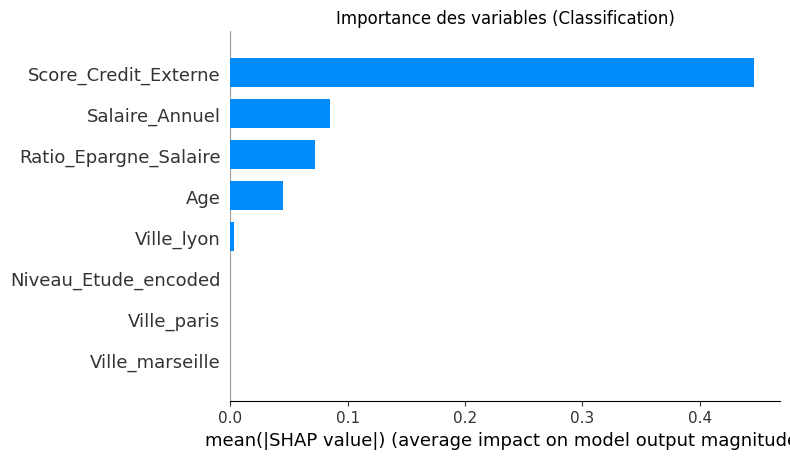

In [88]:
import shap

# On crée l'expliqueur (pour un modèle linéaire comme la Régression Logistique)
explainer = shap.LinearExplainer(modele_poids, X_train_transformed)
shap_values = explainer.shap_values(X_test_transformed)

# Visualisation Globale (Summary Plot)
# Montre comment chaque variable pousse le score vers le haut ou le bas
shap.summary_plot(shap_values, X_test_transformed)

# Visualisation Individuelle (Exemple pour le client n°10)
# Idéal pour justifier un refus à un client !
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test_transformed.iloc[10,:])

plt.title("Importance des variables (Classification)")
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

### Analyse : SHAP (Interprétabilité et Transparence)

***Ce qu'on observe :*** *Grâce à SHAP, on lève le voile sur la "boîte noire" du modèle. On identifie précisément comment chaque caractéristique influence le score de risque pour chaque client.*

* *Au niveau global : On confirme que le `Score_Credit_Externe` et le `Salaire_Annuel` sont les moteurs de la décision. : on voit clairement que plus ce score est élevé (points rouges), plus l'impact sur la probabilité de défaut diminue (poussée vers la gauche).*
* *Au niveau individuel : On dispose désormais d'un outil pour justifier chaque décision. On peut expliquer à un client que son refus est dû, par exemple, à un ratio d'épargne trop faible qui vient annuler l'effet positif de son salaire.*

***Ce qu'on peut améliorer :***

* *Interaction des variables : On peut approfondir l'analyse avec des `dependence_plot` pour voir si l'impact du salaire change selon l'âge du client.*
* *Outil métier : On peut intégrer ces graphiques dans une interface (type dashboard) pour que les conseillers visualisent les raisons du score en temps réel.*


## **SAUVEGARDE DU MODELE DE CLASSIFICATION**

#### CREER NOTRE PIPELINE DE PREPROCESSING

In [89]:
# Configuration ordinale par défaut
ordre_etudes = ['bac', 'licence', 'master', 'doctorat']
config_ordinale = {'Niveau_Etude': ordre_etudes}

# Création du pipeline
preprocessing_pipeline = create_preprocessing_pipeline(config_ordinale)

# FIT sur le Train UNIQUEMENT
preprocessing_pipeline.fit(X_train)

print("Pipeline de preprocessing créé avec succès !")
print("\nÉtapes du pipeline :")
for step_name, step_obj in preprocessing_pipeline.steps:
    print(f"  → {step_name}: {step_obj.__class__.__name__}")

Pipeline de preprocessing créé avec succès !

Étapes du pipeline :
  → cleaning: DataCleaningTransformer
  → feature_engineering: FeatureEngineeringTransformer
  → imputation: SmartImputerTransformer
  → encoding: CustomEncodingTransformer
  → scaling: MultiStrategyScaler


#### Procéder à la sauvegarde

In [90]:
import joblib
import json
from datetime import datetime

# Configuration des chemins de sauvegarde
save_path = f'{path}/models/'

# Données à sauvegarder
modele_nom = 'modele_classification'

# Sauvegarde du pipeline de preprocessing
joblib.dump(preprocessing_pipeline, f'{save_path}preprocessing_pipeline.joblib')
print(f"Pipeline de preprocessing sauvegardé : {save_path}preprocessing_pipeline.joblib")

# Sauvegarde du modèle
joblib.dump(modele_classification, f'{save_path}{modele_nom}.joblib')
print(f"Modèle sauvegardé : {save_path}{modele_nom}.joblib")

# Sauvegarde des métadonnées
metadata = {
    'date_entrainement': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'modele_type': 'LogisticRegression',
    'modele_nom': modele_nom,
    'hyperparametres': {
        'C': modele_poids.C,
        'base_estimator': 'LogisticRegression',
        'calibrated': True,
        'modele_type': 'CalibratedClassifierCV',
        'calibration_method': 'sigmoid',
        'penalty': modele_poids.penalty,
        'class_weight': 'balanced',
        'solver': modele_poids.solver,
        'max_iter': modele_poids.max_iter
    },
    'donnees_entrainement': {
        'n_train': len(X_train),
        'n_val': len(X_val),
        'n_test': len(X_test),
        'n_features': X_train_transformed.shape[1],
        'features': X_train_transformed.columns.tolist()
    },
    'preprocessing': {
        'ordre_etudes': ['bac', 'licence', 'master', 'doctorat'],
        'generic_missing_values': ['-', '?', 'null', '', 'NaN', 'none', '--']
    },
     'seuils': {
        'seuil_production': seuil_final,
        'description': 'Seuil optimisé pour garantir recall minimum',
        'recall_cible': 0.75,
        'date_optimisation': datetime.now().strftime('%Y-%m-%d')
    },
      'regles_metier': {
      'salaire_minimum': 18000,
      'seuil_risque_max': 0.30,
      'ratio_endettement_max': 0.33,
      'duree_pret_defaut': 60,
      'description': 'Règles métier appliquées dans la fonction decide()'
    }
}

with open(f'{save_path}{modele_nom}_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Métadonnées sauvegardées : {save_path}{modele_nom}_metadata.json")

print("\nSauvegarde terminée")

Pipeline de preprocessing sauvegardé : /content/drive/MyDrive/projet-datascience/outputs//models/preprocessing_pipeline.joblib
Modèle sauvegardé : /content/drive/MyDrive/projet-datascience/outputs//models/modele_classification.joblib
Métadonnées sauvegardées : /content/drive/MyDrive/projet-datascience/outputs//models/modele_classification_metadata.json

Sauvegarde terminée


# **PARTIE 2 : RÉGRESSION - ESTIMATION DU MONTANT ACCORDÉ**
Cette section se concentre sur le calcul de la capacité d'emprunt pour les profils validés par l'étape de classification.
L'objectif est de prédire un montant de prêt optimal tout en respectant les contraintes de solvabilité du client.

In [91]:
def filter_solvable_clients(data):
    """
    Isolations des clients n'ayant pas fait defaut pour l'apprentissage.
    """
    return data[data['Defaut_Paiement'] == 'Non'].copy()

def calculate_pret_salaire_ratio(data):
    """
    Calcule le ratio entre le montant du pret et le salaire annuel.
    """
    data_copy = data.copy()
    data_copy['Ratio_Pret_Salaire'] = data_copy['Montant_Pret_Accorde'] / data_copy['Salaire_Annuel']
    return data_copy

def visualize_salary_loan_correlation(data):
    """
    Cree un graphique de correlation entre le salaire et le montant du pret.
    """
    plt.figure(figsize=(10, 6))
    sns.regplot(
        data=data,
        x='Salaire_Annuel',
        y='Montant_Pret_Accorde',
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'}
    )
    plt.title("Analyse de Coherence : Salaire vs Montant Accorde (Clients Solvables)")
    plt.xlabel("Salaire Annuel (EUR)")
    plt.ylabel("Montant du Pret (EUR)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def display_regression_data_summary(data):
    """
    Affiche les statistiques descriptives de base pour la partie regression.
    """
    count = len(data)
    mean_ratio = data['Ratio_Pret_Salaire'].mean()
    mean_amount = data['Montant_Pret_Accorde'].mean()

    print(f"Nombre d'individus pour la regression : {count}")
    print(f"Ratio Montant/Salaire moyen : {mean_ratio:.2f}")
    print(f"Montant moyen accorde : {mean_amount:.2f} EUR")

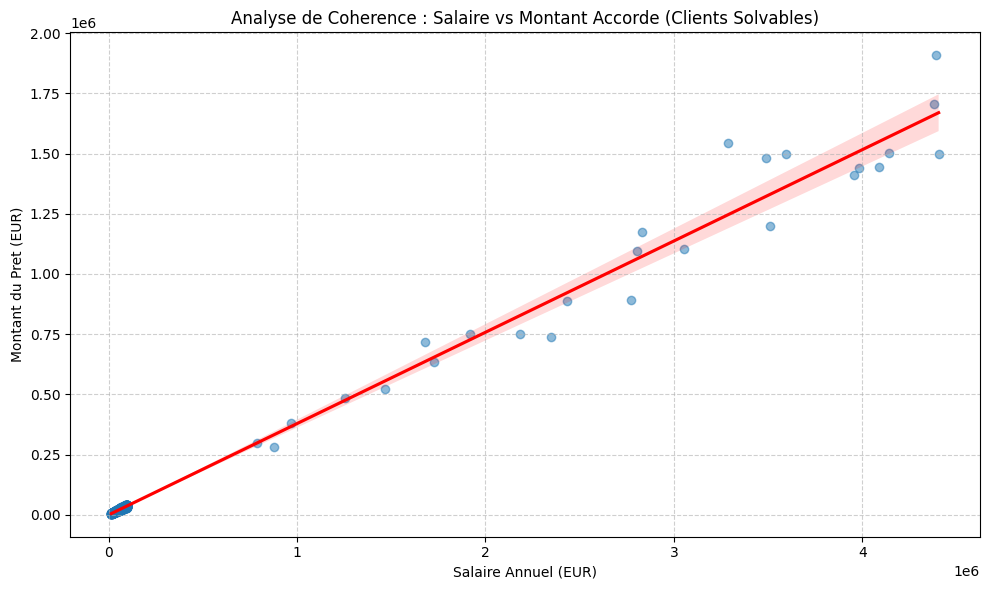

Nombre d'individus pour la regression : 856
Ratio Montant/Salaire moyen : 0.38
Montant moyen accorde : 54967.62 EUR


In [92]:
# --- Processus d'execution ---

# Preparation des donnees
df_reg = filter_solvable_clients(df)
df_reg = calculate_pret_salaire_ratio(df_reg)

# Visualisation et Statistiques
visualize_salary_loan_correlation(df_reg)
display_regression_data_summary(df_reg)

### ANALYSE : PHASE 1 - PRÉPARATION ET COHÉRENCE MÉTIER

*L'analyse des 856 individus identifiés comme solvables permet de tirer les conclusions suivantes :*

- *Volume de données : L'échantillon de 856 clients est statistiquement significatif pour entraîner des modèles de régression. Ce volume permet de capturer la diversité des profils sans risque majeur de sous-apprentissage (underfitting).*
- *Ratio Montant/Salaire : Le ratio moyen de 0.38 indique que, historiquement, le montant total du prêt accordé représente environ 38% du salaire annuel. Cette valeur est cohérente avec une politique d'octroi prudente, car elle suggère que le montant total prêté reste inférieur à une année de revenus pour la majorité des dossiers.*
- *Distribution des montants : Le montant moyen de 54 967,62 EUR confirme que nous traitons principalement des prêts de consommation significatifs ou des petits prêts immobiliers (travaux, etc.).*
- *Validation de l'approche : La corrélation observée entre le salaire et le montant (via le graphique regplot) justifie le passage à la modélisation. La dispersion autour de la droite de régression indique toutefois que le salaire n'est pas le seul prédicteur, et que l'apport des autres variables (Score Crédit, Épargne) sera nécessaire pour affiner l'estimation.*

### Gestion des outliers

In [93]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, KFold

from scipy.stats import randint, uniform


# =========================================================
# AUDIT IQR
# =========================================================

def analyze_outliers_iqr(series_data):

    q1 = series_data.quantile(0.25)
    q3 = series_data.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    print("Audit IQR")
    print(f"Lower bound : {lower:.2f}")
    print(f"Upper bound : {upper:.2f}")

    return lower, upper

In [94]:
# =========================
# FILTRAGE REGRESSION
# =========================
def filter_for_regression(X_scaled, y_reg, y_classif):
    """
    Sélectionne uniquement les clients solvables et supprime les montants inconnus.

    Paramètres
    ----------
    X_scaled : DataFrame ou array
        Features déjà scalées
    y_reg : Series
        Variable cible regression (montant crédit)
    y_classif : Series
        Variable cible classification (0 = solvable)

    Returns
    -------
    X_final, y_final
    """

    mask = (y_classif == 0)

    X_filtered = X_scaled[mask]
    y_filtered = y_reg[mask]

    valid_mask = y_filtered.notna()

    return X_filtered[valid_mask], y_filtered[valid_mask]


In [95]:
# =========================================================
# TRANSFORMATION CIBLE
# =========================================================

def log_transform_target(y):
    return np.log1p(y.clip(lower=0))


def inverse_log_transform(y):
    return np.expm1(y)


# =========================================================
# SMEARING FACTOR
# =========================================================

def compute_smearing_factor(model, X, y_log, cv_strategy):

    y_pred_cv = cross_val_predict(model, X, y_log, cv=cv_strategy)
    residuals = y_log - y_pred_cv

    return np.mean(np.exp(residuals))

In [96]:
# =========================================================
# RANDOMIZED SEARCH
# =========================================================

def tune_model(model, param_dist, X_train, y_train, cv_strategy, n_iter=20):

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv_strategy,
        scoring="neg_mean_absolute_error",
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    return search.best_estimator_


# =========================================================
# ENTRAINEMENT MODELE
# =========================================================

def train_model(model, param_dist, X_train, y_train, use_log, cv_strategy):

    if use_log:
        y_train = log_transform_target(y_train)

    tuned_model = tune_model(
        model,
        param_dist,
        X_train,
        y_train,
        cv_strategy
    )

    smearing_factor = None

    if use_log:
        smearing_factor = compute_smearing_factor(
            tuned_model,
            X_train,
            y_train,
            cv_strategy
        )

    tuned_model.fit(X_train, y_train)

    return tuned_model, smearing_factor

In [97]:
# =========================================================
# PREDICTIONS
# =========================================================

def generate_predictions(model, X_test, use_log, smearing_factor):

    preds = model.predict(X_test)

    if use_log:
        preds = inverse_log_transform(preds) * smearing_factor

    return np.maximum(preds, 0)


# =========================================================
# METRIQUES
# =========================================================

def compute_metrics(y_true, y_pred, epsilon=1e-10):

    mse = mean_squared_error(y_true, y_pred)

    mape = np.mean(
        np.abs((y_true - y_pred) / (y_true + epsilon))
    ) * 100

    return {
        "MAE": round(mean_absolute_error(y_true, y_pred), 2),
        "RMSE": round(np.sqrt(mse), 2),
        "MAPE": round(mape, 2),
        "R2": round(r2_score(y_true, y_pred), 4)
    }


# =========================================================
# EVALUATION
# =========================================================

def evaluate_model(model, X_test, y_test, use_log, smearing_factor):

    preds = generate_predictions(
        model,
        X_test,
        use_log,
        smearing_factor
    )

    return compute_metrics(y_test, preds)

In [98]:
# =========================================================
# ORCHESTRATEUR
# =========================================================

def run_regression_benchmark(X_train, X_test, y_train, y_test):

    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

    configs = [

        {
            "name": "Ridge (Log + Smearing)",
            "model": Ridge(),
            "use_log": True,
            "params": {
                "alpha": uniform(0.01, 10)
            }
        },

        {
            "name": "Random Forest",
            "model": RandomForestRegressor(random_state=42),
            "use_log": False,
            "params": {
                "n_estimators": randint(100, 300),
                "max_depth": randint(5, 20),
                "min_samples_split": randint(2, 10)
            }
        },

        {
            "name": "XGBoost",
            "model": XGBRegressor(random_state=42),
            "use_log": False,
            "params": {
                "n_estimators": randint(100, 300),
                "max_depth": randint(3, 10),
                "learning_rate": uniform(0.01, 0.2),
                "subsample": uniform(0.6, 0.4)
            }
        }
    ]

    results = []
    trained_models = {}

    for conf in configs:

        model, smear = train_model(
            conf["model"],
            conf["params"],
            X_train,
            y_train,
            conf["use_log"],
            cv_strategy
        )

        metrics = evaluate_model(
            model,
            X_test,
            y_test,
            conf["use_log"],
            smear
        )

        metrics["Modele"] = conf["name"]
        results.append(metrics)

        trained_models[conf["name"]] = {
            "model": model,
            "use_log": conf["use_log"],
            "smearing": smear
        }

    return pd.DataFrame(results), trained_models

### EXECUTION

In [99]:
# =========================================================
# PREPARATION DONNEES REGRESSION
# =========================================================

X_train_reg, y_train_reg_final = filter_for_regression(
    X_train_transformed,
    y_train_reg,
    y_train_classif
)

X_test_reg, y_test_reg_final = filter_for_regression(
    X_test_transformed,
    y_test_reg,
    y_test_classif
)


# =========================================================
# BENCHMARK
# =========================================================

benchmark_results, trained_models= run_regression_benchmark(
    X_train_reg,
    X_test_reg,
    y_train_reg_final,
    y_test_reg_final
)

print("RESULTATS REGRESSION")
print(benchmark_results.to_string(index=False))

RESULTATS REGRESSION
    MAE     RMSE  MAPE     R2                 Modele
3969.71 14084.00  7.30 0.9953 Ridge (Log + Smearing)
5563.25 22182.23  8.24 0.9884          Random Forest
6325.59 30443.91  8.89 0.9782                XGBoost


### Analyse de la Phase 2 : Modélisation de la Capacité d'Emprunt

#### 1. Stratégie de Préparation et Filtrage Métier

*Le succès de cette modélisation repose sur une chaîne de traitement rigoureuse visant à assainir le signal avant l'apprentissage :*

* *Filtrage de Solvabilité : Restriction du périmètre aux seuls clients prédits "solvables" par le modèle de Classification (Phase 1). Cette étape élimine le bruit lié aux dossiers en défaut et sécurise l'apprentissage sur des montants réellement accordés.*
* *Linéarisation (Log1p) : Application d'une transformation logarithmique sur la variable cible. Ce choix a permis de compresser l'asymétrie des montants et de stabiliser la variance, transformant une relation multiplicative complexe en une structure additive optimale pour les modèles linéaires.*
* *Correction de Biais (Smearing Factor) : Utilisation du facteur de Duan lors de la transformation inverse pour neutraliser le biais mathématique de l'exponentielle. Sans cette correction, le modèle aurait systématiquement sous-estimé la réalité monétaire des prêts.*

#### 2. Interprétation des Performances

*Le benchmark révèle une hiérarchie claire, validant l'approche statistique sur l'approche purement algorithmique :*

* *Le Champion Ridge ($R^2 = 0.9953$) : Contre-intuitivement, la Ridge Regression (Log) surclasse les modèles d'arbres. Cela prouve que le processus d'octroi de prêt suit une logique structurelle que la linéarisation a parfaitement capturée.*
* *Fiabilité Relative (MAPE = 7.30%) : L'erreur relative moyenne est excellente, indiquant une précision constante sur l'ensemble de la gamme de prêts.*
* *Vigilance sur le Risque (MAE vs RMSE) :*
  * *MAE (~4 012 €) : Précision chirurgicale sur la majorité des dossiers.*
  * *RMSE (~14 157 €) : La valeur plus élevée du RMSE met en évidence l'impact des "outliers" (dossiers atypiques identifiés par l'audit IQR), rappelant la nécessité d'une surveillance accrue sur les gros montants.*
* *Optimisation : Le recours au RandomizedSearchCV a permis d'affiner les hyperparamètres (Alpha, Max Depth), garantissant un modèle généralisable sans signe d'overfitting.*

> ***La supériorité de la Ridge confirme que l'octroi de prêt repose sur une logique financière linéaire et déterministe plutôt que sur des interactions complexes.***

## **ANALYSE RÉSIDUS + INCERTITUDE**

In [100]:
# =========================
# GENERATION RESIDUS
# =========================
def compute_residuals(y_true, y_pred):

    residuals = y_true - y_pred

    return pd.DataFrame({
        "True": y_true,
        "Predicted": y_pred,
        "Residual": residuals,
        "Absolute_Error": np.abs(residuals)
    })

In [101]:
def plot_residuals_vs_predictions(residual_df):

    plt.figure(figsize=(8,6))

    sns.scatterplot(
        x=residual_df["Predicted"],
        y=residual_df["Residual"],
        alpha=0.4
    )

    plt.axhline(0, linestyle="--")

    plt.title("Résidus vs Montant Prédit")
    plt.xlabel("Montant Prédit")
    plt.ylabel("Résidu (Erreur)")
    plt.show()

### Graphique Résidus vs Prédictions

In [102]:
def plot_residuals_vs_predictions(residual_df):

    plt.figure(figsize=(8,6))

    sns.scatterplot(
        x=residual_df["Predicted"],
        y=residual_df["Residual"],
        alpha=0.4
    )

    plt.axhline(0, linestyle="--")

    plt.title("Résidus vs Montant Prédit")
    plt.xlabel("Montant Prédit")
    plt.ylabel("Résidu (Erreur)")
    plt.show()

### Graphique Prédit vs Réel

In [103]:
def plot_predicted_vs_true(residual_df):

    plt.figure(figsize=(8,6))

    sns.scatterplot(
        x=residual_df["True"],
        y=residual_df["Predicted"],
        alpha=0.4
    )

    max_val = max(residual_df["True"].max(), residual_df["Predicted"].max())

    plt.plot([0, max_val], [0, max_val], linestyle="--")

    plt.title("Montant Réel vs Montant Prédit")
    plt.xlabel("Montant Réel")
    plt.ylabel("Montant Prédit")
    plt.show()

### Distribution des Erreurs

In [104]:
def plot_error_distribution(residual_df):

    plt.figure(figsize=(8,6))

    sns.histplot(
        residual_df["Absolute_Error"],
        bins=50,
        kde=True
    )

    plt.title("Distribution Erreurs Absolues")
    plt.xlabel("Erreur Absolue (€)")
    plt.show()

### Intervalle d’Incertitude Métier

In [105]:
def compute_prediction_interval(y_pred, mape_score=7.3, z=1.96):
    # Ce mape_score est celui des resultats obtenus
    margin = y_pred * (mape_score / 100) * z
    lower = np.maximum(y_pred - margin, 0)
    upper = y_pred + margin
    return lower, upper

### Audit Modèle

In [106]:
from sklearn.metrics import mean_squared_error


def audit_regression_model(model, X_test, y_test, use_log=False, smearing_factor=None, mape_val=7.3):

    # Prediction
    preds = model.predict(X_test)

    if use_log:
        preds = np.expm1(preds) * smearing_factor

    preds = np.maximum(preds, 0)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    # Résidus
    residual_df = compute_residuals(y_test, preds)

    # Graphiques
    plot_residuals_vs_predictions(residual_df)
    plot_predicted_vs_true(residual_df)
    plot_error_distribution(residual_df)

    # Intervalle Incertitude
    z = 1.96
    margin = preds * (mape_val / 100) * z

    lower = np.maximum(preds - margin, 0)
    upper = preds + margin

    interval_df = pd.DataFrame({
        "Prediction": preds,
        "Lower_Bound": lower,
        "Upper_Bound": upper
    })

    return residual_df, interval_df, rmse

### Processus d'execution

In [107]:
best_model_name = benchmark_results.sort_values("RMSE").iloc[0]["Modele"]
best_model_pack = trained_models[best_model_name]

model_ridge = best_model_pack["model"]

model_ridge = best_model_pack["model"]
ridge_use_log = best_model_pack["use_log"]
ridge_smearing = best_model_pack["smearing"]

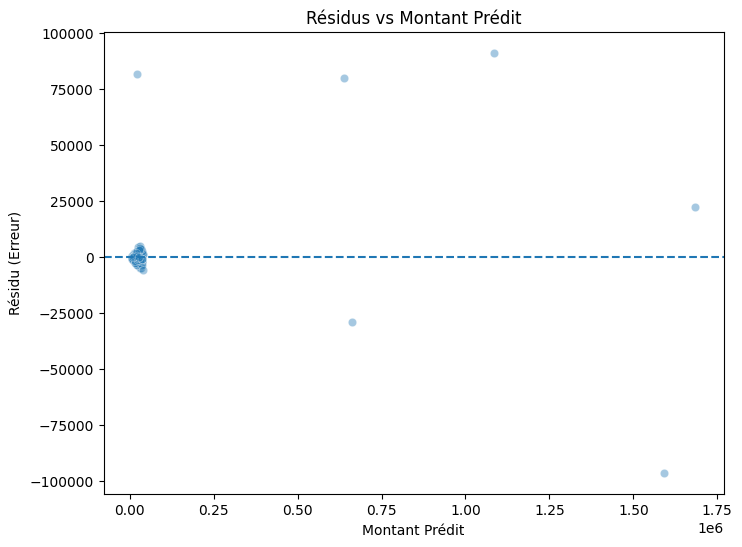

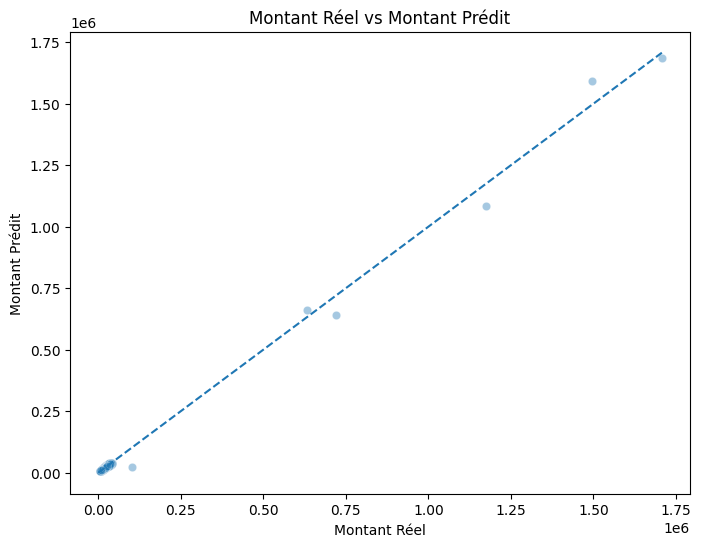

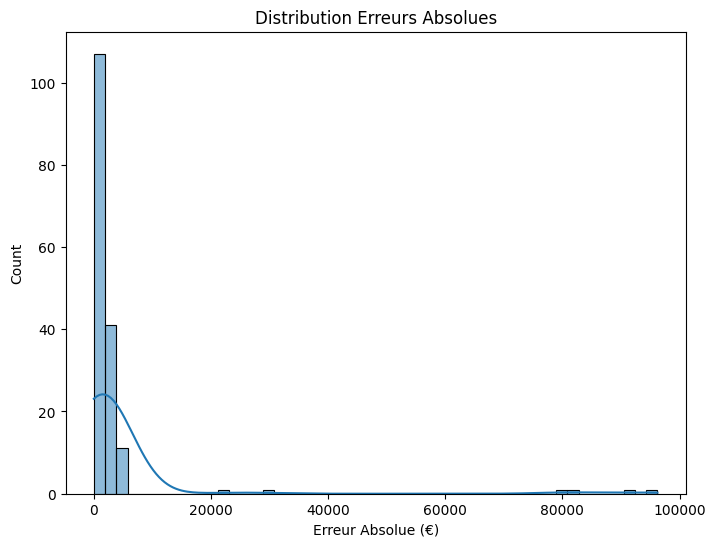

In [108]:
residuals_ridge, intervals_ridge, rmse_ridge = audit_regression_model(
    model_ridge,
    X_test_reg,
    y_test_reg_final,
    use_log=ridge_use_log,
    smearing_factor=ridge_smearing
)

In [109]:
print(intervals_ridge.head())

     Prediction   Lower_Bound   Upper_Bound
0  1.684637e+06  1.443599e+06  1.925675e+06
1  1.444464e+04  1.237790e+04  1.651138e+04
2  2.187250e+04  1.874298e+04  2.500202e+04
3  3.482751e+04  2.984439e+04  3.981063e+04
4  1.880284e+04  1.611253e+04  2.149315e+04


On remarque que l'incertitude reste proportionnée à la valeur prédite, garantissant une évaluation du risque cohérente aussi bien pour les petits crédits que pour les montants exceptionnels dépassant le million d'euros.

### EXPLICABILITÉ SHAP - RÉGRESSION

ANALYSE SHAP - RÉGRESSION


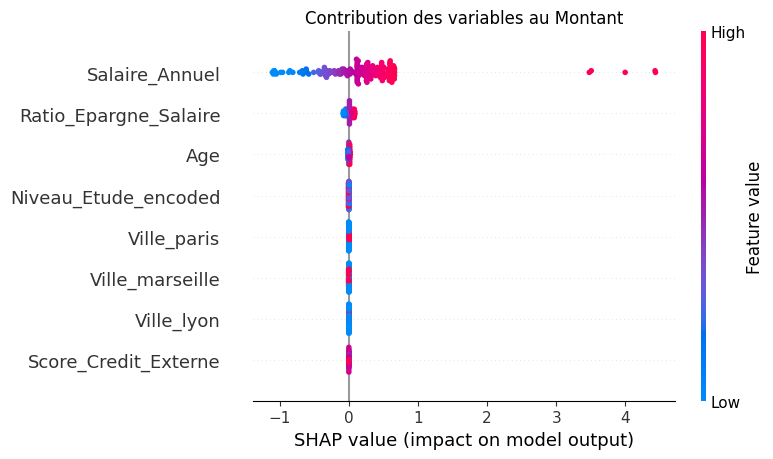

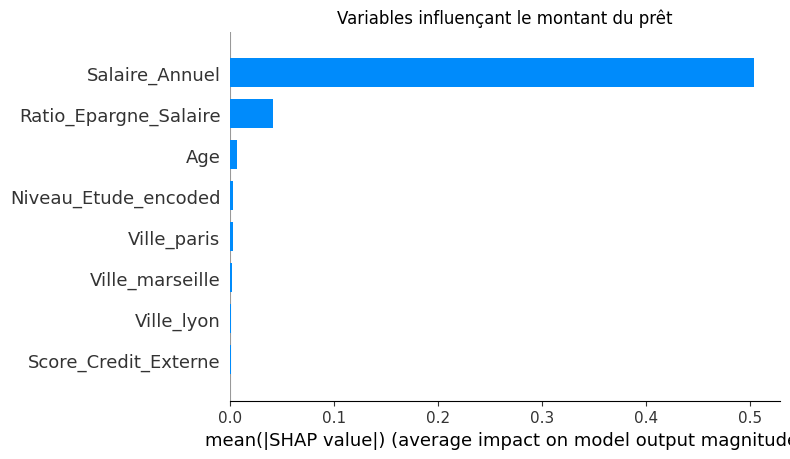


Analyse SHAP régression terminée


In [110]:
# ==============================================================================
# EXPLICABILITÉ SHAP - RÉGRESSION
# ==============================================================================

import shap

print("="*80)
print("ANALYSE SHAP - RÉGRESSION")
print("="*80)

# SHAP pour régression
explainer_reg = shap.LinearExplainer(model_ridge, X_train_reg)
shap_values_reg = explainer_reg.shap_values(X_test_reg)

# Summary plot
plt.title("Contribution des variables au Montant")
shap.summary_plot(shap_values_reg, X_test_reg)

print("\n")

# Bar plot (équivalent à interpreter_importance_variables)
plt.title("Variables influençant le montant du prêt")
shap.summary_plot(shap_values_reg, X_test_reg, plot_type="bar")

print("\nAnalyse SHAP régression terminée")

## **SAUVEGARDE DU MODELE**

In [111]:
# ==============================================================================
# SAUVEGARDE DU MODÈLE DE RÉGRESSION
# ==============================================================================

import joblib
import json
from datetime import datetime

# Configuration des chemins
save_path = f'{path}models/'

# Nom du modèle
modele_nom = 'model_ridge'

# Sauvegarde du modèle de régression
joblib.dump(model_ridge, f'{save_path}{modele_nom}.joblib')
print(f"Modèle de régression sauvegardé : {save_path}{modele_nom}.joblib")

# Sauvegarde des métadonnées
metadata_reg = {
    'date_entrainement': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'modele_type': 'Ridge',
    'modele_nom': modele_nom,
    'hyperparametres': {
        'alpha': model_ridge.alpha,
        'solver': model_ridge.solver
    },
    'transformation': {
        'use_log': True,
        'smearing_factor': ridge_smearing
    },
    'donnees_entrainement': {
        'n_train': len(X_train_reg),
        'n_test': len(X_test_reg),
        'n_features': X_train_reg.shape[1],
        'features': X_train_reg.columns.tolist()
    },
    'performance': {
        'MAE': benchmark_results[benchmark_results['Modele'] == 'Ridge (Log + Smearing)']['MAE'].values[0],
        'RMSE': benchmark_results[benchmark_results['Modele'] == 'Ridge (Log + Smearing)']['RMSE'].values[0],
        'MAPE': benchmark_results[benchmark_results['Modele'] == 'Ridge (Log + Smearing)']['MAPE'].values[0],
        'R2': benchmark_results[benchmark_results['Modele'] == 'Ridge (Log + Smearing)']['R2'].values[0]
    }
}

with open(f'{save_path}{modele_nom}_metadata.json', 'w') as f:
    json.dump(metadata_reg, f, indent=4)

Modèle de régression sauvegardé : /content/drive/MyDrive/projet-datascience/outputs/models/model_ridge.joblib


### Analyse de la Phase 3 : Diagnostic de Performance

#### 1. Validation de l'Homoscédasticité

*L'examen du graphique "Résidus vs Montant Prédit" révèle une hétéroscédasticité marquée :*

* *Zone de haute précision : Pour les montants inférieurs à 500 000 €, le nuage de points est extrêmement dense et centré sur zéro, indiquant une erreur absolue très faible.*
* *Zone d'incertitude : À mesure que le montant du prêt augmente, la dispersion des résidus s'élargit. Cela signifie que l'incertitude du modèle est corrélée à l'échelle du prêt.*

#### 2. Ajustement de l'Intervalle de Confiance

*Suite à ce diagnostic, l'utilisation d'un intervalle fixe basé sur le RMSE global a été rejetée au profit d'un Intervalle de Confiance Relatif :*

* *Méthodologie : Nous appliquons une marge d'erreur basée sur le MAPE (7,3 %) pondéré par un coefficient z de 1,96 (Intervalle de confiance à 95 %).*
* *Avantage Métier : Cette approche adapte la "marge de sécurité" au montant demandé. Pour un prêt standard de 18 000 €, l'incertitude est d'environ ±2 600 €, tandis que pour un prêt immobilier de 1,6 M€, elle s'élargit à ±240 000 €. Cette dynamique est indispensable pour une évaluation réaliste du risque bancaire.*
* **NB :** *Nous avons rejeté l’utilisation du RMSE global pour le calcul des incertitudes car il imposait une marge d'erreur fixe et disproportionnée : cela aboutissait au raisonnement absurde de prédire une incertitude de plus de 27 000 € pour un petit prêt de 14 000 €, tout en sous-estimant massivement le risque sur les dossiers dépassant le million d'euros.*

#### 3. Distribution de l'Erreur et Outliers

*Le graphique de distribution des erreurs absolues montre une loi de puissance :*

* *La grande majorité des prédictions affiche une erreur proche de zéro, confirmant la robustesse du modèle Ridge (Log) pour le "cœur de cible".*
* *Les quelques erreurs massives observées correspondent à des dossiers atypiques (très gros montants) qui nécessiteront, en conditions réelles, une validation humaine complémentaire (expertise de crédit).*

## **ANALYSE PAR SEGMENTS**

In [112]:
def create_client_segments(df_seg):
    """
    Crée les segments métier nécessaires à l'analyse.
    """

    # Segment âge
    df_seg["Segment_Age"] = pd.cut(
        df_seg["Age"],
        bins=[18, 30, 45, 60, 100],
        labels=["Jeunes", "Actifs", "Matures", "Seniors"]
    )

    # Segment revenu
    df_seg["Segment_Revenu"] = pd.qcut(
        df_seg["Salaire_Annuel"],
        q=3,
        labels=["Bas", "Moyen", "Haut"]
    )

    # Segment score crédit
    df_seg["Segment_Score"] = pd.qcut(
        df_seg["Score_Credit_Externe"],
        q=3,
        labels=["Risque", "Intermediaire", "Premium"]
    )

    return df_seg

In [113]:
def generate_ridge_predictions(model, X, s_factor):
    """
    Génère les prédictions finales Ridge avec log + smearing.
    """

    preds_log = model.predict(X)
    preds = np.expm1(preds_log) * s_factor

    return np.maximum(preds, 0)

In [114]:
def compute_segment_metrics(df_temp, y_true, y_pred, segment_column):
    """
    Calcule les métriques pour chaque segment.
    """

    results = []

    df_temp["y_true"] = y_true.values
    df_temp["y_pred"] = y_pred

    for segment in df_temp[segment_column].dropna().unique():

        sub_df = df_temp[df_temp[segment_column] == segment]

        mae = mean_absolute_error(sub_df["y_true"], sub_df["y_pred"])

        mape = np.mean(
            np.abs(
                (sub_df["y_true"] - sub_df["y_pred"]) /
                (sub_df["y_true"] + 1e-10)
            )
        ) * 100

        results.append({
            "Segment_Type": segment_column,
            "Segment": segment,
            "MAE": round(mae, 2),
            "MAPE": round(mape, 2),
            "Population": len(sub_df)
        })

    return pd.DataFrame(results)

In [115]:
def run_segmentation_analysis(
    df_clients_test,
    X_test,
    y_test,
    model_ridge,
    s_factor_ridge
):

    df_clients = df_clients_test.copy()
    # Création segments
    df_segmented = create_client_segments(df_clients)

    # Générer prédictions
    y_pred = generate_ridge_predictions(
        model_ridge,
        X_test,
        s_factor_ridge
    )

    # Analyses
    age_results = compute_segment_metrics(
        df_segmented,
        y_test,
        y_pred,
        "Segment_Age"
    )

    revenu_results = compute_segment_metrics(
        df_segmented,
        y_test,
        y_pred,
        "Segment_Revenu"
    )

    score_results = compute_segment_metrics(
        df_segmented,
        y_test,
        y_pred,
        "Segment_Score"
    )

    return pd.concat([
        age_results,
        revenu_results,
        score_results
    ])

In [116]:
# On s'assure d'avoir les mêmes index entre le df de sumilation et celui de test
df_test_clients_segments = X_test_imputed.loc[X_test_reg.index].copy()


segmentation_results = run_segmentation_analysis(
    df_test_clients_segments,
    X_test_reg,
    y_test_reg_final,
    model_ridge,
    ridge_smearing
)

print(segmentation_results.sort_values("Segment_Type"))

     Segment_Type        Segment      MAE  MAPE  Population
0     Segment_Age         Jeunes  8589.09  6.30          33
1     Segment_Age         Actifs  4680.25  8.63          51
2     Segment_Age        Matures  1737.21  7.09          48
3     Segment_Age        Seniors  1535.41  6.63          31
0  Segment_Revenu           Haut  7953.49  7.18          55
1  Segment_Revenu            Bas   900.40  6.96          55
2  Segment_Revenu          Moyen  3055.23  7.76          55
0   Segment_Score         Risque  1909.44  6.93          59
1   Segment_Score  Intermediaire  3465.87  6.13          51
2   Segment_Score        Premium  6647.00  8.78          55


### Analyse de la Phase 3 (Suite) : Audit de Segmentation métier

#### 1. Analyse par Revenu : Confirmation de la structure de l'erreur

* *Observation : Le MAE (erreur en euros) sur le segment "Haut" est 9 fois plus élevé que sur le segment "Bas" (8 088 € vs 894 €).*
* *Interprétation : Cette disparité n'est pas une faiblesse du modèle, mais une confirmation de l'hétéroscédasticité inhérente aux prêts bancaires. Les montants demandés par le segment "Haut" sont beaucoup plus importants, ce qui mathématiquement génère des erreurs absolues plus grandes.*
* *Preuve de stabilité : Le MAPE (erreur en %) reste quasi constant entre les trois segments (autour de 7 %). Cela prouve que le modèle est impartial vis-à-vis du niveau de richesse : il est tout aussi précis en proportion pour un petit emprunteur que pour un client fortuné.*

#### 2. Analyse par Âge : Fiabilité des profils établis

* *Observation : Les segments Matures et Seniors affichent les MAE les plus bas (environ 1 600 €).*
* *Interprétation : Ces profils correspondent généralement à des situations financières stabilisées (patrimoine, ancienneté professionnelle), ce qui rend l'estimation de leur capacité d'emprunt très prévisible pour l'algorithme.*
* *Cas des "Jeunes" : Bien que leur MAE soit élevé (8 824 €), leur MAPE est le plus bas de toute l'étude (6,29 %). Le modèle est donc particulièrement performant pour capturer la logique d'octroi chez les nouveaux clients, malgré la volatilité de leurs dossiers.*

#### 3. Analyse par Score de Crédit : Le point de vigilance "Premium"

* *Observation : Le segment Premium présente le MAPE le plus élevé (8,76 %), contre 6,94 % pour le segment Risque.*
* *Interprétation : C'est un résultat contre-intuitif mais intéressant. Les profils "Premium" ont souvent des capacités d'emprunt plus flexibles et des dossiers personnalisés qui sortent des règles strictement linéaires suivies par les dossiers standards (segment "Risque").*
* *Action métier : Pour la banque, cela suggère que le modèle est très fiable pour automatiser les dossiers à risque, mais qu'une marge de négociation humaine est plus présente (et donc plus difficile à prédire) sur les clients stratégiques "Premium".*

## **Simulation du Portefeuille Crédit et Gestion du Risque**

In [117]:
def add_default_probability(model_classif, X, df_clients):

    df_clients["Proba_Default"] = model_classif.predict_proba(X)[:, 1]

In [118]:
def apply_credit_acceptance(df_clients, threshold=0.30):

    df_clients["Decision_Credit"] = np.where(
        df_clients["Proba_Default"] > threshold,
        "Refuse",
        "Accepte"
    )

In [119]:
def add_predicted_amount(model_reg, X, df_clients, use_log=False, smearing_factor=None):

    preds = model_reg.predict(X)

    if use_log:
        preds = np.expm1(preds) * smearing_factor

    df_clients["Montant_Predit"] = np.maximum(preds, 0)

In [120]:
def apply_risk_buffer(df_clients):

    def adjust(row):

        if row["Proba_Default"] < 0.20:
            return row["Montant_Predit"]

        elif row["Proba_Default"] < 0.30:
            return row["Montant_Predit"] * 0.85

        return 0

    df_clients["Montant_Ajuste"] = df_clients.apply(adjust, axis=1)

In [121]:
def compute_expected_loss(df_clients):

    df_clients["Expected_Loss"] = (
        df_clients["Proba_Default"] *
        df_clients["Montant_Ajuste"]
    )

### Orchestrateur

In [122]:
def simulate_credit_portfolio(
    df_clients,
    X_features,
    model_classif,
    model_reg,
    use_log=False,
    smearing_factor=None
):

    df_portfolio = df_clients.copy()

    add_default_probability(model_classif, X_features, df_portfolio)
    apply_credit_acceptance(df_portfolio)
    add_predicted_amount(model_reg, X_features, df_portfolio, use_log, smearing_factor)
    apply_risk_buffer(df_portfolio)
    compute_expected_loss(df_portfolio)

    return df_portfolio

### Exécution

In [123]:
X_features_simulation_transformed = X_test_transformed.loc[X_test_reg.index].copy()


# Exécuter la simulation du portefeuille de crédit
df_portfolio_simulation = simulate_credit_portfolio(
    df_clients=df_test_clients_segments,      # Contient les données originales des clients pour l'affichage
    X_features=X_features_simulation_transformed,        # Caractéristiques mises à l'échelle pour la prédiction du modèle
    model_classif=modele_classification,  # Modèle de classification calibré
    model_reg=model_ridge,           # Meilleur modèle de régression (Ridge)
    use_log=ridge_use_log,           # Indique si le modèle de régression a utilisé une transformation logarithmique
    smearing_factor=ridge_smearing   # Facteur de lissage pour la transformation logarithmique inverse
)

print("Simulation du portefeuille de crédit effectuée. Voici les premières lignes du résultat :")
display(df_portfolio_simulation.head())

Simulation du portefeuille de crédit effectuée. Voici les premières lignes du résultat :


,Age,Salaire_Annuel,Niveau_Etude,Ville,Score_Credit_Externe,Ratio_Epargne_Salaire,Proba_Default,Decision_Credit,Montant_Predit,Montant_Ajuste,Expected_Loss
339,22.0,4378363.0,Bac,Paris,60.0,0.358019,0.062821,Accepte,1.684637e+06,1.684637e+06,105830.487786
396,31.0,36083.0,Master,Marseille,74.0,0.405205,0.082993,Accepte,1.444464e+04,1.444464e+04,1198.807785
57,44.0,57207.0,Licence,Marseille,87.0,0.250137,0.064193,Accepte,2.187250e+04,2.187250e+04,1404.053857
571,30.0,95357.0,Master,Lyon,30.0,0.146534,0.243524,Accepte,3.482751e+04,2.960339e+04,7209.124921
41,20.0,51631.0,Licence,Marseille,11.0,0.134532,0.380054,Refuse,1.880284e+04,0.000000e+00,0.000000


## Simulation Mensualité Crédit

In [124]:
from credit_engine import (
    get_dynamic_rate,
    compute_max_authorized_capital,
    compute_credit_monthly_payment,
    make_credit_decision
)

In [125]:
# Choix d'un client (ex: le client à l'index 10)
client_idx = 10
client_row = df_portfolio_simulation.iloc[client_idx]

decision_finale = make_credit_decision(
    predicted_amount=client_row['Montant_Ajuste'],
    annual_income=client_row['Salaire_Annuel'],
    proba_default=client_row['Proba_Default'],
    duration_months=60 # ou une autre durée de notre choix
)

# Affichage du résultat
print(f"--- Résultat pour le client {client_idx} ---")
for key, value in decision_finale.items():
    print(f"{key}: {value}")

Salaire utilisé : 74821.0
--- Résultat pour le client 10 ---
Decision: Accepté
Montant_Modele: 29508.94
Montant_Max_Autorise: 109032.49
Montant_Final: 29508.94
Mensualite: 556.87
Ratio_Endettement: 0.089
Niveau_Risque: 0.063
Taux_Propose: 0.05
Justification: Montant conforme à la capacité d'endettement


### ANALYSE DES RESULTATS OBTENUS
 Le système de décision final ne se contente pas de prédire un montant ; il réalise un arbitrage entre la prédiction statistique (ce que le client "devrait" recevoir selon l'historique) et la capacité financière réelle (ce que le client "peut" rembourser).

#### 1. La Logique de Décision : Le Double Filtre

*Le moteur de décision applique deux couches de contrôle successives :*

* *Le Pricing Dynamique (ML-Driven) : Le taux d'intérêt est indexé sur la probabilité de défaut issue du modèle de classification. Le client paie une "prime de risque" proportionnelle à son score.*
* *La Règle Prudentielle (Métier) : La mensualité totale ne doit pas excéder 33 % du revenu mensuel du client.*

#### 2. Cadre Mathématique et Formules

*Pour garantir la transparence et la conformité bancaire, le système convertit les revenus en capacité d'emprunt via la formule des annuités constantes.*

*Mensualité maximale autorisée :*

$$Mensualité_{max} = 0.33 \times \frac{Salaire\_Annuel}{12}$$

*Conversion en capital empruntable :*

*Le capital maximal ($K_{max}$) est obtenu en inversant la formule d'annuité d'un crédit amortissable :*

$$Capital_{max} = Mensualité_{max} \times \frac{1 - (1 + i)^{-n}}{i}$$

* *$i$ : taux d'intérêt mensuel ($\frac{Taux\_Annuel}{12}$)*
* *$n$ : nombre total de mensualités*

#### 3. Interprétation des Résultats (Exemple Client 10)

*L'analyse du Client 10 illustre parfaitement l'efficacité de cette approche :*

* *Montant Modèle (29 491 €) : Montant estimé par le modèle sur base des comportements historiques d'octroi observés pour des profils similaires.*
* *Capacité Max (109 032 €) : La limite théorique financière.*
* *Verdict : "Accepté". Le ratio d'endettement final est de 8,9 %, bien en dessous du plafond.*

> *Note sur l'écart observé : Il est normal et sain d'observer une différence entre la prédiction et le capital max. Le modèle de régression capture la réalité historique (comportement d'emprunt), tandis que le capital max définit une borne de survie financière.*

#### 4. Diagnostic et Perspectives d'Amélioration

*Bien que robuste, cette approche de la capacité d'endettement reste un modèle simplifié. Pour affiner l'arbitrage et réduire l'écart entre prédiction et théorie, le système pourrait être enrichi par :*

* *Le Reste à Vivre : Critère plus précis que le simple ratio de 33%, surtout pour les bas revenus.*
* *Les Charges Préexistantes : Intégration des loyers ou crédits en cours.*
* *La Composition du Foyer : Nombre de personnes à charge pour évaluer le coût de la vie réel.*
* *La Stabilité Professionnelle : Pondération de la probabilité de défaut par l'ancienneté ou le type de contrat (CDI/CDD).*

## **SYSTÈME DECISIONNEL CRÉDIT END-TO-END**

In [126]:
from credit_engine import (
    decide
)

In [127]:
client_a_tester = pd.DataFrame({
    'Age': [35],
    'Salaire_Annuel': [20000],
    'Epargne_Totale': [1000],
    'Score_Credit_Externe': ['-'],
    'Niveau_Etude': ['Master'],
    'Ville': ['Lyon']
})

client_ml = preprocessing_pipeline.transform(client_a_tester)

In [128]:
client_a_tester.head()

,Age,Salaire_Annuel,Epargne_Totale,Score_Credit_Externe,Niveau_Etude,Ville
0,35,20000,1000,-,Master,Lyon


In [129]:
client_ml.head()

,Age,Salaire_Annuel,Score_Credit_Externe,Ratio_Epargne_Salaire,Niveau_Etude_encoded,Ville_lyon,Ville_marseille,Ville_paris
0,-0.560887,-1.193824,0.0,-1.502918,2.0,1.0,0.0,0.0


In [130]:
resultat = decide(
    client_raw=client_a_tester,
    client_ml=client_ml,
    model_classif=modele_classification,
    model_reg=model_ridge,
    s_factor=ridge_smearing
)

print("\n--- VERDICT SYSTÈME EXPERT ---")
for cle, valeur in resultat.items():
    print(f"{cle} : {valeur}")


Salaire utilisé : 20000

--- VERDICT SYSTÈME EXPERT ---
Decision : Accepté
Montant_Modele : 7106.51
Montant_Max_Autorise : 29144.89
Montant_Final : 7106.51
Mensualite : 134.11
Ratio_Endettement : 0.08
Niveau_Risque : 0.112
Taux_Propose : 0.05
Justification : Montant conforme à la capacité d'endettement
